<a href="https://colab.research.google.com/github/chorltonm/fa-cup-upsets/blob/main/notebooks/models/ml_models.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [22]:
# Import general python libaries
import os
import json
import pandas as pd
import numpy as np
import importlib

# Google Cloud libraries
from google.cloud import bigquery
from google.oauth2 import service_account
from google.colab import drive
from google.colab import userdata
import pandas_gbq

# Scikit Learn libraries
from sklearn.model_selection import StratifiedKFold
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score, recall_score, classification_report, confusion_matrix, roc_auc_score, roc_curve, log_loss
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, MinMaxScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer

# Other
from matplotlib import pyplot
import seaborn as sns
from xgboost import XGBClassifier

In [56]:
# Mount Google Drive
drive.mount('/content/drive')

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/python_files')



Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [57]:
# Import user defined python functions
import model_evaluation_functions
importlib.reload(model_evaluation_functions)
from model_evaluation_functions import create_model_results_df

In [4]:
# Authentication credentials and keys
# Google Service Account

# Load the JSON key from local Google Collab file
key = json.load(open('/content/drive/MyDrive/service_account.json', 'r'))

# Authenticate using the loaded key
credentials = service_account.Credentials.from_service_account_info(key)

# Set up the BigQuery client with the credentials to project
client = bigquery.Client(credentials=credentials, project='birkbeck-msc-project-422917')

In [5]:
# Feature Data for FA Cup games with last 2 seasons held back for final testing of best models

fa_cup_raw_features = """
    SELECT * FROM preparation_layer.view_fa_cup_round_3_features WHERE season_year NOT IN ('21/22', '22/23')
"""

fa_cup_raw_features_df = client.query(fa_cup_raw_features).to_dataframe().drop(columns=['season_year'])
display(fa_cup_raw_features_df)


all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
display(all_results_df)


match_id                         match_name match_final_score  \
0      505337                 Chelsea vs Watford               5-0   
1     1138603                 Chelsea vs Watford               3-0   
2     1345813     Chelsea vs Peterborough United               4-1   
3      201912       Manchester United vs Watford               1-0   
4      505338  Manchester United vs Leeds United               0-1   
..        ...                                ...               ...   
300    192175    Marine AFC vs Tottenham Hotspur               0-5   
301   1142554  Blyth Spartans vs Birmingham City               2-3   
302    949974       Yeovil Town vs Bradford City               2-0   
303     50205                  Woking vs Watford               0-2   
304    200806         Chorley FC vs Derby County               2-0   

     arena_stadium_capacity  home_team_league_level  home_win  \
0                     41837                       1         1   
1                     41837                       1         1   
2                     41837                       1         1   
3                     74879                       1         1   
4                     74879                       1         0   
..                      ...                     ...       ...   
300                    2150                       6         0   
301                    <NA>                       6         0   
302                    9527                       4         1   
303                    6064                       6         0   
304                    4100                       6         1   

     home_team_round_3_position  home_team_massey  home_team_colley  \
0                             1                 1                 1   
1                             1                 1                 1   
2                             1                 1                 1   
3                             1                 1                 1   
4                             2                 3                 7   
..                          ...               ...               ...   
300                          63                62                59   
301                          64                58                64   
302                          64                58                64   
303                          64                58                64   
304                          64                58                64   

     home_team_keener  ...  match_weather_data_hours_dew  \
0                  12  ...                           NaN   
1                  12  ...                         34.70   
2                  12  ...                         47.00   
3                  12  ...                         71.20   
4                   4  ...                           NaN   
..                ...  ...                           ...   
300                57  ...                         41.30   
301                53  ...                           NaN   
302                53  ...                         37.15   
303                53  ...                         41.45   
304                53  ...                         32.75   

     match_weather_data_hours_precip  match_weather_data_hours_snow  \
0                                NaN                            NaN   
1                              0.000                            0.0   
2                              0.000                            0.0   
3                              0.000                            NaN   
4                                NaN                            NaN   
..                               ...                            ...   
300                            0.004                            0.0   
301                              NaN                            NaN   
302                            0.000                            0.0   
303                            0.000                            0.0   
304                         

Empty DataFrame
Columns: [metric_id, metric]
Index: []

In [6]:
# Function to calculate home advantage
def add_home_advantage(X):

    result = X.groupby(['home_team_league_level', 'away_team_league_level'])['home_win'].mean().reset_index()
    result.columns = ['home_team_league_level', 'away_team_league_level', 'home_win_factor']
    result['home_win_factor'] = result['home_win_factor'].round(3)

    X = X.merge(result, on=['home_team_league_level', 'away_team_league_level'], how='left')
    return X, 'home_win_factor'

In [7]:
# Function to calculate weights
def calculate_weights(y):
    class_counts = y.value_counts()
    total_samples = len(y)
    return {class_label: int(round((1 - (count / total_samples)) * 100))
            for class_label, count in class_counts.items()}


In [50]:
# Function to run model classifiers
def classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state = 47):

  # Empty df for consolidating results
  all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
  fold_results = []

  # Define the ranking systems
  ranking_systems = ['no_ranking','round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

  # Get all columns except the target and ranking columns
  target_variable = 'target_variable'
  base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]

  # Identify numeric and categorical columns
  numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
  categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

  # Define preprocessing steps

  numeric_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', MinMaxScaler())
  ])

  categorical_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='most_frequent')),
      ('onehot', OneHotEncoder(handle_unknown='ignore'))
  ])

  ranking_transformer = Pipeline(steps=[
      ('scaler', MinMaxScaler())
  ])

  # Define cross-validation strategy
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

  # Loop through each ranking system
  for ranking in ranking_systems:
      model_name_ranking = f"{model_name} {ranking}"
      print(model_name_ranking)

      if ranking == 'no_ranking':
          # Use all base features without ranking
          X = fa_cup_raw_features_df[base_features]
      else:
          # Include ranking features
          current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
          X = fa_cup_raw_features_df[current_features]

      y = fa_cup_raw_features_df['target_variable']

      # Initialize lists to store results for each fold of the model
      fold_train_accuracies = []
      fold_train_recalls = []
      fold_train_log_losses = []
      fold_val_accuracies = []
      fold_val_recalls = []
      fold_val_log_losses = []
      confusion_matrices = []
      classification_reports = []
      all_y_train_true = []
      all_y_train_pred = []
      all_y_train_pred_proba = []  # Store probabilities for ROC
      all_y_val_true = []
      all_y_val_pred = []
      all_y_val_pred_proba = []  # Store probabilities for ROC

      # Perform cross-validation
      skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
      for fold, (train_index, val_index) in enumerate(skf.split(X, y), 1):
          X_train, X_val = X.iloc[train_index], X.iloc[val_index]
          y_train, y_val = y.iloc[train_index], y.iloc[val_index]

           # Add home advantage if specified
          if home_advt == 'yes':
              X_train, home_advantage_column = add_home_advantage(X_train)
              X_val, _ = add_home_advantage(X_val)
              numeric_features = [home_advantage_column] + numeric_features

          # Drop home win feature so not used in modelling as
          X_train = X_train.drop('home_win', axis=1)
          X_val = X_val.drop('home_win', axis=1)
          numeric_features = [feat for feat in numeric_features if feat != 'home_win']

          # Update preprocessor
          if ranking == 'no_ranking':
              preprocessor = ColumnTransformer(
                  transformers=[
                      ('num', numeric_transformer, numeric_features),
                      ('cat', categorical_transformer, categorical_features)
                  ], verbose_feature_names_out=False)

          else:
              preprocessor = ColumnTransformer(
                  transformers=[
                      ('num', numeric_transformer, numeric_features),
                      ('cat', categorical_transformer, categorical_features),
                      ('rank', numeric_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
                  ], verbose_feature_names_out=False)


          if weighted == 'yes':
             # Calculate weights using only training data
              weights = calculate_weights(y_train)
              print(f"Weights being used: {weights}")

          # Create pipeline
          pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model_classifier)
            ])

          # Create GridSearchCV object
          grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='recall', n_jobs=-1)

          # Fit GridSearchCV
          grid_search.fit(X_train, y_train)

          # Get best model
          best_model = grid_search.best_estimator_

          # Print the best recall from GridSearchCV
          print(f"Best parameters: {grid_search.best_params_}")
          print(f"Best Estimator's Recall (from GridSearchCV): {grid_search.best_score_:.3f}")

          # Calculate train metrics
          y_train_pred = best_model.predict(X_train)
          y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]

          train_accuracy = accuracy_score(y_train, y_train_pred)
          train_recall = recall_score(y_train, y_train_pred)

          fold_train_accuracies.append(train_accuracy)
          fold_train_recalls.append(train_recall)

          # Calculate validation metrics
          y_val_pred = best_model.predict(X_val)
          y_val_pred_proba = best_model.predict_proba(X_val)[:, 1]

          val_accuracy = accuracy_score(y_val, y_val_pred)
          val_recall = recall_score(y_val, y_val_pred)

          fold_val_accuracies.append(val_accuracy)
          fold_val_recalls.append(val_recall)

          # Store fold results
          fold_results.append({
              'Model Name Ranking': model_name_ranking,
              'Fold': fold,
              'Best Parameters (GridSearchCV)': grid_search.best_params_,
              'Best Recall (GridSearchCV)': grid_search.best_score_,
              'Train Accuracy': train_accuracy,
              'Train Recall': train_recall,
              'Validation Accuracy': val_accuracy,
              'Validation Recall': val_recall,
          })

          # Confusion matrix
          cm = confusion_matrix(y_val, y_val_pred)
          confusion_matrices.append(cm)

          # Generate classification report
          cr = classification_report(y_val, y_val_pred, output_dict=True)
          classification_reports.append(cr)

          # Store true and predicted values for later analysis
          all_y_train_true.extend(y_train)
          all_y_train_pred.extend(y_val_pred)
          all_y_train_pred_proba.extend(y_train_pred_proba)
          all_y_val_true.extend(y_val)
          all_y_val_pred.extend(y_val_pred)
          all_y_val_pred_proba.extend(y_val_pred_proba)

          print(f"Fold {fold} Train Accuracy: {train_accuracy:.3f}, Val Accuracy: {val_accuracy:.3f}")
          print(f"Fold {fold} Train Recall: {train_recall:.3f}, Val Recall: {val_recall:.3f}")

      # Calculate average fold accuracies
      avg_train_accuracy = sum(fold_train_accuracies) / len(fold_train_accuracies)
      print(f"Average Train Accuracy: {avg_train_accuracy:.3f}")
      avg_val_accuracy = sum(fold_val_accuracies) / len(fold_val_accuracies)
      print(f"Average Validation Accuracy: {avg_val_accuracy:.3f}")

      # Calculate average recall
      avg_train_recall = sum(fold_train_recalls) / len(fold_train_recalls)
      print(f"Average Train Recall: {avg_train_recall:.3f}")
      avg_val_recall = sum(fold_val_recalls) / len(fold_val_recalls)
      print(f"Average Validation Recall: {avg_val_recall:.3f}")

      # Calculate overall log loss
      train_log_loss = log_loss(all_y_train_true, all_y_train_pred_proba)
      val_log_loss = log_loss(all_y_val_true, all_y_val_pred_proba)
      print(f"Overall Train Log Loss: {train_log_loss:.3f}, Val Log Loss: {val_log_loss:.3f}")

      # Create and display results using existing function
      #results_df, cm_fig, roc_fig = create_model_results_df(all_y_val_true, all_y_val_pred, fold_val_accuracies, fold_val_recalls,  all_y_val_pred_proba, model_name_ranking)
      results_df, cm_fig, roc_fig = (all_y_train_true, all_y_train_pred, all_y_val_true, all_y_val_pred, train_accuracies, train_recalls, val_accuracies, val_recalls, all_y_train_pred_prob, all_y_val_pred_prob)

      results_df = results_df.reset_index()
      results_df['metric_id'] = results_df.index + 1
      results_df = results_df[['metric_id', 'metric', model_name_ranking]]

      all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')

      fold_results_df = pd.DataFrame(fold_results)

  return all_results_df, fold_results_df

In [66]:
def classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state = 47):

  # Empty df for consolidating results
  all_results_df = pd.DataFrame(columns=['metric_id', 'metric'])
  fold_results = []

  # Define the ranking systems
  ranking_systems = ['no_ranking','round_3_position', 'massey', 'colley', 'keener', 'trueskill', 'borda_count', 'local_kemeny_optimisation']

  # Get all columns except the target and ranking columns
  target_variable = 'target_variable'
  base_features = [col for col in fa_cup_raw_features_df.columns if col != target_variable and not any(f"{team}_{ranking}" in col for team in ['home_team', 'away_team'] for ranking in ranking_systems)]

  # Identify numeric and categorical columns
  numeric_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['int64', 'float64']).columns.tolist()
  categorical_features = fa_cup_raw_features_df[base_features].select_dtypes(include=['object']).columns.tolist()

  # Define preprocessing steps

  numeric_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='median')),
      ('scaler', MinMaxScaler())
  ])

  categorical_transformer = Pipeline(steps=[
      ('imputer', SimpleImputer(strategy='most_frequent')),
      ('onehot', OneHotEncoder(handle_unknown='ignore'))
  ])

  ranking_transformer = Pipeline(steps=[
      ('scaler', MinMaxScaler())
  ])

  # Define cross-testidation strategy
  skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)

  # Loop through each ranking system
  for ranking in ranking_systems:
      model_name_ranking = f"{model_name} {ranking}"
      print(model_name_ranking)

      if ranking == 'no_ranking':
          # Use all base features without ranking
          X = fa_cup_raw_features_df[base_features]
      else:
          # Include ranking features
          current_features = base_features + [f'home_team_{ranking}', f'away_team_{ranking}']
          X = fa_cup_raw_features_df[current_features]

      y = fa_cup_raw_features_df['target_variable']

      # Initialize lists to store results for each fold of the model
      fold_train_accuracies = []
      fold_train_recalls = []
      fold_train_log_losses = []
      fold_test_accuracies = []
      fold_test_recalls = []
      fold_test_log_losses = []
      confusion_matrices = []
      classification_reports = []
      all_y_train_true = []
      all_y_train_pred = []
      all_y_train_pred_proba = []  # Store probabilities for ROC
      all_y_test_true = []
      all_y_test_pred = []
      all_y_test_pred_proba = []  # Store probabilities for ROC

      # Perform cross-testidation
      skf = StratifiedKFold(n_splits=5, shuffle=True, random_state=random_state)
      for fold, (train_index, test_index) in enumerate(skf.split(X, y), 1):
          X_train, X_test = X.iloc[train_index], X.iloc[test_index]
          y_train, y_test = y.iloc[train_index], y.iloc[test_index]

           # Add home advantage if specified
          if home_advt == 'yes':
              X_train, home_advantage_column = add_home_advantage(X_train)
              X_test, _ = add_home_advantage(X_test)
              numeric_features = [home_advantage_column] + numeric_features

          # Drop home win feature so not used in modelling as
          X_train = X_train.drop('home_win', axis=1)
          X_test = X_test.drop('home_win', axis=1)
          numeric_features = [feat for feat in numeric_features if feat != 'home_win']

          # Update preprocessor
          if ranking == 'no_ranking':
              preprocessor = ColumnTransformer(
                  transformers=[
                      ('num', numeric_transformer, numeric_features),
                      ('cat', categorical_transformer, categorical_features)
                  ], verbose_feature_names_out=False)

          else:
              preprocessor = ColumnTransformer(
                  transformers=[
                      ('num', numeric_transformer, numeric_features),
                      ('cat', categorical_transformer, categorical_features),
                      ('rank', numeric_transformer, [f'home_team_{ranking}', f'away_team_{ranking}'])
                  ], verbose_feature_names_out=False)


          if weighted == 'yes':
             # Calculate weights using only training data
              weights = calculate_weights(y_train)
              print(f"Weights being used: {weights}")

          # Create pipeline
          pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', model_classifier)
            ])

          # Create GridSearchCV object
          grid_search = GridSearchCV(pipeline, param_grid, cv=3, scoring='recall', n_jobs=-1)

          # Fit GridSearchCV
          grid_search.fit(X_train, y_train)

          # Get best model
          best_model = grid_search.best_estimator_

          # Print the best recall from GridSearchCV
          print(f"Best parameters: {grid_search.best_params_}")
          print(f"Best Estimator's Recall (from GridSearchCV): {grid_search.best_score_:.3f}")

          # Calculate train metrics
          y_train_pred = best_model.predict(X_train)
          y_train_pred_proba = best_model.predict_proba(X_train)[:, 1]

          train_accuracy = accuracy_score(y_train, y_train_pred)
          train_recall = recall_score(y_train, y_train_pred)

          fold_train_accuracies.append(train_accuracy)
          fold_train_recalls.append(train_recall)

          # Calculate testidation metrics
          y_test_pred = best_model.predict(X_test)
          y_test_pred_proba = best_model.predict_proba(X_test)[:, 1]

          test_accuracy = accuracy_score(y_test, y_test_pred)
          test_recall = recall_score(y_test, y_test_pred)

          fold_test_accuracies.append(test_accuracy)
          fold_test_recalls.append(test_recall)

          # Store fold results
          fold_results.append({
              'Model Name Ranking': model_name_ranking,
              'Fold': fold,
              'Best Parameters (GridSearchCV)': grid_search.best_params_,
              'Best Recall (GridSearchCV)': grid_search.best_score_,
              'Train Accuracy': train_accuracy,
              'Train Recall': train_recall,
              'testidation Accuracy': test_accuracy,
              'testidation Recall': test_recall,
          })

          # Confusion matrix
          cm = confusion_matrix(y_test, y_test_pred)
          confusion_matrices.append(cm)

          # Generate classification report
          cr = classification_report(y_test, y_test_pred, output_dict=True)
          classification_reports.append(cr)

          # Store true and predicted testues for later analysis
          all_y_train_true.extend(y_train)
          all_y_train_pred.extend(y_test_pred)
          all_y_train_pred_proba.extend(y_train_pred_proba)
          all_y_test_true.extend(y_test)
          all_y_test_pred.extend(y_test_pred)
          all_y_test_pred_proba.extend(y_test_pred_proba)

          print(f"Fold {fold} Train Accuracy: {train_accuracy:.3f}, test Accuracy: {test_accuracy:.3f}")
          print(f"Fold {fold} Train Recall: {train_recall:.3f}, test Recall: {test_recall:.3f}")

      # Calculate average fold accuracies
      avg_train_accuracy = sum(fold_train_accuracies) / len(fold_train_accuracies)
      print(f"Average Train Accuracy: {avg_train_accuracy:.3f}")
      avg_test_accuracy = sum(fold_test_accuracies) / len(fold_test_accuracies)
      print(f"Average testidation Accuracy: {avg_test_accuracy:.3f}")

      # Calculate average recall
      avg_train_recall = sum(fold_train_recalls) / len(fold_train_recalls)
      print(f"Average Train Recall: {avg_train_recall:.3f}")
      avg_test_recall = sum(fold_test_recalls) / len(fold_test_recalls)
      print(f"Average testidation Recall: {avg_test_recall:.3f}")

      # Calculate overall log loss
      train_log_loss = log_loss(all_y_train_true, all_y_train_pred_proba)
      test_log_loss = log_loss(all_y_test_true, all_y_test_pred_proba)
      print(f"Overall Train Log Loss: {train_log_loss:.3f}, Test Log Loss: {test_log_loss:.3f}")

      # Create and display results using existing function
      #results_df, cm_fig, roc_fig = create_model_results_df(all_y_test_true, all_y_test_pred, fold_test_accuracies, fold_test_recalls,  all_y_test_pred_proba, model_name_ranking)
      results_df, cm_fig, roc_fig = (all_y_train_true, all_y_train_pred, all_y_test_true, all_y_test_pred, fold_train_accuracies, fold_train_recalls, fold_test_accuracies, fold_test_recalls, all_y_train_pred_proba, all_y_test_pred_proba, model_name)

      results_df = results_df.reset_index()
      results_df['metric_id'] = results_df.index + 1
      results_df = results_df[['metric_id', 'metric', model_name_ranking]]

      all_results_df = all_results_df.merge(results_df, on=['metric_id', 'metric'], how='outer')

      fold_results_df = pd.DataFrame(fold_results)

  return all_results_df, fold_results_df

In [64]:
# Standard, no weights
model_name = "Standard LogisticRegression"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = LogisticRegression(max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_slr = all_results_df
display(all_results_df_slr)

fold_results_df_slr = fold_results_df
display(fold_results_df_slr)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_slr.to_excel("all_slr_results.xlsx")
fold_results_df_slr.to_excel("fold_results_slr.xlsx")


Standard LogisticRegression no_ranking
Best parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.318
Fold 1 Train Accuracy: 0.738, test Accuracy: 0.738
Fold 1 Train Recall: 0.076, test Recall: 0.062
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.394
Fold 2 Train Accuracy: 1.000, test Accuracy: 0.672
Fold 2 Train Recall: 1.000, test Recall: 0.312
Best parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.303
Fold 3 Train Accuracy: 0.779, test Accuracy: 0.754
Fold 3 Train Recall: 0.212, test Recall: 0.125
Best parameters: {'classifier__C': 100.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.411
Fold 4 Train Accuracy: 1.000, test Accuracy:

ValueError: too many values to unpack (expected 3)

Standard LogisticRegression with home advantage no_ranking
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.364
Fold 1 Accuracy: 0.738
Fold 1 Recall: 0.062
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.424
Fold 2 Accuracy: 0.689
Fold 2 Recall: 0.375
Best parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.303
Fold 3 Accuracy: 0.754
Fold 3 Recall: 0.125
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.426
Fold 4 Accuracy: 0.721
Fold 4 Recall: 0.118
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSea

metric_id                                        metric  \
0           1                Cross-validation Accuracy Mean   
1           2  Cross-validation Accuracy Standard Deviation   
2           3                  Cross-validation Recall Mean   
3           4    Cross-validation Recall Standard Deviation   
4           5                              Overall Accuracy   
5           6    Confusion Matrix - True Negative (Class 0)   
6           7   Confusion Matrix - False Positive (Class 1)   
7           8   Confusion Matrix - False Negative (Class 0)   
8           9    Confusion Matrix - True Positive (Class 1)   
9          10                           Precision (Class 0)   
10         11                              Recall (Class 0)   
11         12                            F1-score (Class 0)   
12         13                           Precision (Class 1)   
13         14                              Recall (Class 1)   
14         15                            F1-score (Class 1)   
15         16                           Macro avg Precision   
16         17                              Macro avg Recall   
17         18                            Macro avg F1-score   
18         19                        Weighted avg Precision   
19         20                           Weighted avg Recall   
20         21                         Weighted avg F1-score   
21         22                                       AUC-ROC   

   Standard LogisticRegression with home advantage no_ranking  \
0                                               0.708           
1                                               0.041           
2                                               0.160           
3                                               0.110           
4                                               0.708           
5                                             203.000           
6                                              20.000           
7                                              69.000           
8                                              13.000           
9                                               0.746           
10                                              0.910           
11                                              0.820           
12                                              0.394           
13                                              0.159           
14                                              0.226           
15                                              0.570           
16                                              0.534           
17                                              0.523           
18                                              0.652           
19                                              0.708           
20                                              0.660           
21                                              0.587           

   Standard LogisticRegression with home advantage round_3_position  \
0                                               0.702                 
1                                               0.046                 
2                                               0.172                 
3                                               0.140                 
4                                               0.702                 
5                                             200.000                 
6                                              23.000                 
7                                              68.000                 
8                                              14.000                 
9                                               0.746                 
10                                              0.897                 
11                                              0.815                 
12                                              0.378                 
13                                              0.171           

Model Name Ranking  Fold  \
0   Standard LogisticRegression with home advantag...     1   
1   Standard LogisticRegression with home advantag...     2   
2   Standard LogisticRegression with home advantag...     3   
3   Standard LogisticRegression with home advantag...     4   
4   Standard LogisticRegression with home advantag...     5   
5   Standard LogisticRegression with home advantag...     1   
6   Standard LogisticRegression with home advantag...     2   
7   Standard LogisticRegression with home advantag...     3   
8   Standard LogisticRegression with home advantag...     4   
9   Standard LogisticRegression with home advantag...     5   
10  Standard LogisticRegression with home advantag...     1   
11  Standard LogisticRegression with home advantag...     2   
12  Standard LogisticRegression with home advantag...     3   
13  Standard LogisticRegression with home advantag...     4   
14  Standard LogisticRegression with home advantag...     5   
15  Standard LogisticRegression with home advantag...     1   
16  Standard LogisticRegression with home advantag...     2   
17  Standard LogisticRegression with home advantag...     3   
18  Standard LogisticRegression with home advantag...     4   
19  Standard LogisticRegression with home advantag...     5   
20  Standard LogisticRegression with home advantag...     1   
21  Standard LogisticRegression with home advantag...     2   
22  Standard LogisticRegression with home advantag...     3   
23  Standard LogisticRegression with home advantag...     4   
24  Standard LogisticRegression with home advantag...     5   
25  Standard LogisticRegression with home advantag...     1   
26  Standard LogisticRegression with home advantag...     2   
27  Standard LogisticRegression with home advantag...     3   
28  Standard LogisticRegression with home advantag...     4   
29  Standard LogisticRegression with home advantag...     5   
30  Standard LogisticRegression with home advantag...     1   
31  Standard LogisticRegression with home advantag...     2   
32  Standard LogisticRegression with home advantag...     3   
33  Standard LogisticRegression with home advantag...     4   
34  Standard LogisticRegression with home advantag...     5   
35  Standard LogisticRegression with home advantag...     1   
36  Standard LogisticRegression with home advantag...     2   
37  Standard LogisticRegression with home advantag...     3   
38  Standard LogisticRegression with home advantag...     4   
39  Standard LogisticRegression with home advantag...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__C': 10.0, 'classifier__penalty':...   
1   {'classifier__C': 10.0, 'classifier__penalty':...   
2   {'classifier__C': 1.0, 'classifier__penalty': ...   
3   {'classifier__C': 10.0, 'classifier__penalty':...   
4   {'classifier__C': 10.0, 'classifier__penalty':...   
5   {'classifier__C': 10.0, 'classifier__penalty':...   
6   {'classifier__C': 1000.0, 'classifier__penalty...   
7   {'classifier__C': 1.0, 'classifier__penalty': ...   
8   {'classifier__C': 10.0, 'classifier__penalty':...   
9   {'classifier__C': 100.0, 'classifier__penalty'...   
10  {'classifier__C': 10.0, 'classifier__penalty':...   
11  {'classifier__C': 1.0, 'classifier__penalty': ...   
12  {'classifier__C': 100.0, 'classifier__penalty'...   
13  {'classifier__C': 10.0, 'classifier__penalty':...   
14  {'classifier__C': 10.0, 'classifier__penalty':...   
15  {'classifier__C': 10.0, 'classifier__penalty':...   
16  {'classifier__C': 100.0, 'classifier__penalty'...   
17  {'classifier__C': 10.0, 'classifier__penalty':...   
18  {'classifier__C': 100.0, 'classifier__penalty'...   
19  {'classifier__C': 10.0, 'classifier__penalty':...   
20  {'classifier__C': 1000.0, 'classifier__penalty...   
21  {'classifier__C': 10.0, 'classifier__penalty':...   
22  {'classifier__C': 10.0, 'classifier__penalty':...   
23  {'classifier__C': 100.0, 'classifier__penalty'...   
24  {'classifier__C': 10.0

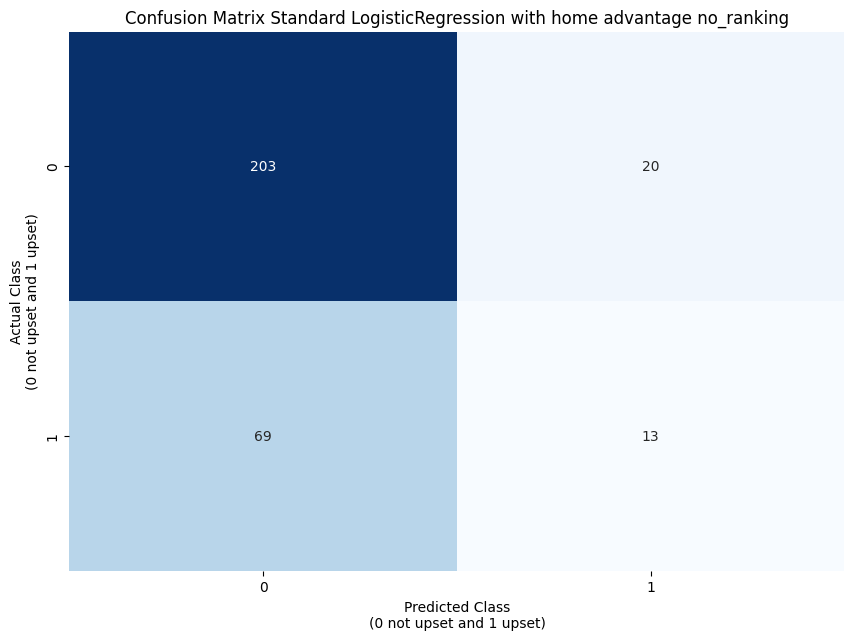

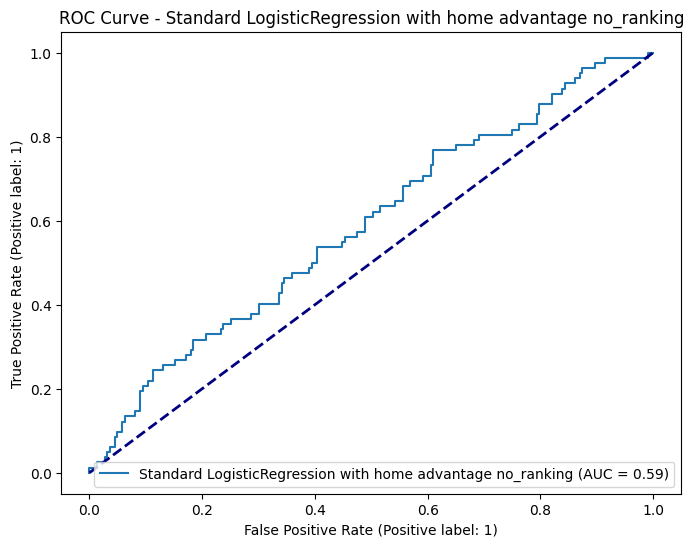

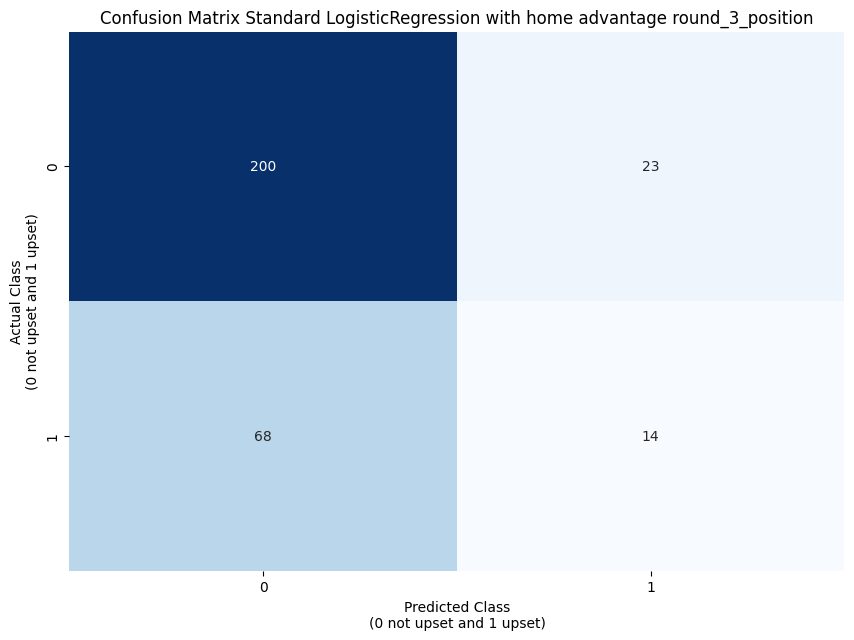

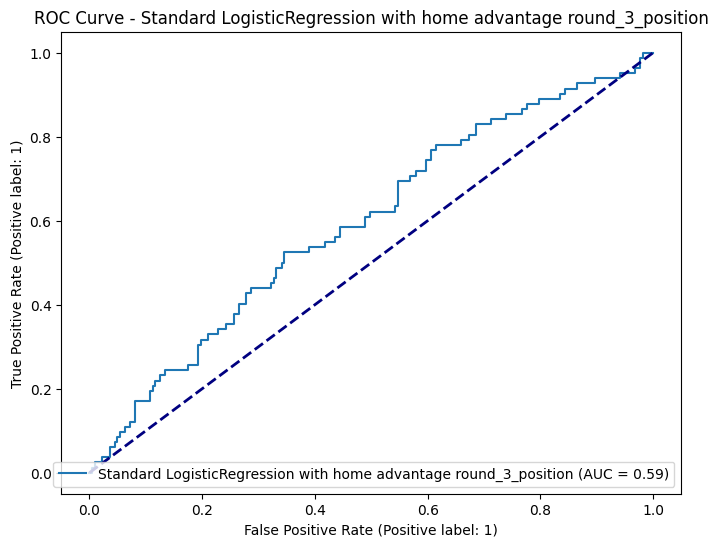

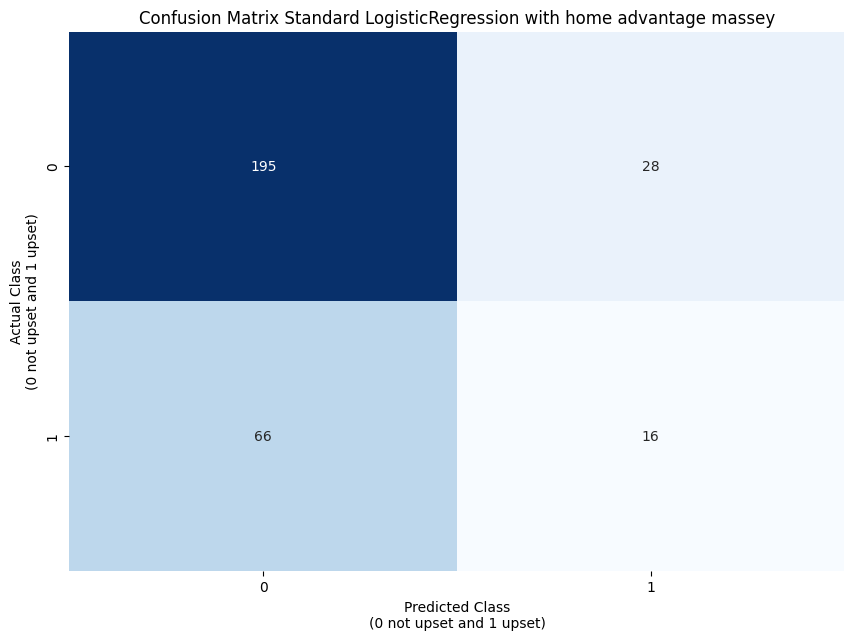

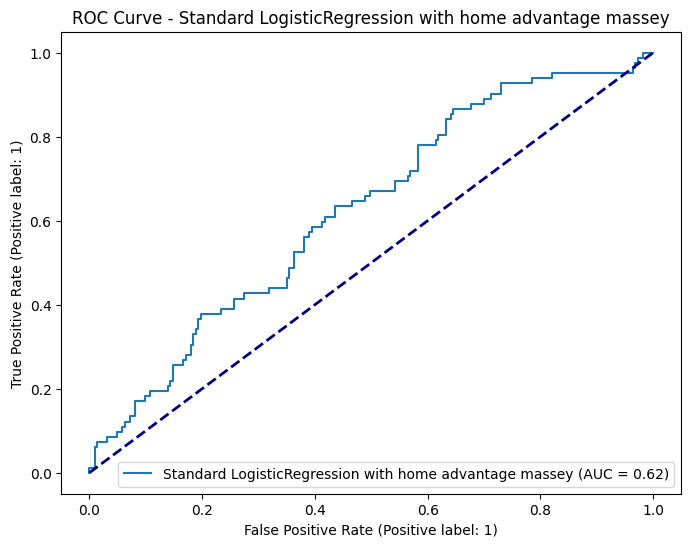

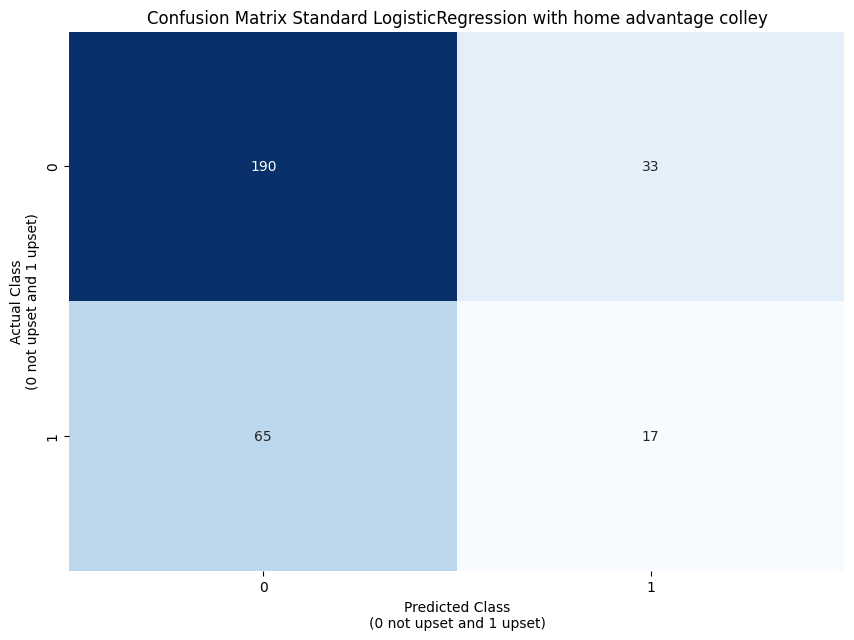

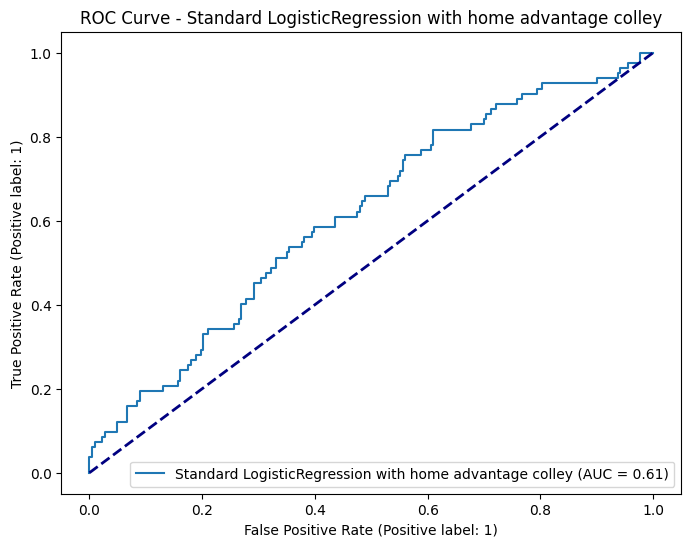

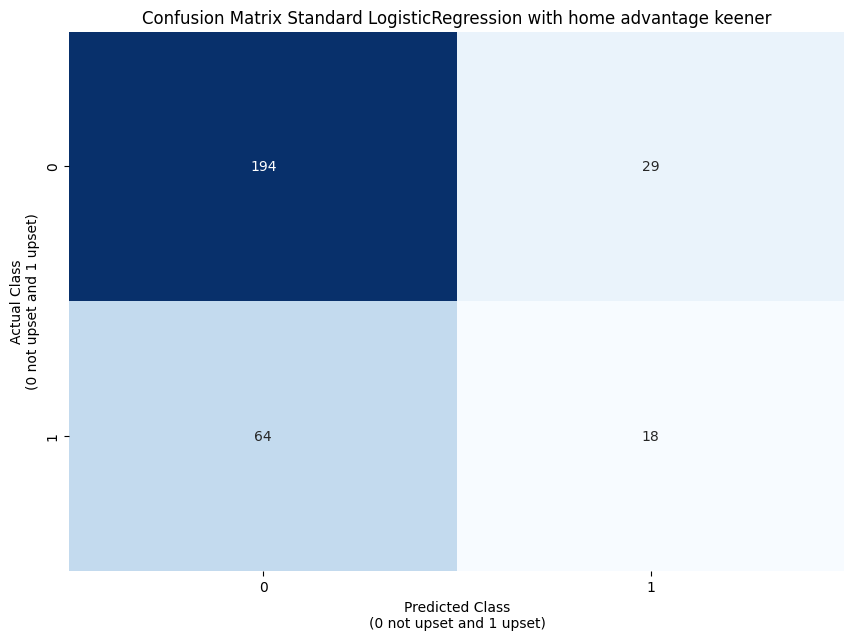

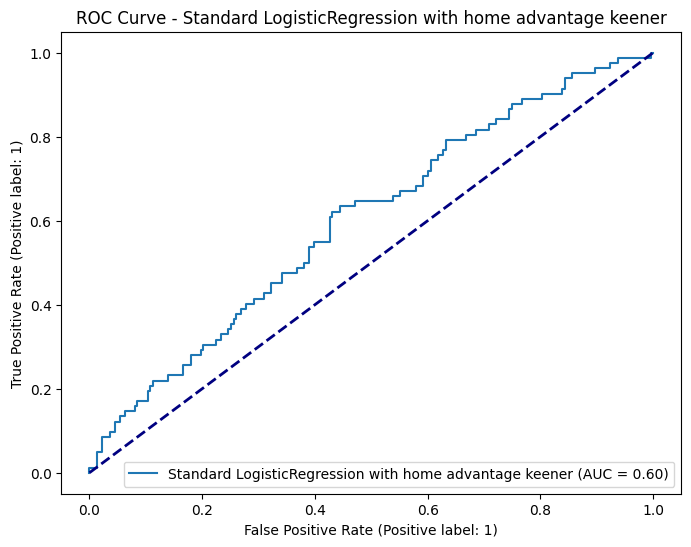

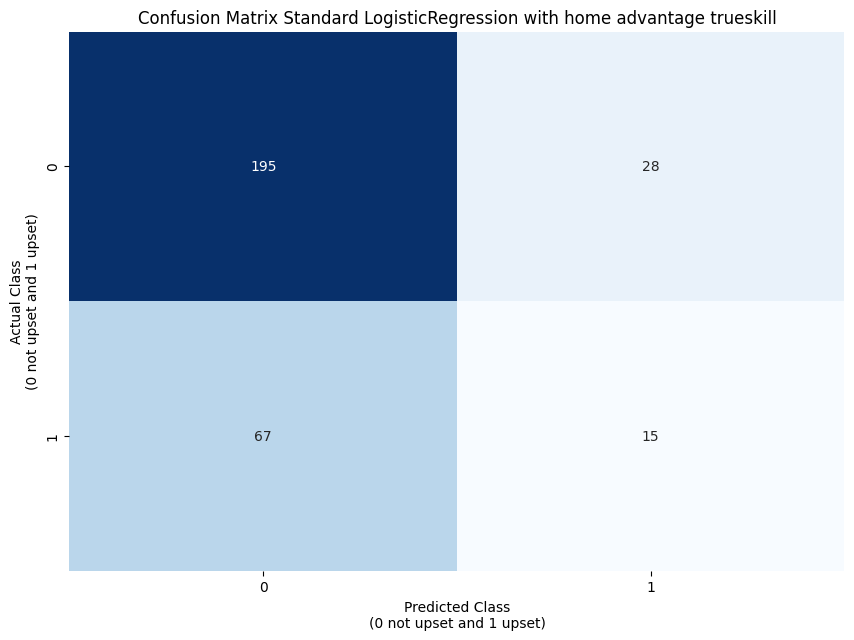

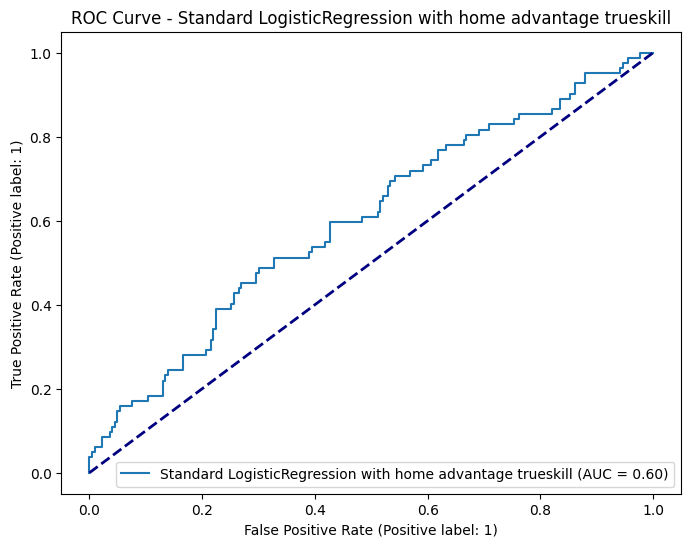

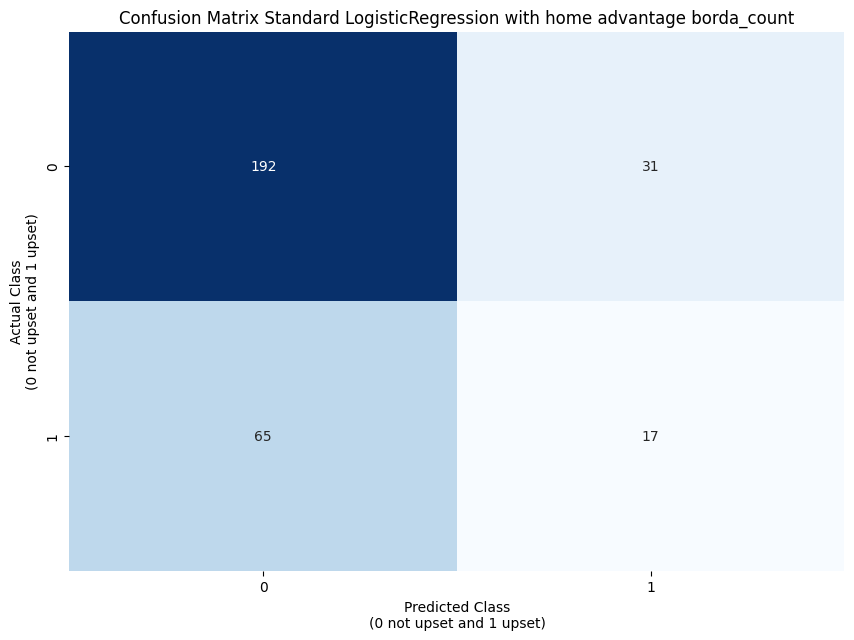

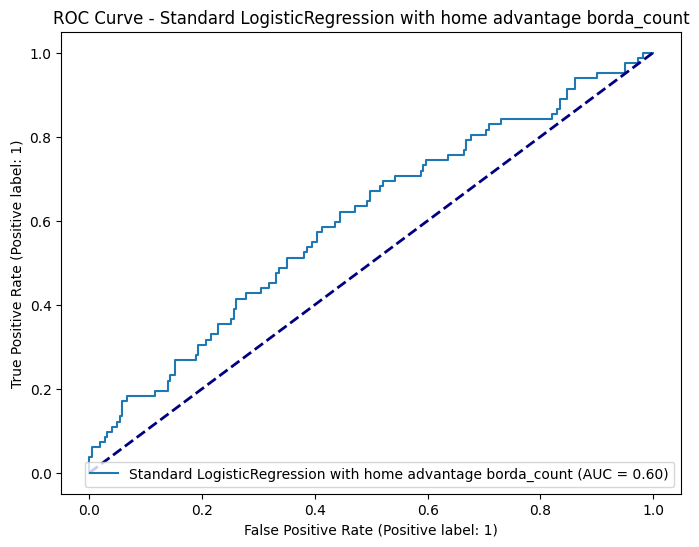

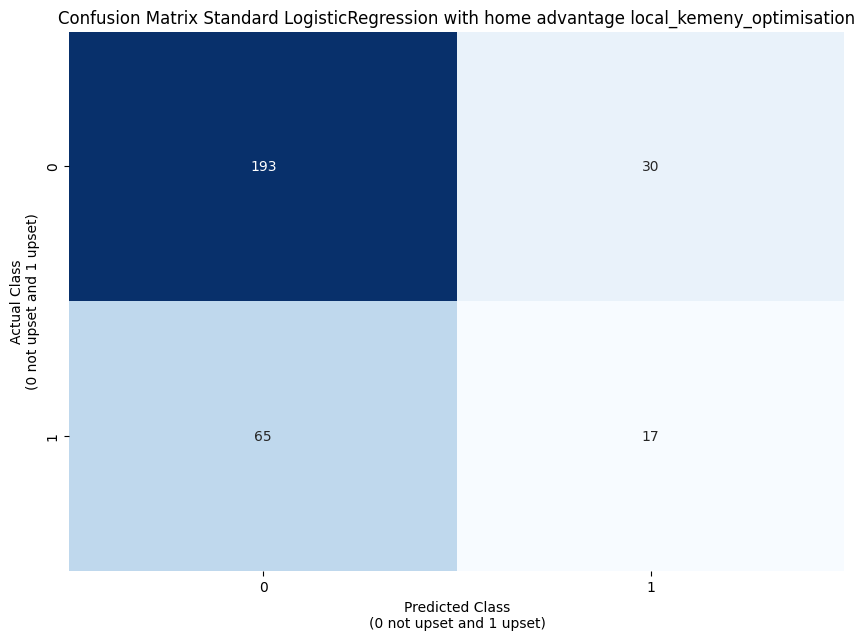

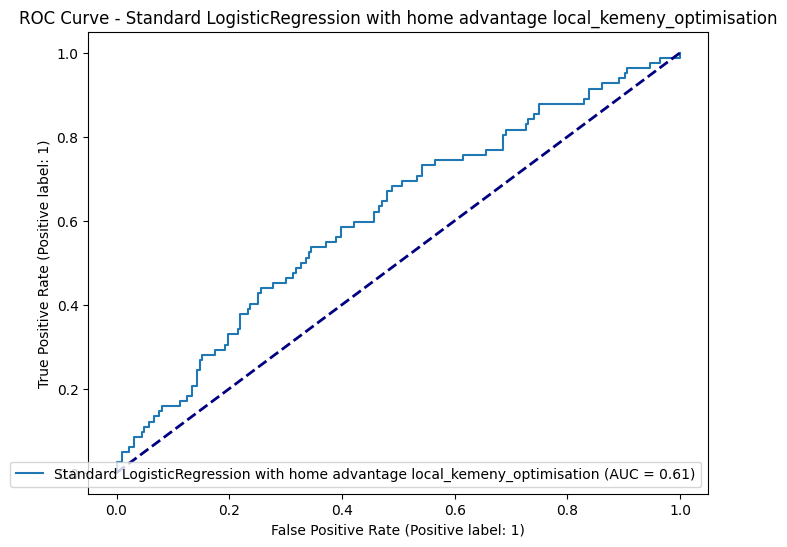

In [10]:
# Standard, no weights with home advantage
model_name = "Standard LogisticRegression with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = LogisticRegression(max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_slrh = all_results_df
display(all_results_df_slrh)

fold_results_df_slrh = fold_results_df
display(fold_results_df_slrh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_slrh.to_excel("all_slrh_results.xlsx")
fold_results_df_slrh.to_excel("fold_results_slrh.xlsx")

Weighted LogisticRegression no_ranking
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.318
Fold 1 Accuracy: 0.738
Fold 1 Recall: 0.000
Weights being used: {0: 27, 1: 73}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__C': 0.09999999999999999, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.394
Fold 2 Accuracy: 0.689
Fold 2 Recall: 0.312
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.288
Fold 3 Accuracy: 0.738
Fold 3 Recall: 0.000
Weights being used: {0: 27, 1: 73}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.411
Fold 4 Accuracy: 0.738
Fold 4 Recall: 0.235
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 0.09999999999999999, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.397
Fold 5 Accuracy: 0.639
Fold 5 Recall: 0.118
Average Accuracy: 0.708
Average Recall: 0.133
Weighted LogisticRegression round_3_position
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.348
Fold 1 Accuracy: 0.705
Fold 1 Recall: 0.188
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 0.09999999999999999, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.409
Fold 2 Accuracy: 0.6

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.396
Fold 4 Accuracy: 0.738
Fold 4 Recall: 0.235
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 0.09999999999999999, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.382
Fold 5 Accuracy: 0.656
Fold 5 Recall: 0.176
Average Accuracy: 0.702
Average Recall: 0.195
Weighted LogisticRegression massey
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.348
Fold 1 Accuracy: 0.705
Fold 1 Recall: 0.188
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 0.09999999999999999, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.424
Fold 2 Accuracy: 0.672
Fold 2 

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__C': 0.09999999999999999, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.424
Fold 2 Accuracy: 0.721
Fold 2 Recall: 0.438
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 0.09999999999999999, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.303
Fold 3 Accuracy: 0.705
Fold 3 Recall: 0.250
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 0.09999999999999999, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.411
Fold 4 Accuracy: 0.787
Fold 4 Recall: 0.235
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 0.09999999999999999, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.413
Fold 5 Accuracy: 0.623
Fold 5 Recall: 0.059
Average Accuracy: 0.715
Average Rec

metric_id                                        metric  \
0           1                Cross-validation Accuracy Mean   
1           2  Cross-validation Accuracy Standard Deviation   
2           3                  Cross-validation Recall Mean   
3           4    Cross-validation Recall Standard Deviation   
4           5                              Overall Accuracy   
5           6    Confusion Matrix - True Negative (Class 0)   
6           7   Confusion Matrix - False Positive (Class 1)   
7           8   Confusion Matrix - False Negative (Class 0)   
8           9    Confusion Matrix - True Positive (Class 1)   
9          10                           Precision (Class 0)   
10         11                              Recall (Class 0)   
11         12                            F1-score (Class 0)   
12         13                           Precision (Class 1)   
13         14                              Recall (Class 1)   
14         15                            F1-score (Class 1)   
15         16                           Macro avg Precision   
16         17                              Macro avg Recall   
17         18                            Macro avg F1-score   
18         19                        Weighted avg Precision   
19         20                           Weighted avg Recall   
20         21                         Weighted avg F1-score   
21         22                                       AUC-ROC   

   Weighted LogisticRegression no_ranking  \
0                                   0.708   
1                                   0.039   
2                                   0.133   
3                                   0.125   
4                                   0.708   
5                                 205.000   
6                                  18.000   
7                                  71.000   
8                                  11.000   
9                                   0.743   
10                                  0.919   
11                                  0.822   
12                                  0.379   
13                                  0.134   
14                                  0.198   
15                                  0.561   
16                                  0.527   
17                                  0.510   
18                                  0.645   
19                                  0.708   
20                                  0.654   
21                                  0.595   

   Weighted LogisticRegression round_3_position  \
0                                         0.702   
1                                         0.033   
2                                         0.195   
3                                         0.120   
4                                         0.702   
5                                       198.000   
6                                        25.000   
7                                        66.000   
8                                        16.000   
9                                         0.750   
10                                        0.888   
11                                        0.813   
12                                        0.390   
13                                        0.195   
14                                        0.260   
15                                        0.570   
16                                        0.542   
17                                        0.537   
18                                        0.653   
19                                        0.702   
20                                        0.664   
21                                        0.632   

   Weighted LogisticRegression massey Weighted LogisticRegression colley  \
0                               0.695                              0.715   
1                               0.045                              0.053   
2                               0.257                              0.196   
3                               0.094   

Model Name Ranking  Fold  \
0              Weighted LogisticRegression no_ranking     1   
1              Weighted LogisticRegression no_ranking     2   
2              Weighted LogisticRegression no_ranking     3   
3              Weighted LogisticRegression no_ranking     4   
4              Weighted LogisticRegression no_ranking     5   
5        Weighted LogisticRegression round_3_position     1   
6        Weighted LogisticRegression round_3_position     2   
7        Weighted LogisticRegression round_3_position     3   
8        Weighted LogisticRegression round_3_position     4   
9        Weighted LogisticRegression round_3_position     5   
10                 Weighted LogisticRegression massey     1   
11                 Weighted LogisticRegression massey     2   
12                 Weighted LogisticRegression massey     3   
13                 Weighted LogisticRegression massey     4   
14                 Weighted LogisticRegression massey     5   
15                 Weighted LogisticRegression colley     1   
16                 Weighted LogisticRegression colley     2   
17                 Weighted LogisticRegression colley     3   
18                 Weighted LogisticRegression colley     4   
19                 Weighted LogisticRegression colley     5   
20                 Weighted LogisticRegression keener     1   
21                 Weighted LogisticRegression keener     2   
22                 Weighted LogisticRegression keener     3   
23                 Weighted LogisticRegression keener     4   
24                 Weighted LogisticRegression keener     5   
25              Weighted LogisticRegression trueskill     1   
26              Weighted LogisticRegression trueskill     2   
27              Weighted LogisticRegression trueskill     3   
28              Weighted LogisticRegression trueskill     4   
29              Weighted LogisticRegression trueskill     5   
30            Weighted LogisticRegression borda_count     1   
31            Weighted LogisticRegression borda_count     2   
32            Weighted LogisticRegression borda_count     3   
33            Weighted LogisticRegression borda_count     4   
34            Weighted LogisticRegression borda_count     5   
35  Weighted LogisticRegression local_kemeny_optim...     1   
36  Weighted LogisticRegression local_kemeny_optim...     2   
37  Weighted LogisticRegression local_kemeny_optim...     3   
38  Weighted LogisticRegression local_kemeny_optim...     4   
39  Weighted LogisticRegression local_kemeny_optim...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__C': 0.01, 'classifier__penalty':...   
1   {'classifier__C': 0.09999999999999999, 'classi...   
2   {'classifier__C': 0.01, 'classifier__penalty':...   
3   {'classifier__C': 1.0, 'classifier__penalty': ...   
4   {'classifier__C': 0.09999999999999999, 'classi...   
5   {'classifier__C': 1.0, 'classifier__penalty': ...   
6   {'classifier__C': 0.09999999999999999, 'classi...   
7   {'classifier__C': 0.01, 'classifier__penalty':...   
8   {'classifier__C': 1.0, 'classifier__penalty': ...   
9   {'classifier__C': 0.09999999999999999, 'classi...   
10  {'classifier__C': 1.0, 'classifier__penalty': ...   
11  {'classifier__C': 0.09999999999999999, 'classi...   
12  {'classifier__C': 0.09999999999999999, 'classi...   
13  {'classifier__C': 1.0, 'classifier__penalty': ...   
14  {'classifier__C': 100.0, 'classifier__penalty'...   
15  {'classifier__C': 0.01, 'classifier__penalty':...   
16  {'classifier__C': 0.09999999999999999, 'classi...   
17  {'classifier__C': 0.09999999999999999, 'classi...   
18  {'classifier__C': 0.09999999999999999, 'classi...   
19  {'classifier__C': 0.09999999999999999, 'classi...   
20  {'classifier__C': 1.0, 'classifier__penalty': ...   
21  {'classifier__C': 0.09999999999999999, 'classi...   
22  {'classifier__C': 0.09999999999999999, 'classi...   
23  {'classifier__C': 1.0, 'classifier__penalty': ...   
24  {'classifier__C': 0.09

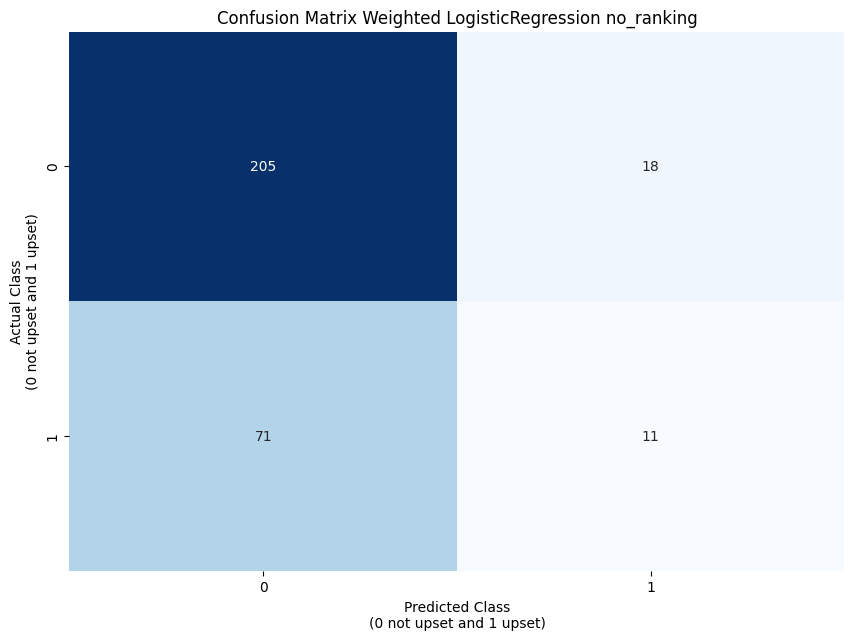

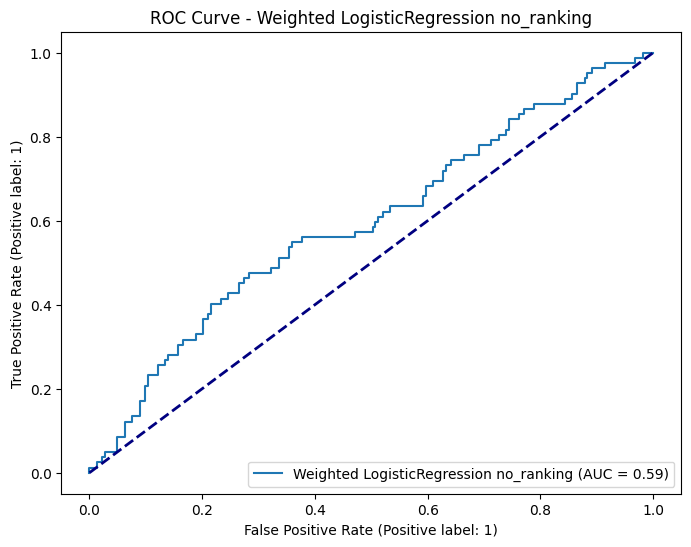

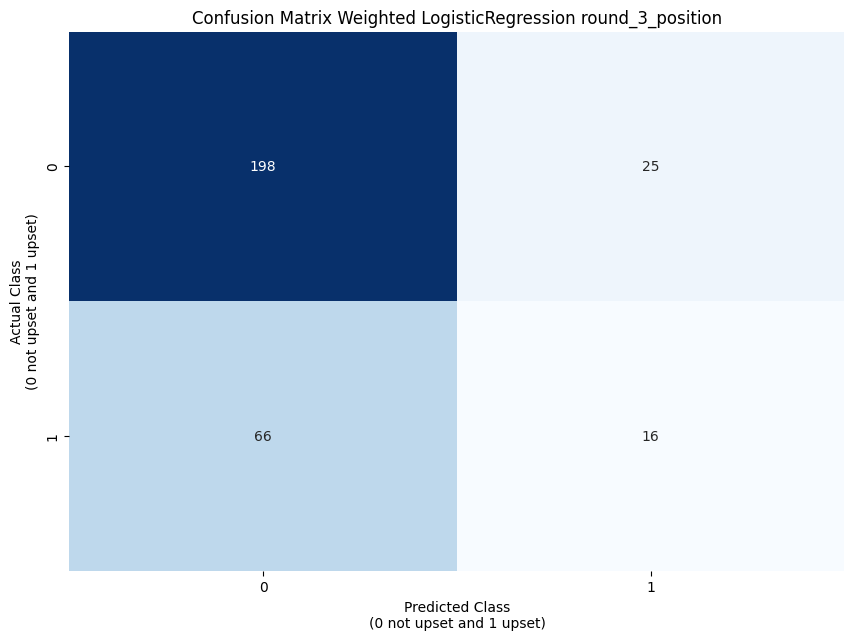

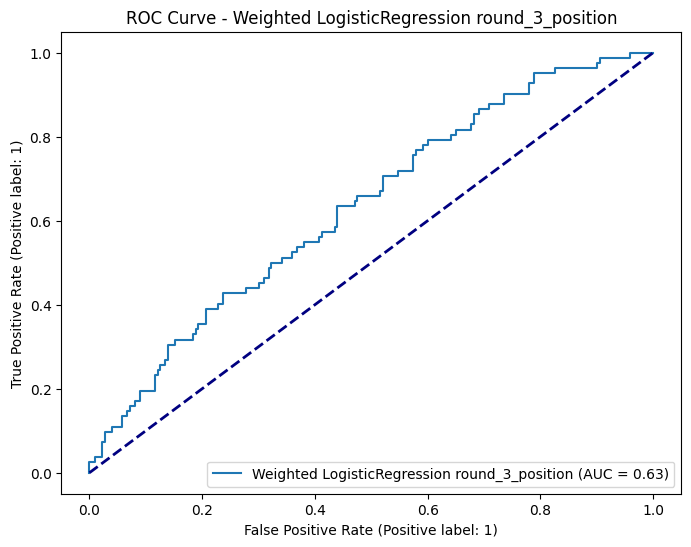

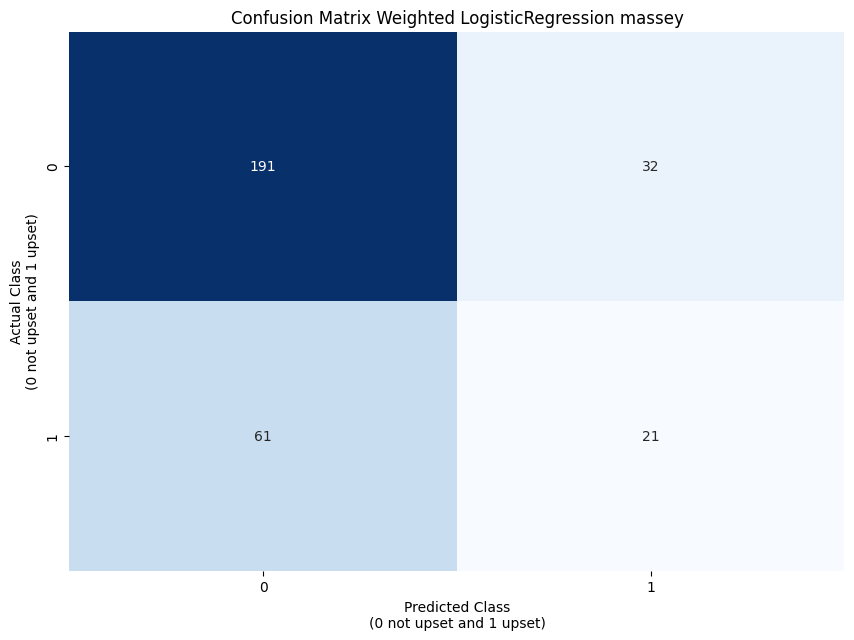

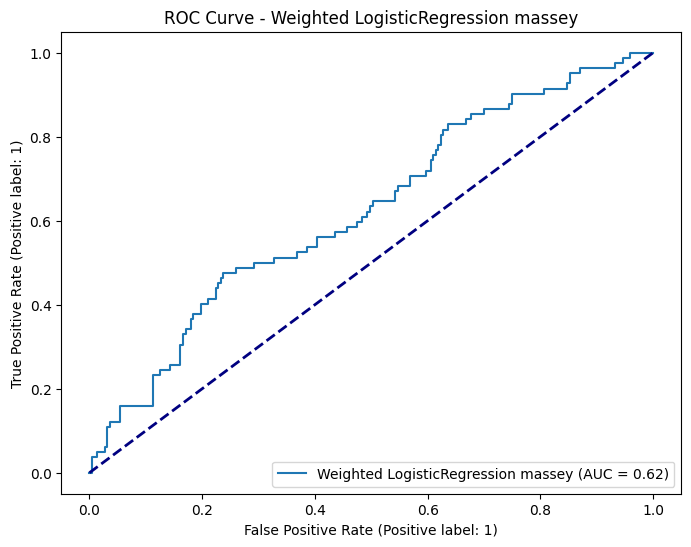

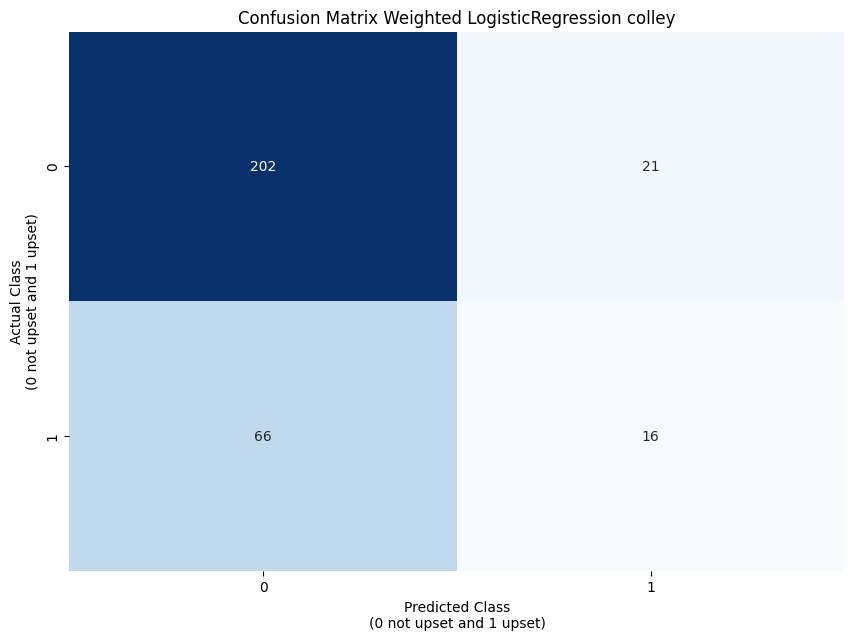

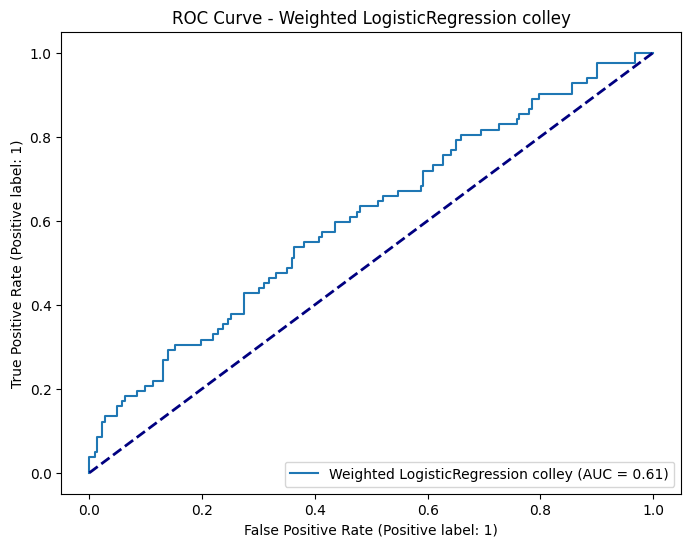

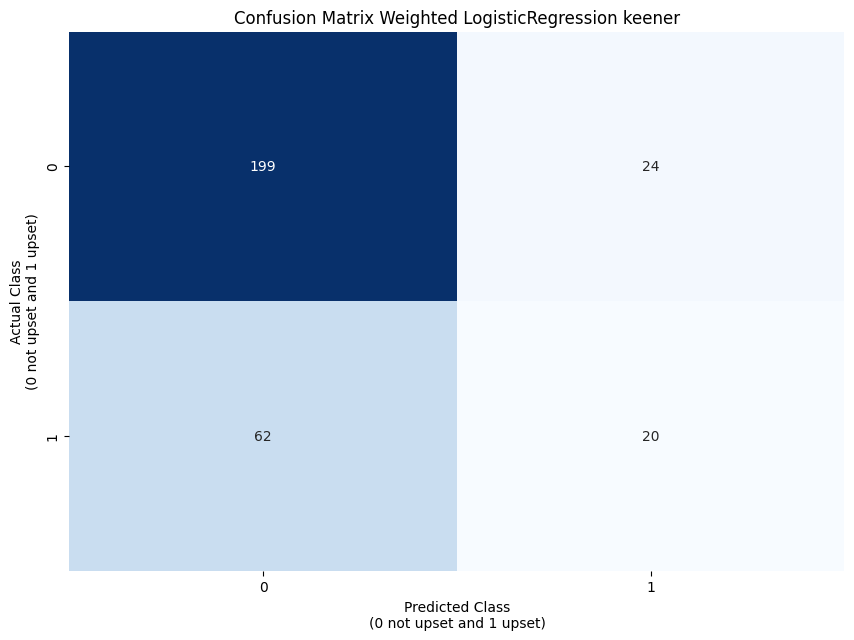

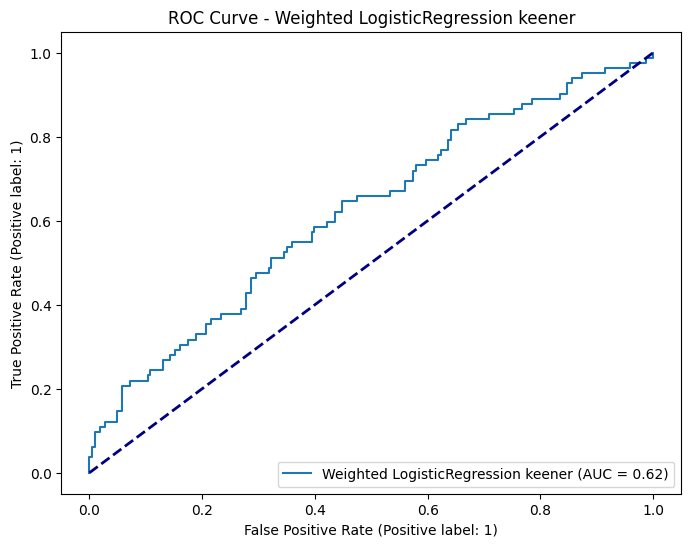

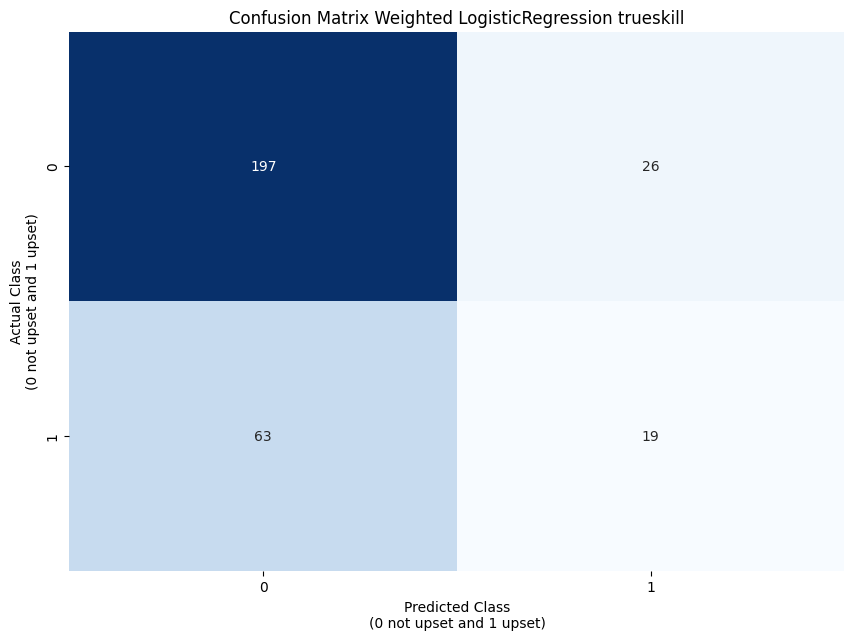

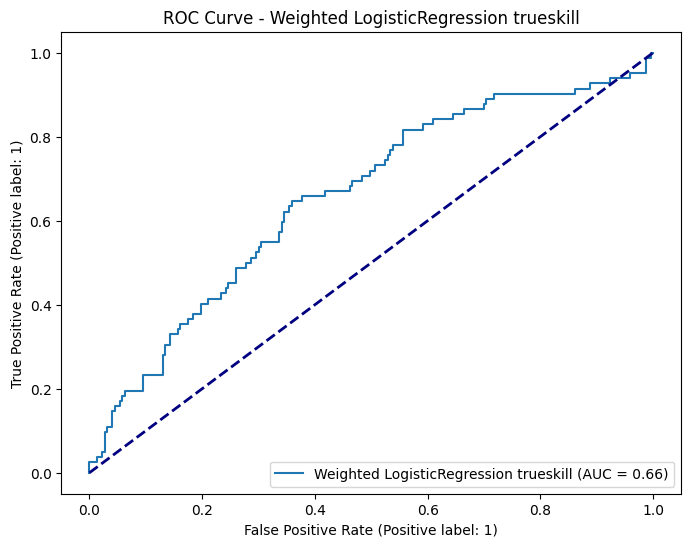

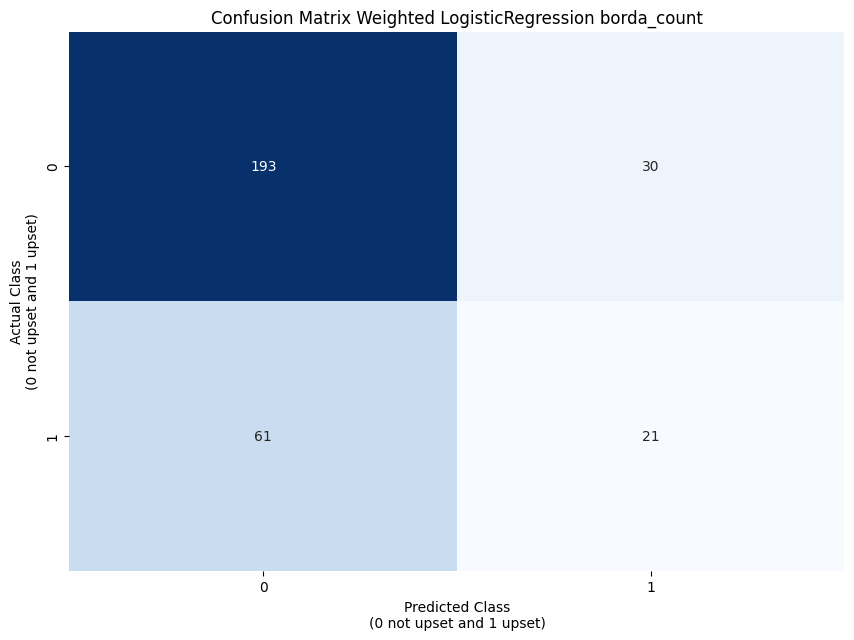

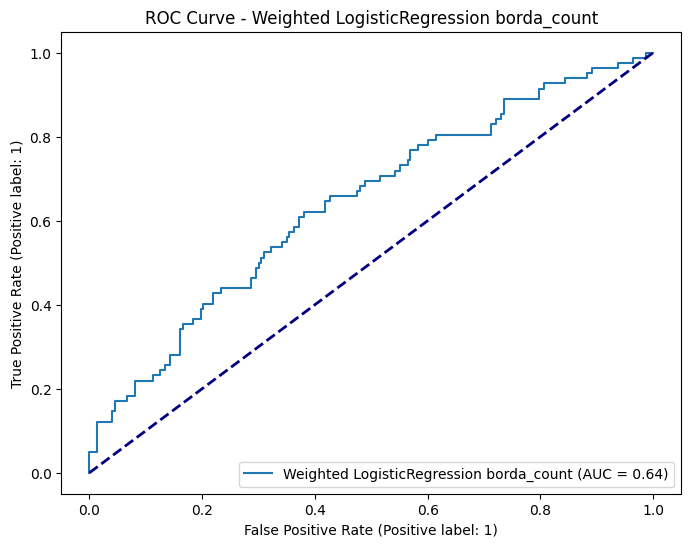

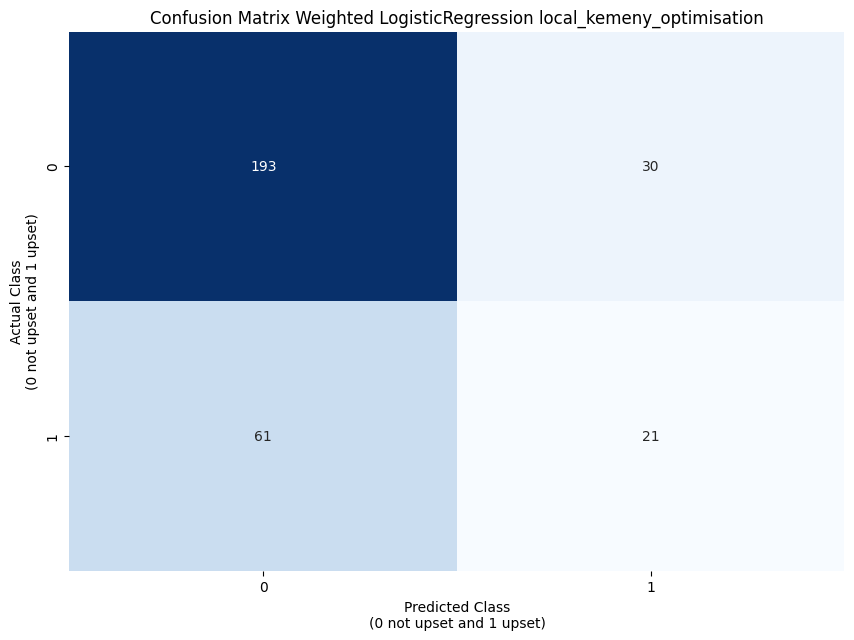

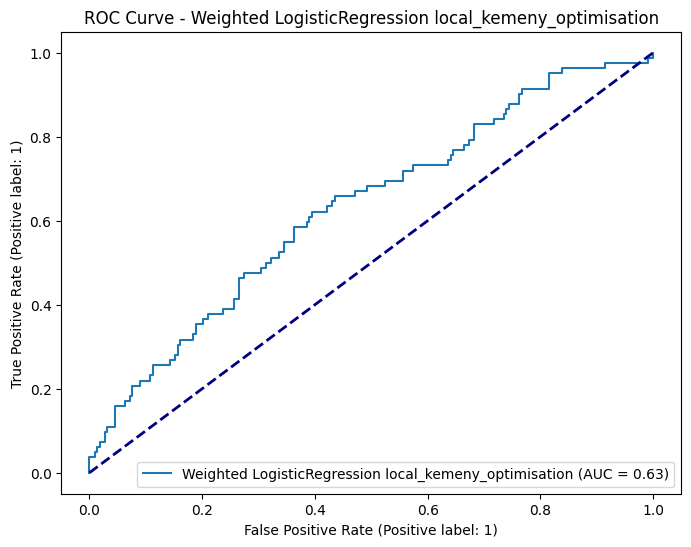

In [11]:
0# Weighted Logistc Regression
model_name = "Weighted LogisticRegression"
home_advt = 'no'
weighted = 'yes'
random_state = 47
weights = {0: 50, 1: 50} # intial value before recalauclating
model_classifier  = LogisticRegression(class_weight=weights, max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_wlr = all_results_df
display(all_results_df_wlr)

fold_results_df_wlr = fold_results_df
display(fold_results_df_wlr)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_wlr.to_excel("all_wlr_results.xlsx")
fold_results_df_wlr.to_excel("fold_results_wlr.xlsx")

Weighted LogisticRegression with home advantage no_ranking
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 0.09999999999999999, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.364
Fold 1 Accuracy: 0.738
Fold 1 Recall: 0.062
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 1.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.424
Fold 2 Accuracy: 0.672
Fold 2 Recall: 0.375
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 0.01, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.288
Fold 3 Accuracy: 0.738
Fold 3 Recall: 0.000
Weights being used: {0: 27, 1: 73}


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.426
Fold 4 Accuracy: 0.705
Fold 4 Recall: 0.118
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 0.09999999999999999, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.413
Fold 5 Accuracy: 0.639
Fold 5 Recall: 0.118
Average Accuracy: 0.698
Average Recall: 0.135
Weighted LogisticRegression with home advantage round_3_position
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 0.09999999999999999, 'classifier__penalty': 'l1', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.333
Fold 1 Accuracy: 0.738
Fold 1 Recall: 0.125
Weights being used: {0: 27, 1: 73}
Best parameters: {'classifier__C': 10.0, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}
Best Estimator's Recall (from GridSearchCV): 0.43

metric_id                                        metric  \
0           1                Cross-validation Accuracy Mean   
1           2  Cross-validation Accuracy Standard Deviation   
2           3                  Cross-validation Recall Mean   
3           4    Cross-validation Recall Standard Deviation   
4           5                              Overall Accuracy   
5           6    Confusion Matrix - True Negative (Class 0)   
6           7   Confusion Matrix - False Positive (Class 1)   
7           8   Confusion Matrix - False Negative (Class 0)   
8           9    Confusion Matrix - True Positive (Class 1)   
9          10                           Precision (Class 0)   
10         11                              Recall (Class 0)   
11         12                            F1-score (Class 0)   
12         13                           Precision (Class 1)   
13         14                              Recall (Class 1)   
14         15                            F1-score (Class 1)   
15         16                           Macro avg Precision   
16         17                              Macro avg Recall   
17         18                            Macro avg F1-score   
18         19                        Weighted avg Precision   
19         20                           Weighted avg Recall   
20         21                         Weighted avg F1-score   
21         22                                       AUC-ROC   

   Weighted LogisticRegression with home advantage no_ranking  \
0                                               0.698           
1                                               0.038           
2                                               0.135           
3                                               0.128           
4                                               0.698           
5                                             202.000           
6                                              21.000           
7                                              71.000           
8                                              11.000           
9                                               0.740           
10                                              0.906           
11                                              0.815           
12                                              0.344           
13                                              0.134           
14                                              0.193           
15                                              0.542           
16                                              0.520           
17                                              0.504           
18                                              0.633           
19                                              0.698           
20                                              0.647           
21                                              0.592           

   Weighted LogisticRegression with home advantage round_3_position  \
0                                               0.698                 
1                                               0.042                 
2                                               0.185                 
3                                               0.132                 
4                                               0.698                 
5                                             198.000                 
6                                              25.000                 
7                                              67.000                 
8                                              15.000                 
9                                               0.747                 
10                                              0.888                 
11                                              0.811                 
12                                              0.375                 
13                                              0.183           

Model Name Ranking  Fold  \
0   Weighted LogisticRegression with home advantag...     1   
1   Weighted LogisticRegression with home advantag...     2   
2   Weighted LogisticRegression with home advantag...     3   
3   Weighted LogisticRegression with home advantag...     4   
4   Weighted LogisticRegression with home advantag...     5   
5   Weighted LogisticRegression with home advantag...     1   
6   Weighted LogisticRegression with home advantag...     2   
7   Weighted LogisticRegression with home advantag...     3   
8   Weighted LogisticRegression with home advantag...     4   
9   Weighted LogisticRegression with home advantag...     5   
10  Weighted LogisticRegression with home advantag...     1   
11  Weighted LogisticRegression with home advantag...     2   
12  Weighted LogisticRegression with home advantag...     3   
13  Weighted LogisticRegression with home advantag...     4   
14  Weighted LogisticRegression with home advantag...     5   
15  Weighted LogisticRegression with home advantag...     1   
16  Weighted LogisticRegression with home advantag...     2   
17  Weighted LogisticRegression with home advantag...     3   
18  Weighted LogisticRegression with home advantag...     4   
19  Weighted LogisticRegression with home advantag...     5   
20  Weighted LogisticRegression with home advantag...     1   
21  Weighted LogisticRegression with home advantag...     2   
22  Weighted LogisticRegression with home advantag...     3   
23  Weighted LogisticRegression with home advantag...     4   
24  Weighted LogisticRegression with home advantag...     5   
25  Weighted LogisticRegression with home advantag...     1   
26  Weighted LogisticRegression with home advantag...     2   
27  Weighted LogisticRegression with home advantag...     3   
28  Weighted LogisticRegression with home advantag...     4   
29  Weighted LogisticRegression with home advantag...     5   
30  Weighted LogisticRegression with home advantag...     1   
31  Weighted LogisticRegression with home advantag...     2   
32  Weighted LogisticRegression with home advantag...     3   
33  Weighted LogisticRegression with home advantag...     4   
34  Weighted LogisticRegression with home advantag...     5   
35  Weighted LogisticRegression with home advantag...     1   
36  Weighted LogisticRegression with home advantag...     2   
37  Weighted LogisticRegression with home advantag...     3   
38  Weighted LogisticRegression with home advantag...     4   
39  Weighted LogisticRegression with home advantag...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__C': 0.09999999999999999, 'classi...   
1   {'classifier__C': 1.0, 'classifier__penalty': ...   
2   {'classifier__C': 0.01, 'classifier__penalty':...   
3   {'classifier__C': 10.0, 'classifier__penalty':...   
4   {'classifier__C': 0.09999999999999999, 'classi...   
5   {'classifier__C': 0.09999999999999999, 'classi...   
6   {'classifier__C': 10.0, 'classifier__penalty':...   
7   {'classifier__C': 1.0, 'classifier__penalty': ...   
8   {'classifier__C': 0.09999999999999999, 'classi...   
9   {'classifier__C': 1.0, 'classifier__penalty': ...   
10  {'classifier__C': 0.09999999999999999, 'classi...   
11  {'classifier__C': 100.0, 'classifier__penalty'...   
12  {'classifier__C': 1.0, 'classifier__penalty': ...   
13  {'classifier__C': 1.0, 'classifier__penalty': ...   
14  {'classifier__C': 0.09999999999999999, 'classi...   
15  {'classifier__C': 0.09999999999999999, 'classi...   
16  {'classifier__C': 1.0, 'classifier__penalty': ...   
17  {'classifier__C': 0.09999999999999999, 'classi...   
18  {'classifier__C': 1.0, 'classifier__penalty': ...   
19  {'classifier__C': 0.09999999999999999, 'classi...   
20  {'classifier__C': 1.0, 'classifier__penalty': ...   
21  {'classifier__C': 0.09999999999999999, 'classi...   
22  {'classifier__C': 1.0, 'classifier__penalty': ...   
23  {'classifier__C': 1.0, 'classifier__penalty': ...   
24  {'classifier__C': 0.09

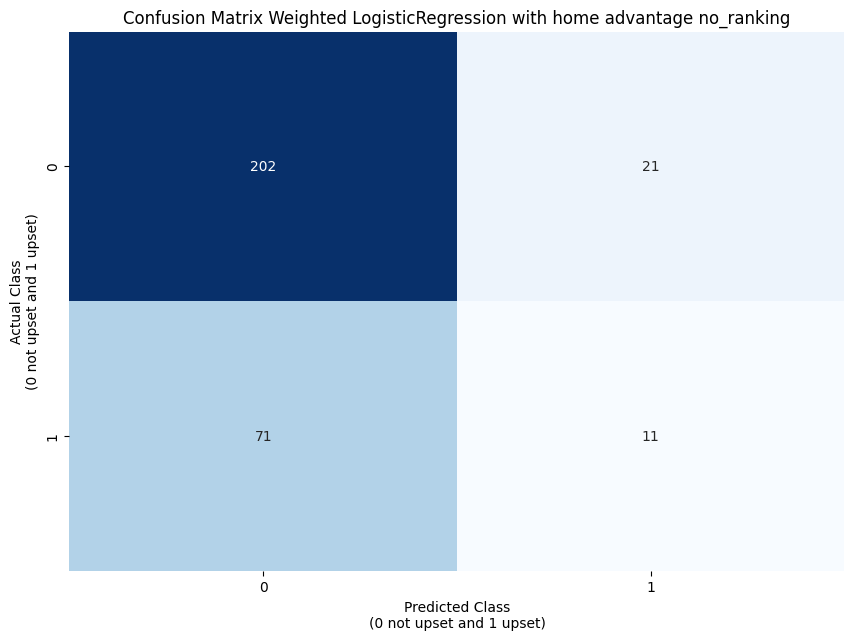

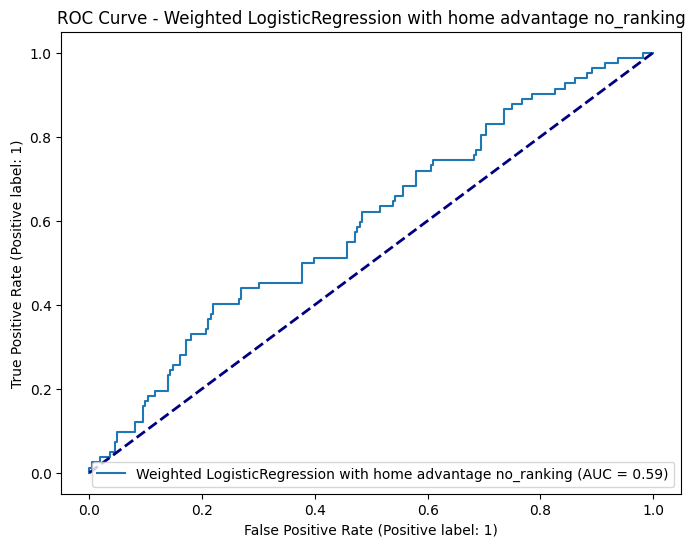

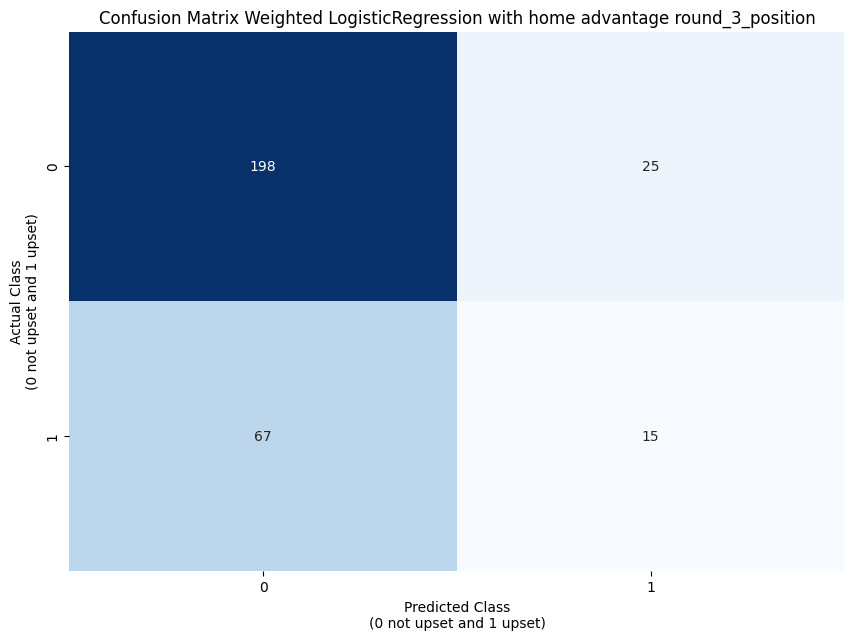

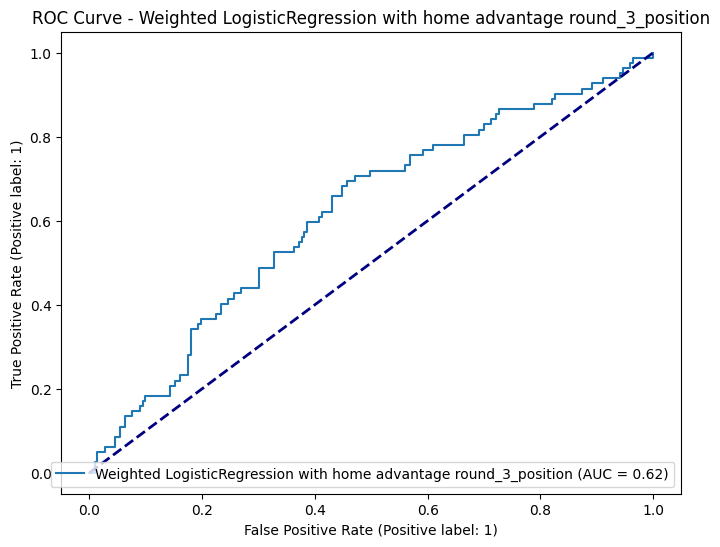

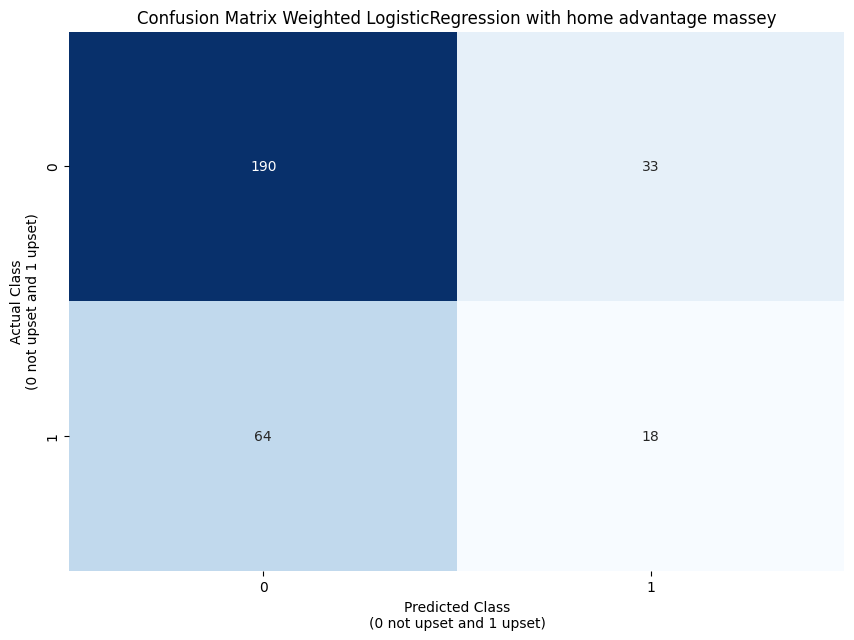

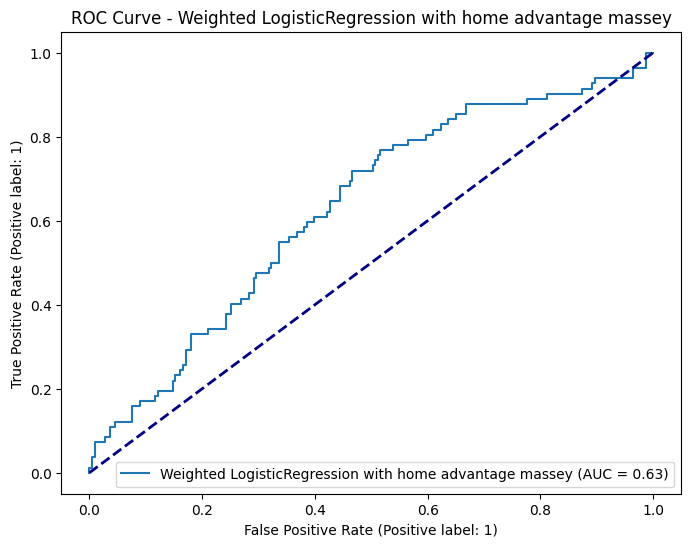

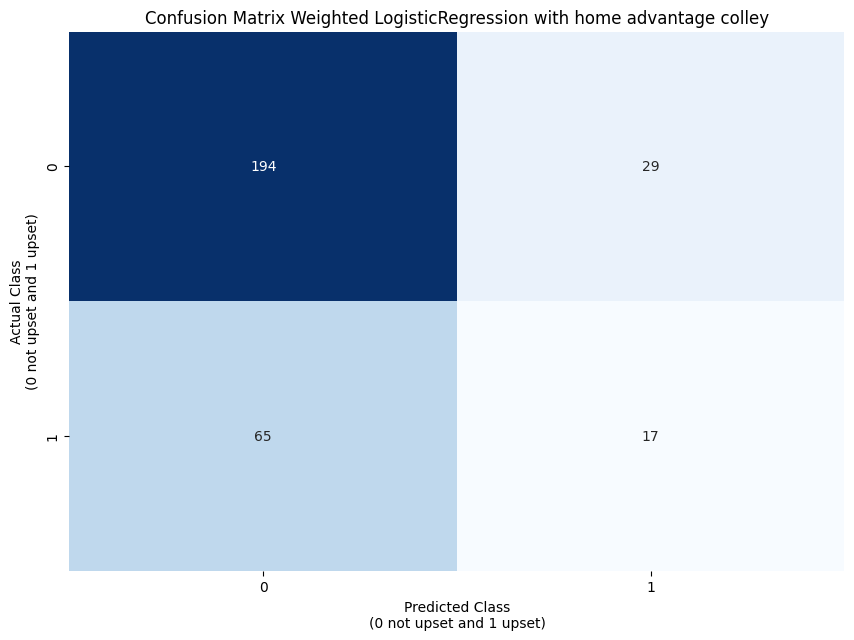

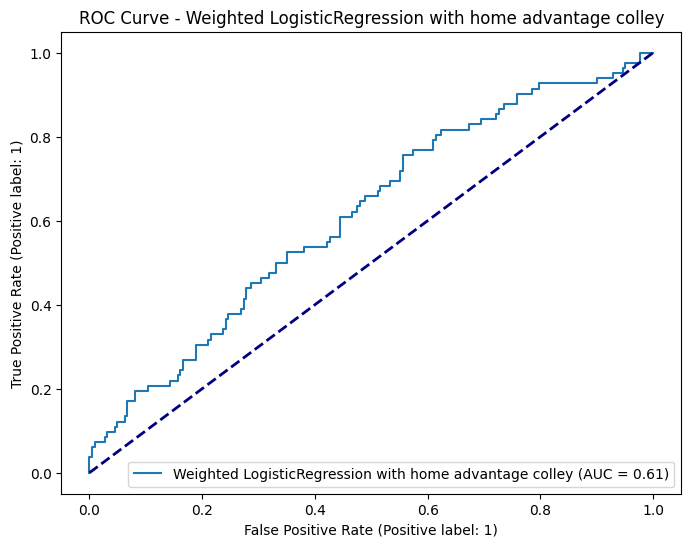

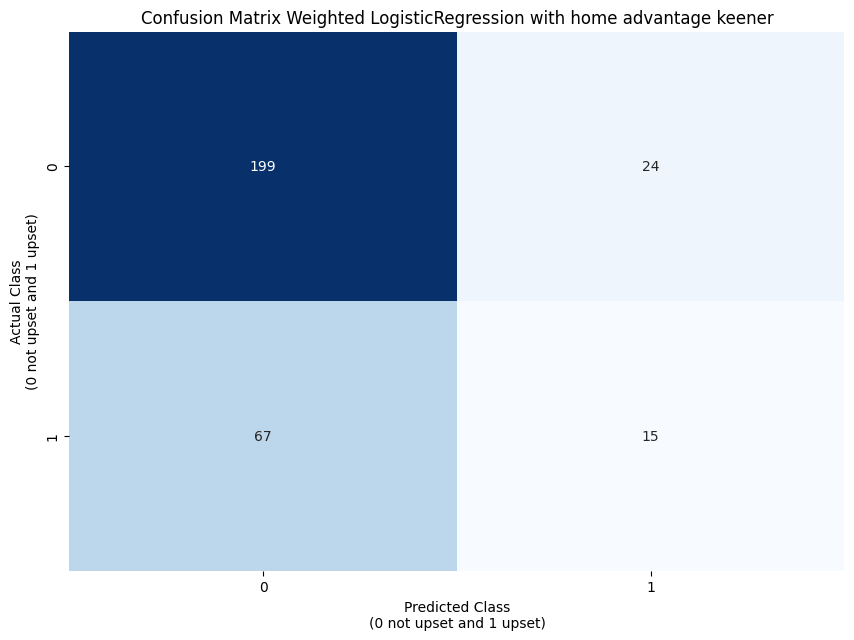

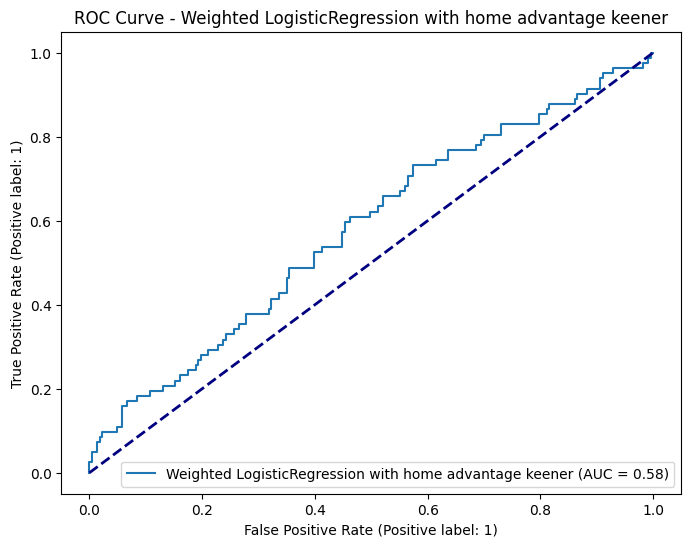

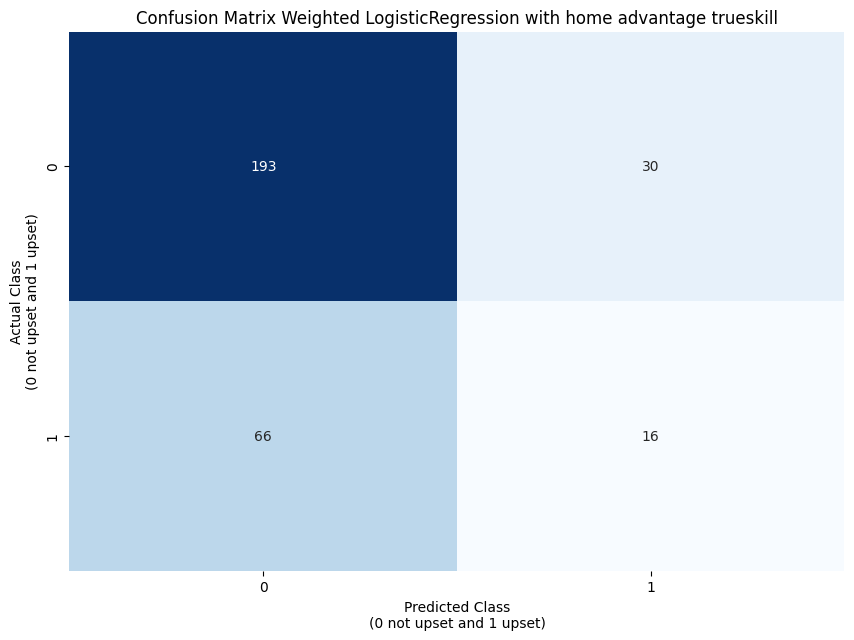

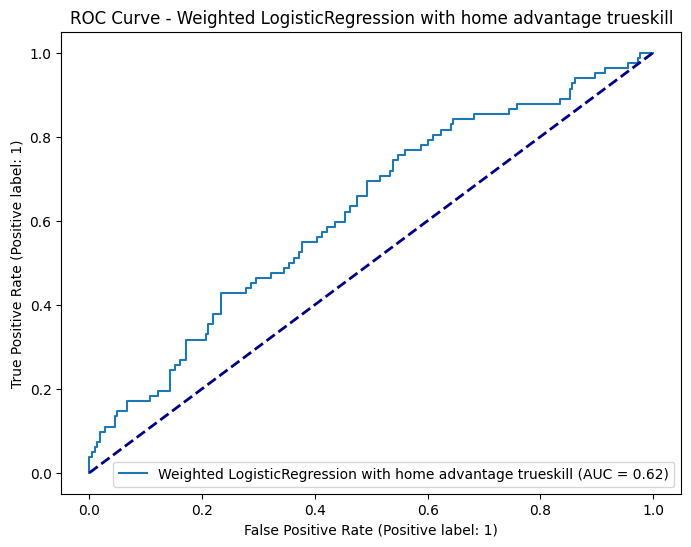

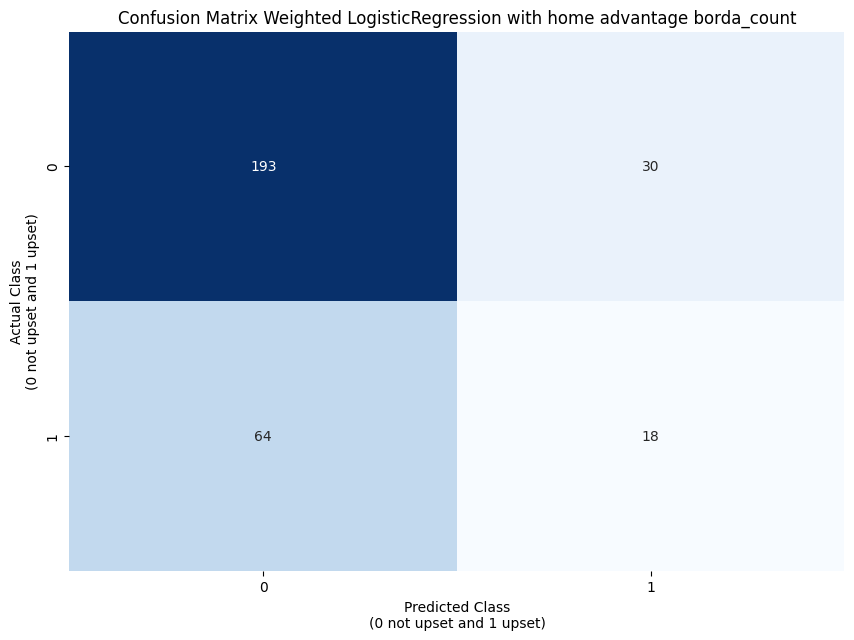

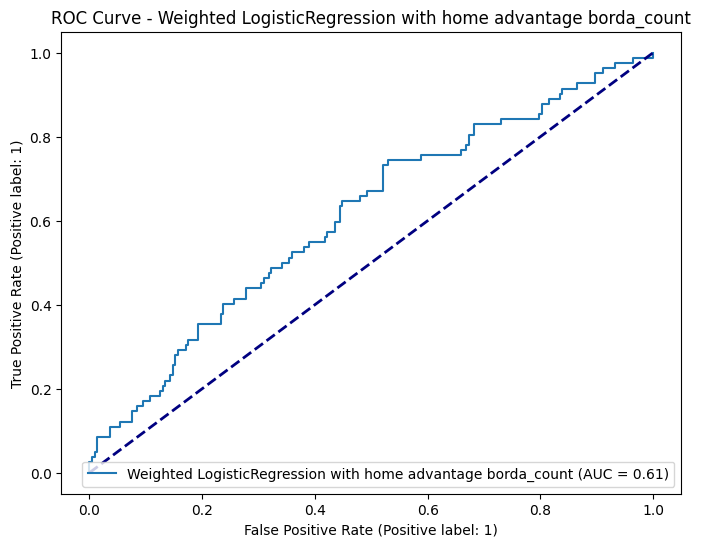

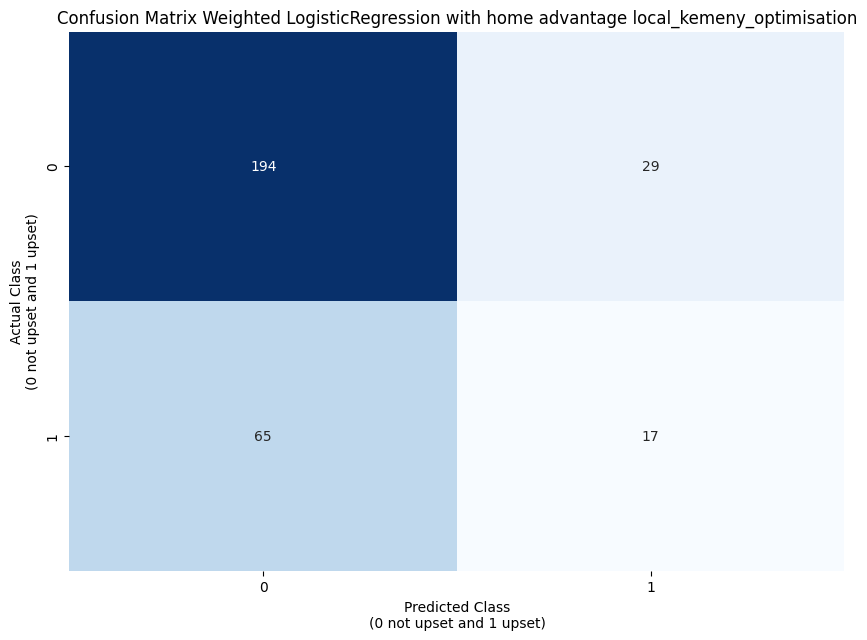

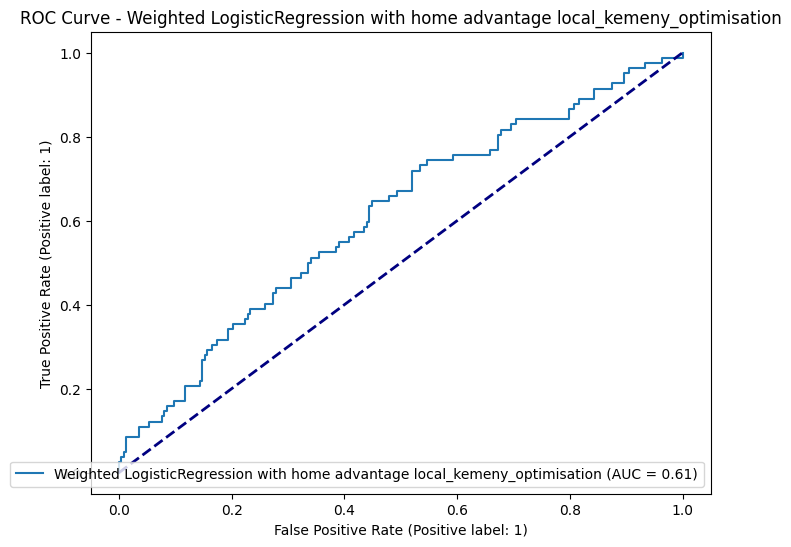

In [12]:
# Weighted Logistc Regression with home advatange
model_name = "Weighted LogisticRegression with home advantage"
home_advt = 'yes'
weighted = 'yes'
random_state = 47
model_classifier  = LogisticRegression(class_weight=weights, max_iter=1000)

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__C': np.logspace(-3, 3, 7),
    'classifier__penalty': ['l1', 'l2'],
    'classifier__solver': ['liblinear']
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_wlrh = all_results_df
display(all_results_df_wlrh)

fold_results_df_wlrh = fold_results_df
display(fold_results_df_wlrh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_wlrh.to_excel("all_wlrh_results.xlsx")
fold_results_df_wlrh.to_excel("fold_results_wlrh.xlsx")

MLP Classifier Neural Network no_ranking
Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.500
Fold 1 Accuracy: 0.607
Fold 1 Recall: 0.500
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.697
Fold 2 Accuracy: 0.639
Fold 2 Recall: 0.312
Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.001, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.273
Fold 3 Accuracy: 0.721
Fold 3 Recall: 0.438
Best parameters: {'classifier__activation': 'logistic', 'classifie

metric_id                                        metric  \
0           1                Cross-validation Accuracy Mean   
1           2  Cross-validation Accuracy Standard Deviation   
2           3                  Cross-validation Recall Mean   
3           4    Cross-validation Recall Standard Deviation   
4           5                              Overall Accuracy   
5           6    Confusion Matrix - True Negative (Class 0)   
6           7   Confusion Matrix - False Positive (Class 1)   
7           8   Confusion Matrix - False Negative (Class 0)   
8           9    Confusion Matrix - True Positive (Class 1)   
9          10                           Precision (Class 0)   
10         11                              Recall (Class 0)   
11         12                            F1-score (Class 0)   
12         13                           Precision (Class 1)   
13         14                              Recall (Class 1)   
14         15                            F1-score (Class 1)   
15         16                           Macro avg Precision   
16         17                              Macro avg Recall   
17         18                            Macro avg F1-score   
18         19                        Weighted avg Precision   
19         20                           Weighted avg Recall   
20         21                         Weighted avg F1-score   
21         22                                       AUC-ROC   

   MLP Classifier Neural Network no_ranking  \
0                                     0.659   
1                                     0.038   
2                                     0.368   
3                                     0.140   
4                                     0.659   
5                                   171.000   
6                                    52.000   
7                                    52.000   
8                                    30.000   
9                                     0.767   
10                                    0.767   
11                                    0.767   
12                                    0.366   
13                                    0.366   
14                                    0.366   
15                                    0.566   
16                                    0.566   
17                                    0.566   
18                                    0.659   
19                                    0.659   
20                                    0.659   
21                                    0.570   

   MLP Classifier Neural Network round_3_position  \
0                                           0.600   
1                                           0.051   
2                                           0.442   
3                                           0.140   
4                                           0.600   
5                                         147.000   
6                                          76.000   
7                                          46.000   
8                                          36.000   
9                                           0.762   
10                                          0.659   
11                                          0.707   
12                                          0.321   
13                                          0.439   
14                                          0.371   
15                                          0.542   
16                                          0.549   
17                                          0.539   
18                                          0.643   
19                                          0.600   
20                                          0.617   
21                                          0.599   

   MLP Classifier Neural Network massey MLP Classifier Neural Network colley  \
0                                 0.590                                0.620   
1                                 0.034                                0.049   
2           

Model Name Ranking  Fold  \
0            MLP Classifier Neural Network no_ranking     1   
1            MLP Classifier Neural Network no_ranking     2   
2            MLP Classifier Neural Network no_ranking     3   
3            MLP Classifier Neural Network no_ranking     4   
4            MLP Classifier Neural Network no_ranking     5   
5      MLP Classifier Neural Network round_3_position     1   
6      MLP Classifier Neural Network round_3_position     2   
7      MLP Classifier Neural Network round_3_position     3   
8      MLP Classifier Neural Network round_3_position     4   
9      MLP Classifier Neural Network round_3_position     5   
10               MLP Classifier Neural Network massey     1   
11               MLP Classifier Neural Network massey     2   
12               MLP Classifier Neural Network massey     3   
13               MLP Classifier Neural Network massey     4   
14               MLP Classifier Neural Network massey     5   
15               MLP Classifier Neural Network colley     1   
16               MLP Classifier Neural Network colley     2   
17               MLP Classifier Neural Network colley     3   
18               MLP Classifier Neural Network colley     4   
19               MLP Classifier Neural Network colley     5   
20               MLP Classifier Neural Network keener     1   
21               MLP Classifier Neural Network keener     2   
22               MLP Classifier Neural Network keener     3   
23               MLP Classifier Neural Network keener     4   
24               MLP Classifier Neural Network keener     5   
25            MLP Classifier Neural Network trueskill     1   
26            MLP Classifier Neural Network trueskill     2   
27            MLP Classifier Neural Network trueskill     3   
28            MLP Classifier Neural Network trueskill     4   
29            MLP Classifier Neural Network trueskill     5   
30          MLP Classifier Neural Network borda_count     1   
31          MLP Classifier Neural Network borda_count     2   
32          MLP Classifier Neural Network borda_count     3   
33          MLP Classifier Neural Network borda_count     4   
34          MLP Classifier Neural Network borda_count     5   
35  MLP Classifier Neural Network local_kemeny_opt...     1   
36  MLP Classifier Neural Network local_kemeny_opt...     2   
37  MLP Classifier Neural Network local_kemeny_opt...     3   
38  MLP Classifier Neural Network local_kemeny_opt...     4   
39  MLP Classifier Neural Network local_kemeny_opt...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__activation': 'logistic', 'classi...   
1   {'classifier__activation': 'relu', 'classifier...   
2   {'classifier__activation': 'tanh', 'classifier...   
3   {'classifier__activation': 'logistic', 'classi...   
4   {'classifier__activation': 'tanh', 'classifier...   
5   {'classifier__activation': 'tanh', 'classifier...   
6   {'classifier__activation': 'relu', 'classifier...   
7   {'classifier__activation': 'relu', 'classifier...   
8   {'classifier__activation': 'logistic', 'classi...   
9   {'classifier__activation': 'tanh', 'classifier...   
10  {'classifier__activation': 'logistic', 'classi...   
11  {'classifier__activation': 'tanh', 'classifier...   
12  {'classifier__activation': 'relu', 'classifier...   
13  {'classifier__activation': 'relu', 'classifier...   
14  {'classifier__activation': 'tanh', 'classifier...   
15  {'classifier__activation': 'logistic', 'classi...   
16  {'classifier__activation': 'logistic', 'classi...   
17  {'classifier__activation': 'relu', 'classifier...   
18  {'classifier__activation': 'relu', 'classifier...   
19  {'classifier__activation': 'tanh', 'classifier...   
20  {'classifier__activation': 'relu', 'classifier...   
21  {'classifier__activation': 'logistic', 'classi...   
22  {'classifier__activation': 'relu', 'classifier...   
23  {'classifier__activation': 'relu', 'classifier...   
24  {'classifier__activati

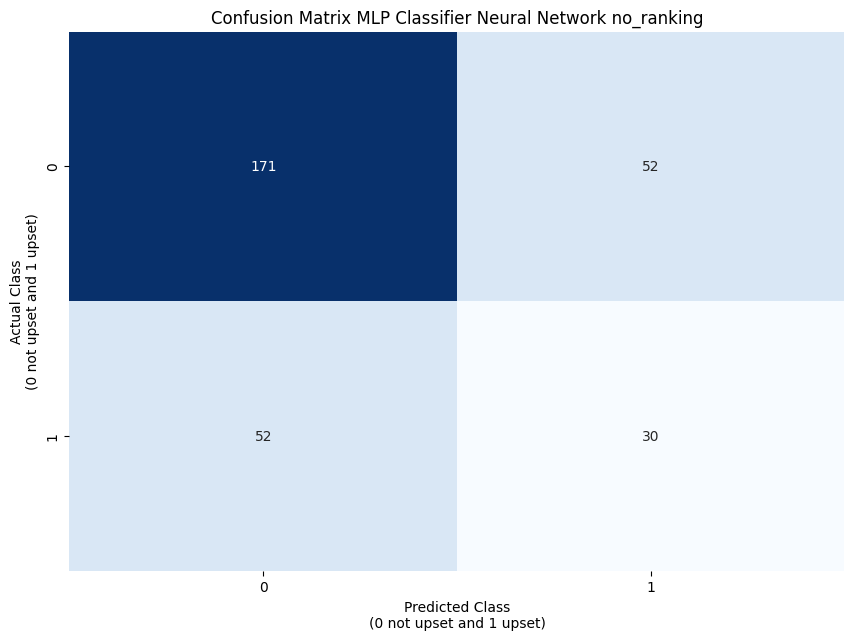

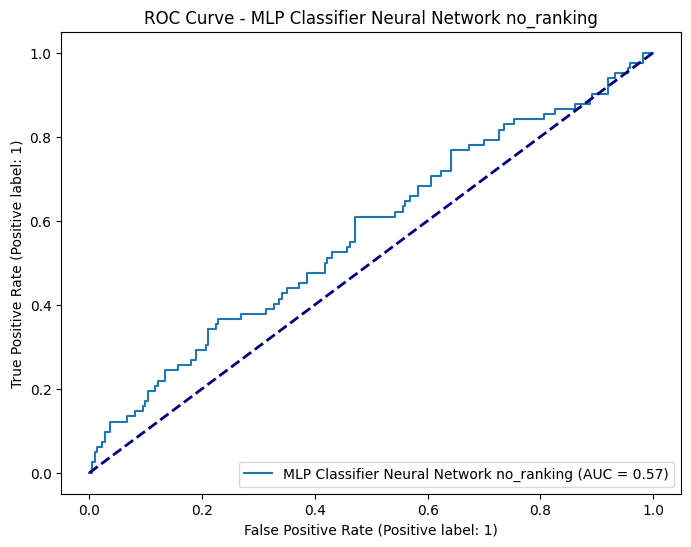

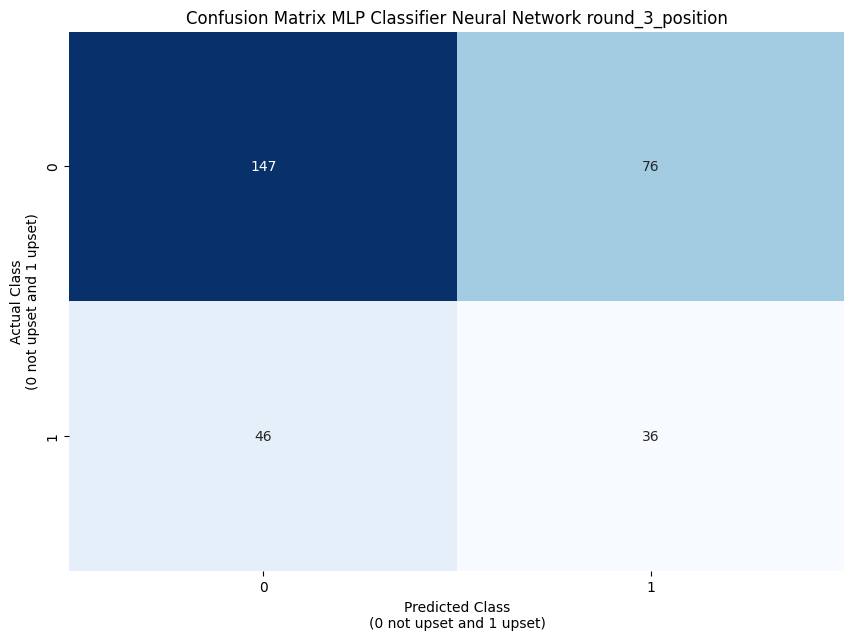

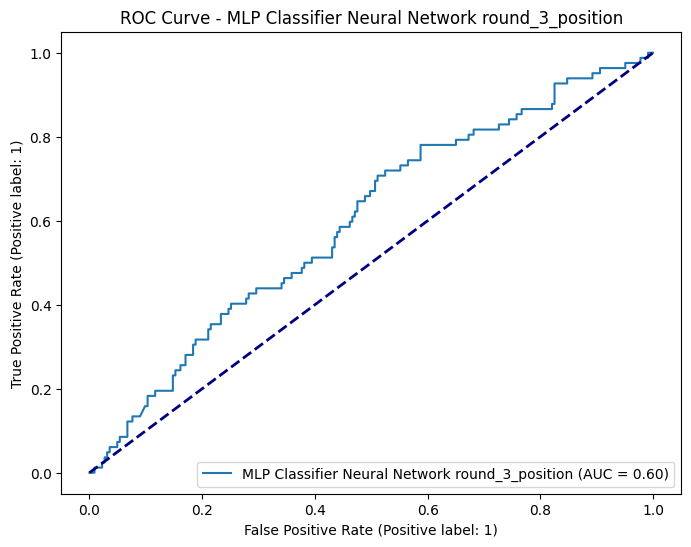

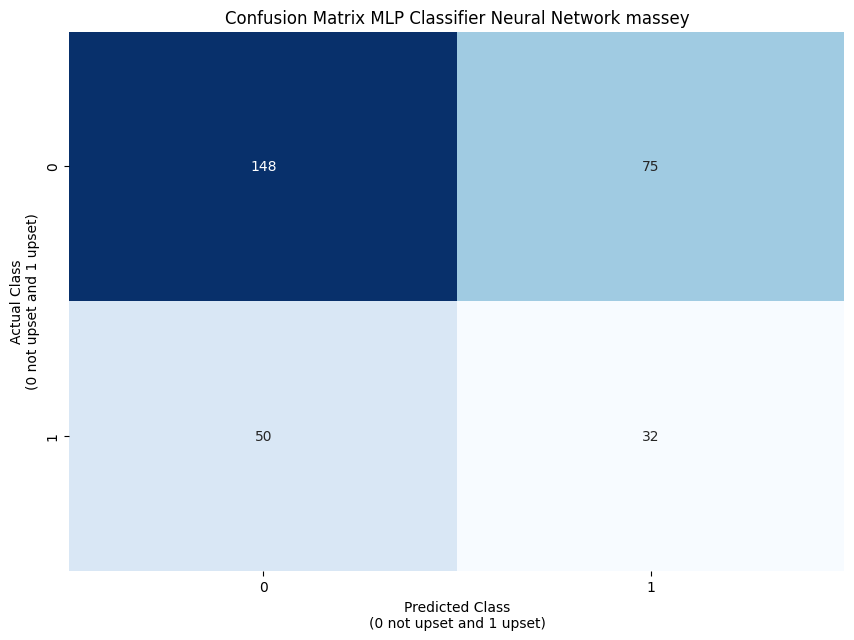

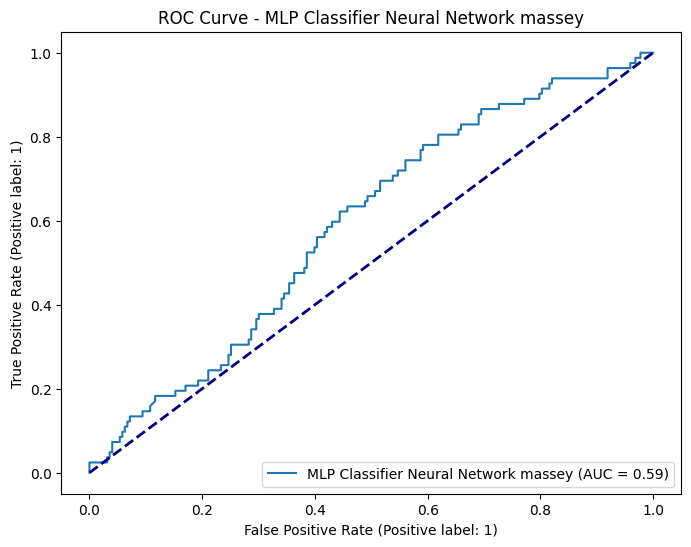

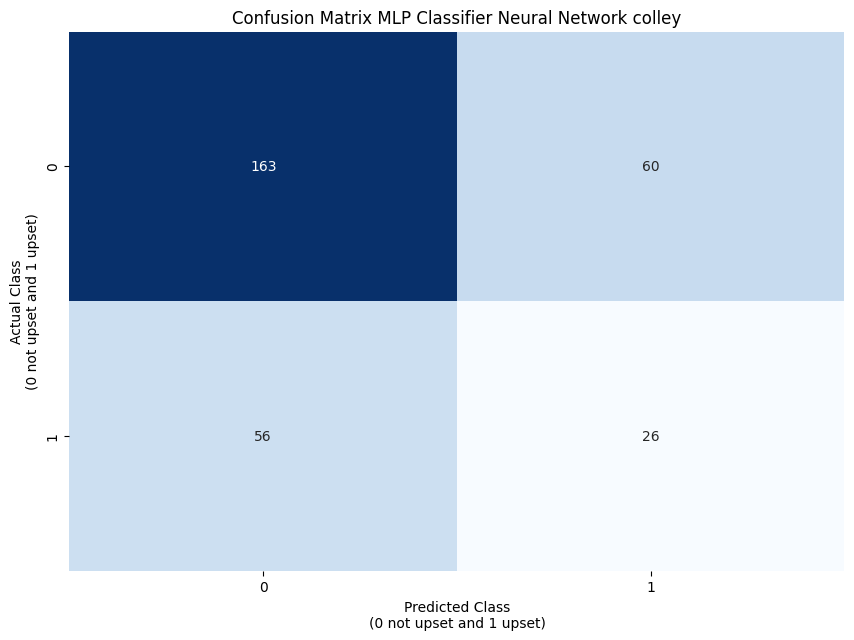

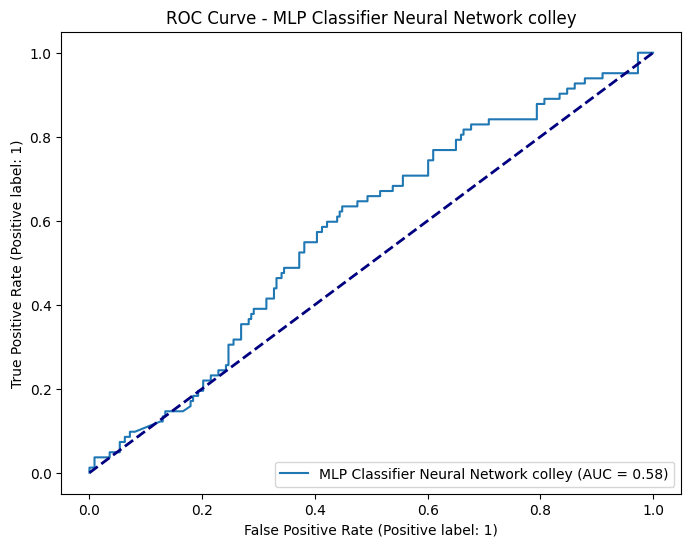

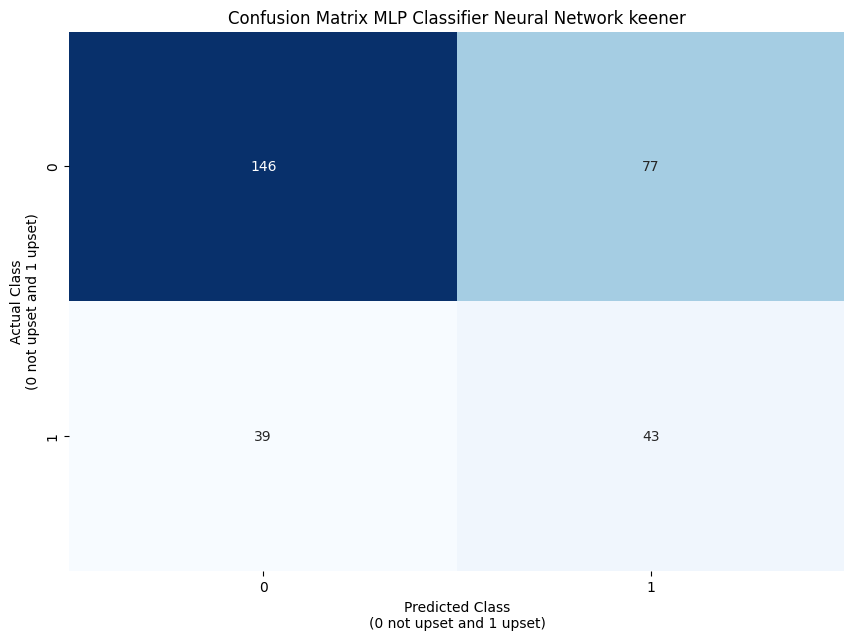

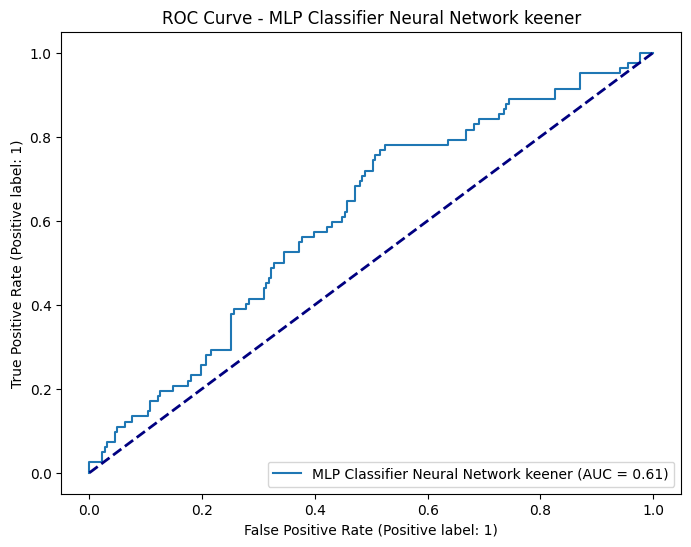

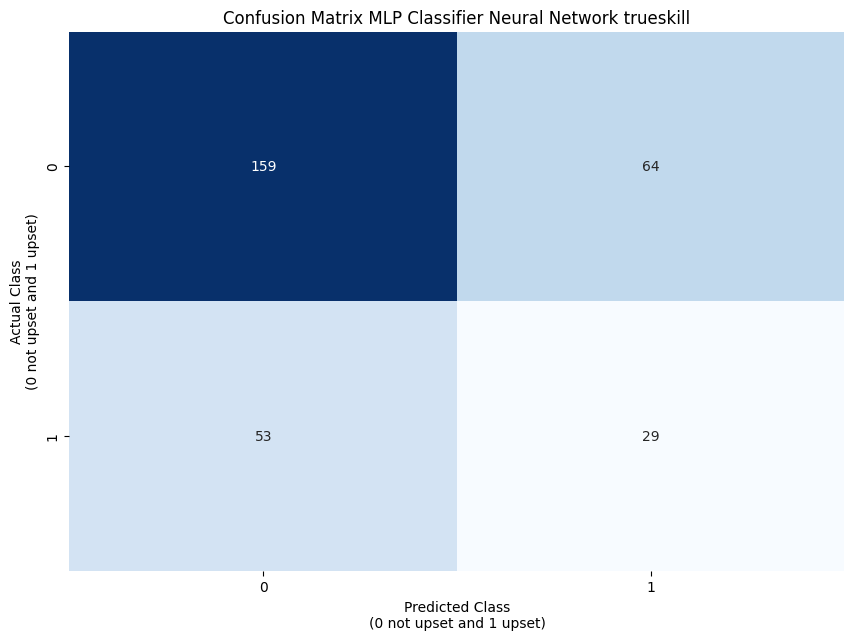

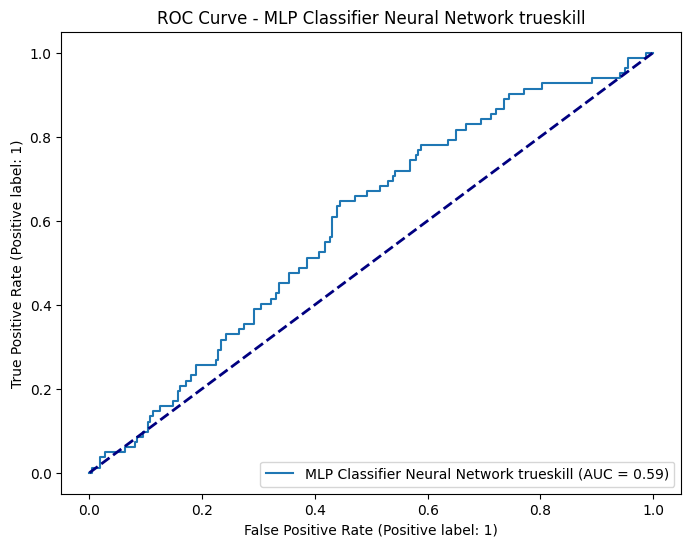

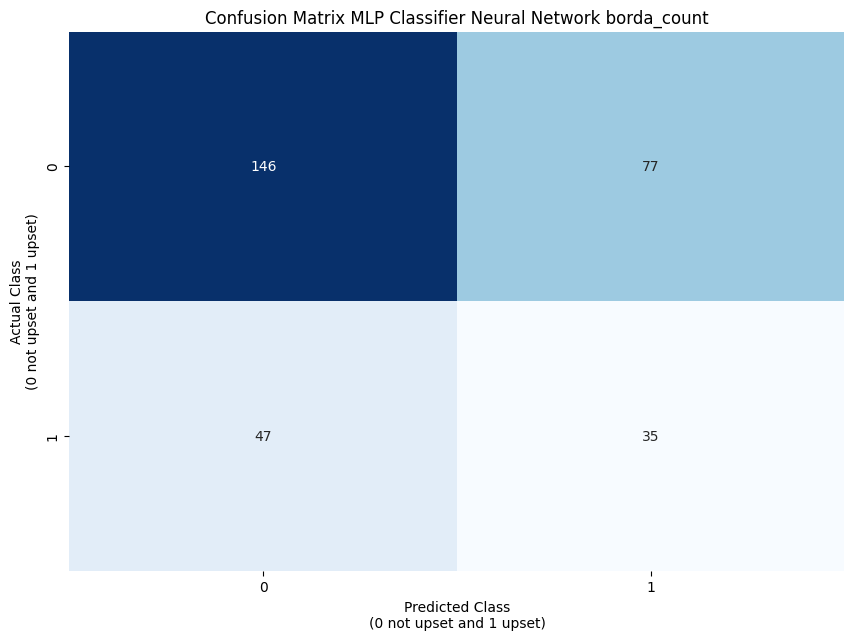

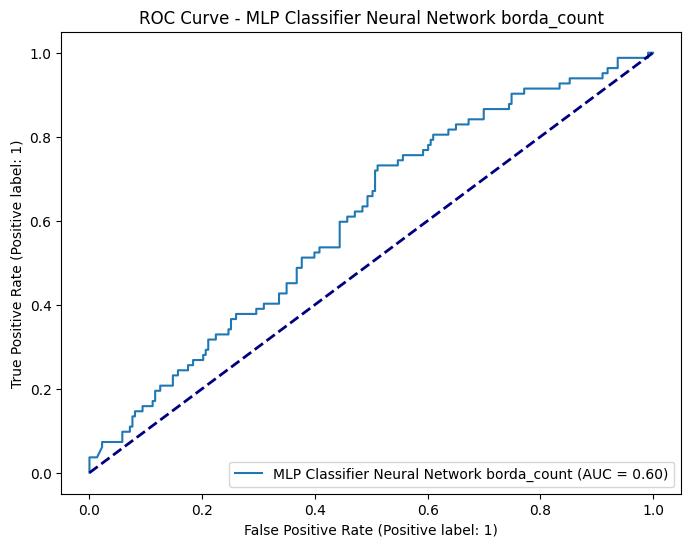

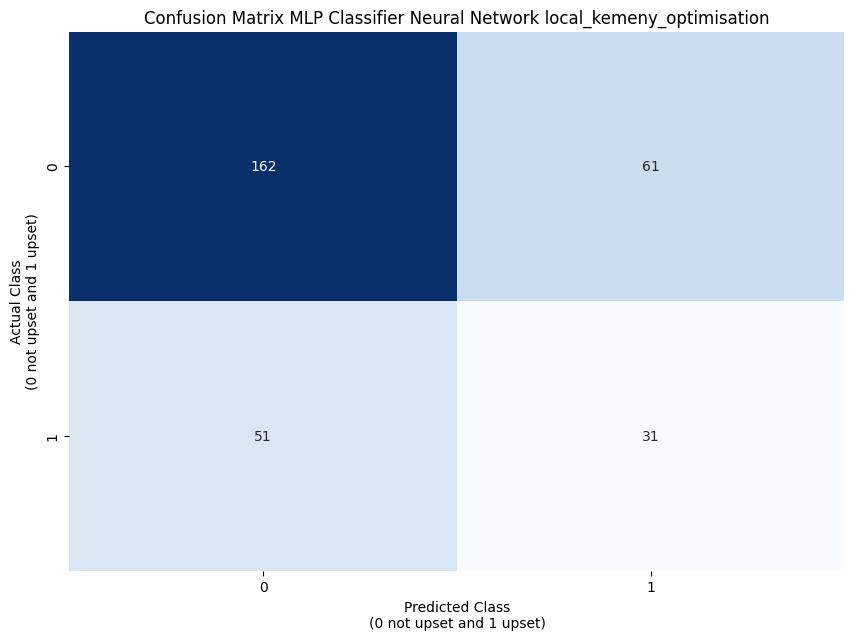

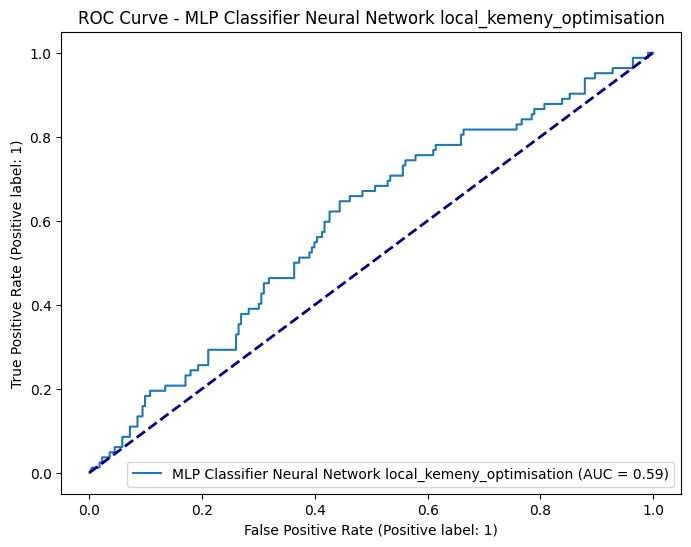

In [13]:
# MCP Neural Network
model_name = "MLP Classifier Neural Network"
home_advt = 'no'
weighted = 'no'
max_iter = 10000
random_state = 47
model_classifier  = MLPClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__max_iter': [max_iter],
    'classifier__random_state': [random_state],
    'classifier__hidden_layer_sizes': [(10,10,10), (20,20,), (10,)],
    'classifier__activation': ['logistic', 'tanh', 'relu'],
    'classifier__learning_rate_init': [0.001, 0.01, 0.1],
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_nn = all_results_df
display(all_results_df_nn)

fold_results_df_nn = fold_results_df
display(fold_results_df_nn)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_nn.to_excel("all_nn_results.xlsx")
fold_results_df_nn.to_excel("fold_results_nn.xlsx")

MLP Classifier Neural Network with home advantage no_ranking
Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.394
Fold 1 Accuracy: 0.639
Fold 1 Recall: 0.250
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.591
Fold 2 Accuracy: 0.410
Fold 2 Recall: 0.500
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.001, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.318
Fold 3 Accuracy: 0.754
Fold 3 Recall: 0.188
Best parameters: {'classifier__activation': 'relu

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.555
Fold 4 Accuracy: 0.639
Fold 4 Recall: 0.529
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.001, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.539
Fold 5 Accuracy: 0.672
Fold 5 Recall: 0.353
Average Accuracy: 0.689
Average Recall: 0.426
MLP Classifier Neural Network with home advantage colley
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.001, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.379
Fold 1 Accuracy: 0.820
Fold 1 Recall: 0.375
Be

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.001, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.523
Fold 5 Accuracy: 0.770
Fold 5 Recall: 0.412
Average Accuracy: 0.705
Average Recall: 0.345
MLP Classifier Neural Network with home advantage trueskill
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.515
Fold 1 Accuracy: 0.738
Fold 1 Recall: 0.312
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.591
Fold 2 Accuracy: 0.738
Fold 2 Recall: 0.250

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.001, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.379
Fold 3 Accuracy: 0.754
Fold 3 Recall: 0.438
Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (10,), 'classifier__learning_rate_init': 0.01, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.506
Fold 4 Accuracy: 0.721
Fold 4 Recall: 0.412
Best parameters: {'classifier__activation': 'tanh', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__learning_rate_init': 0.001, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.492
Fold 5 Accuracy: 0.590
Fold 5 Recall: 0.176
Average Accuracy: 0.689
Average Recall: 0.268
MLP Classifier Neural Network with home advantage local_kemeny_optimi

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__activation': 'logistic', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.621
Fold 2 Accuracy: 0.754
Fold 2 Recall: 0.562
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.424
Fold 3 Accuracy: 0.787
Fold 3 Recall: 0.438
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (20, 20), 'classifier__learning_rate_init': 0.1, 'classifier__max_iter': 10000, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.520
Fold 4 Accuracy: 0.689
Fold 4 Recall: 0.294
Best parameters: {'classifier__activation': 'relu', 'classifier__hidden_layer_sizes': (10, 10, 10), 'classifier__lear

metric_id                                        metric  \
0           1                Cross-validation Accuracy Mean   
1           2  Cross-validation Accuracy Standard Deviation   
2           3                  Cross-validation Recall Mean   
3           4    Cross-validation Recall Standard Deviation   
4           5                              Overall Accuracy   
5           6    Confusion Matrix - True Negative (Class 0)   
6           7   Confusion Matrix - False Positive (Class 1)   
7           8   Confusion Matrix - False Negative (Class 0)   
8           9    Confusion Matrix - True Positive (Class 1)   
9          10                           Precision (Class 0)   
10         11                              Recall (Class 0)   
11         12                            F1-score (Class 0)   
12         13                           Precision (Class 1)   
13         14                              Recall (Class 1)   
14         15                            F1-score (Class 1)   
15         16                           Macro avg Precision   
16         17                              Macro avg Recall   
17         18                            Macro avg F1-score   
18         19                        Weighted avg Precision   
19         20                           Weighted avg Recall   
20         21                         Weighted avg F1-score   
21         22                                       AUC-ROC   

   MLP Classifier Neural Network with home advantage no_ranking  \
0                                               0.584             
1                                               0.113             
2                                               0.364             
3                                               0.207             
4                                               0.584             
5                                             148.000             
6                                              75.000             
7                                              52.000             
8                                              30.000             
9                                               0.740             
10                                              0.664             
11                                              0.700             
12                                              0.286             
13                                              0.366             
14                                              0.321             
15                                              0.513             
16                                              0.515             
17                                              0.510             
18                                              0.618             
19                                              0.584             
20                                              0.598             
21                                              0.565             

   MLP Classifier Neural Network with home advantage round_3_position  \
0                                               0.600                   
1                                               0.061                   
2                                               0.430                   
3                                               0.224                   
4                                               0.600                   
5                                             148.000                   
6                                              75.000                   
7                                              47.000                   
8                                              35.000                   
9                                               0.759                   
10                                              0.664                   
11                                              0.708                   
12                                              0.318          

Model Name Ranking  Fold  \
0   MLP Classifier Neural Network with home advant...     1   
1   MLP Classifier Neural Network with home advant...     2   
2   MLP Classifier Neural Network with home advant...     3   
3   MLP Classifier Neural Network with home advant...     4   
4   MLP Classifier Neural Network with home advant...     5   
5   MLP Classifier Neural Network with home advant...     1   
6   MLP Classifier Neural Network with home advant...     2   
7   MLP Classifier Neural Network with home advant...     3   
8   MLP Classifier Neural Network with home advant...     4   
9   MLP Classifier Neural Network with home advant...     5   
10  MLP Classifier Neural Network with home advant...     1   
11  MLP Classifier Neural Network with home advant...     2   
12  MLP Classifier Neural Network with home advant...     3   
13  MLP Classifier Neural Network with home advant...     4   
14  MLP Classifier Neural Network with home advant...     5   
15  MLP Classifier Neural Network with home advant...     1   
16  MLP Classifier Neural Network with home advant...     2   
17  MLP Classifier Neural Network with home advant...     3   
18  MLP Classifier Neural Network with home advant...     4   
19  MLP Classifier Neural Network with home advant...     5   
20  MLP Classifier Neural Network with home advant...     1   
21  MLP Classifier Neural Network with home advant...     2   
22  MLP Classifier Neural Network with home advant...     3   
23  MLP Classifier Neural Network with home advant...     4   
24  MLP Classifier Neural Network with home advant...     5   
25  MLP Classifier Neural Network with home advant...     1   
26  MLP Classifier Neural Network with home advant...     2   
27  MLP Classifier Neural Network with home advant...     3   
28  MLP Classifier Neural Network with home advant...     4   
29  MLP Classifier Neural Network with home advant...     5   
30  MLP Classifier Neural Network with home advant...     1   
31  MLP Classifier Neural Network with home advant...     2   
32  MLP Classifier Neural Network with home advant...     3   
33  MLP Classifier Neural Network with home advant...     4   
34  MLP Classifier Neural Network with home advant...     5   
35  MLP Classifier Neural Network with home advant...     1   
36  MLP Classifier Neural Network with home advant...     2   
37  MLP Classifier Neural Network with home advant...     3   
38  MLP Classifier Neural Network with home advant...     4   
39  MLP Classifier Neural Network with home advant...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__activation': 'logistic', 'classi...   
1   {'classifier__activation': 'relu', 'classifier...   
2   {'classifier__activation': 'relu', 'classifier...   
3   {'classifier__activation': 'relu', 'classifier...   
4   {'classifier__activation': 'relu', 'classifier...   
5   {'classifier__activation': 'relu', 'classifier...   
6   {'classifier__activation': 'logistic', 'classi...   
7   {'classifier__activation': 'relu', 'classifier...   
8   {'classifier__activation': 'logistic', 'classi...   
9   {'classifier__activation': 'relu', 'classifier...   
10  {'classifier__activation': 'relu', 'classifier...   
11  {'classifier__activation': 'relu', 'classifier...   
12  {'classifier__activation': 'relu', 'classifier...   
13  {'classifier__activation': 'logistic', 'classi...   
14  {'classifier__activation': 'relu', 'classifier...   
15  {'classifier__activation': 'relu', 'classifier...   
16  {'classifier__activation': 'relu', 'classifier...   
17  {'classifier__activation': 'relu', 'classifier...   
18  {'classifier__activation': 'relu', 'classifier...   
19  {'classifier__activation': 'relu', 'classifier...   
20  {'classifier__activation': 'relu', 'classifier...   
21  {'classifier__activation': 'relu', 'classifier...   
22  {'classifier__activation': 'relu', 'classifier...   
23  {'classifier__activation': 'relu', 'classifier...   
24  {'classifier__activati

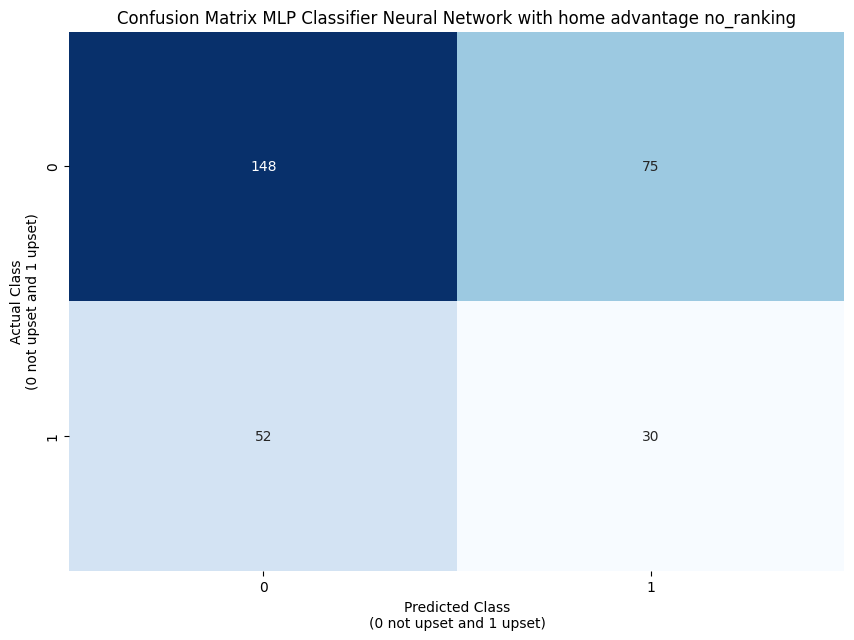

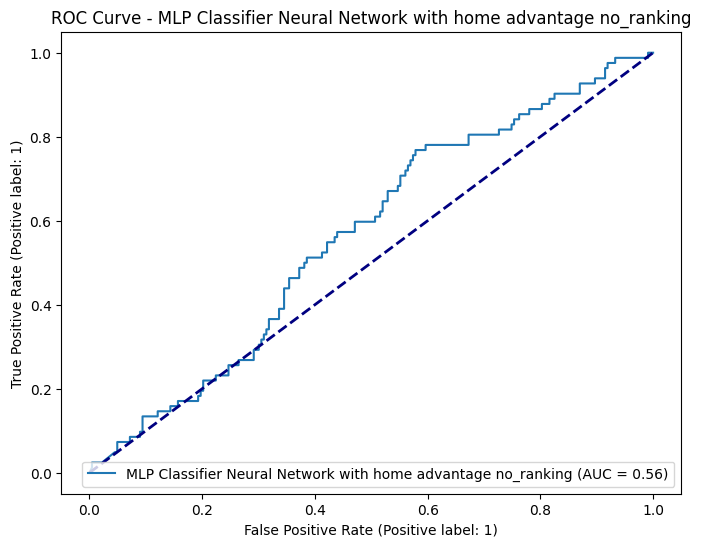

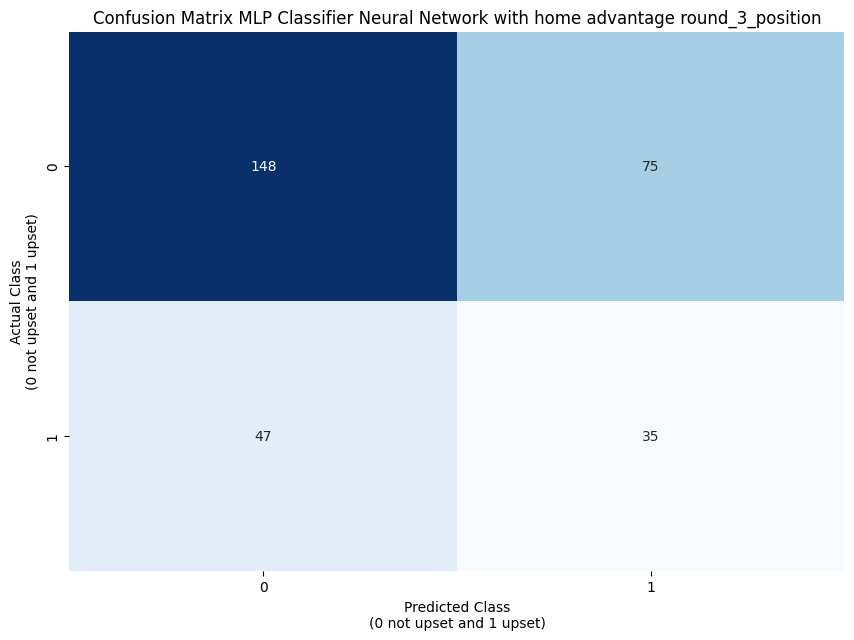

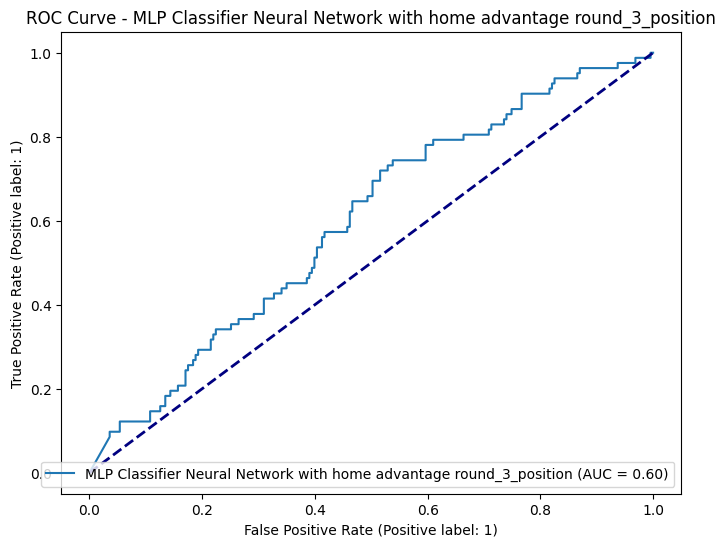

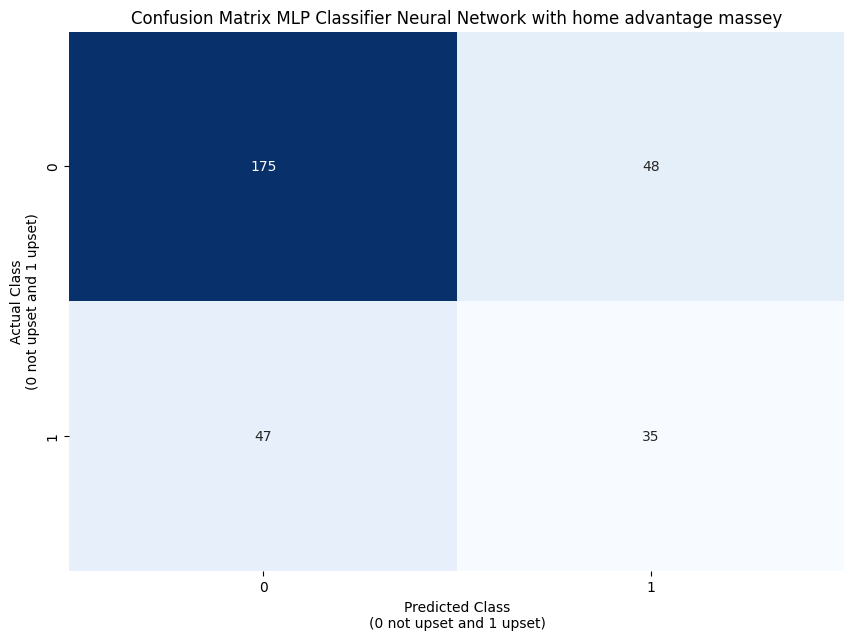

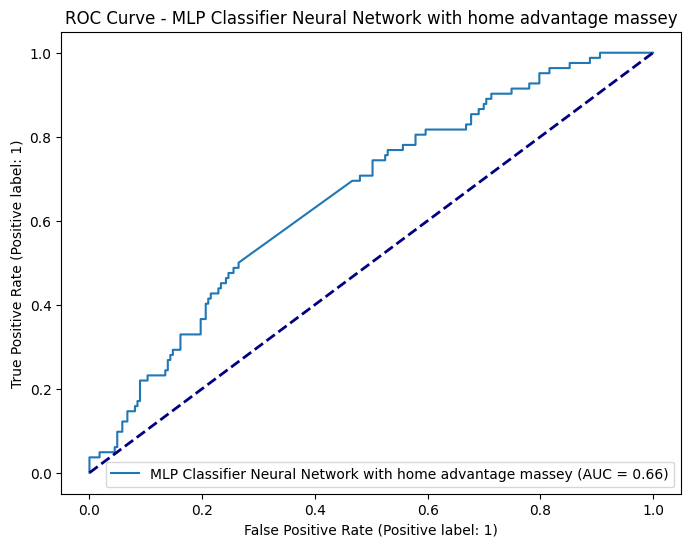

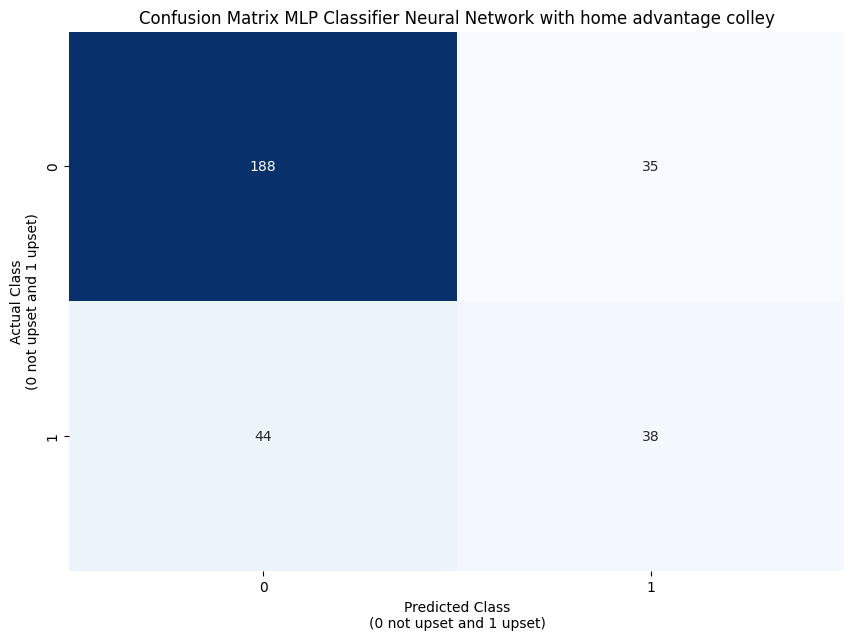

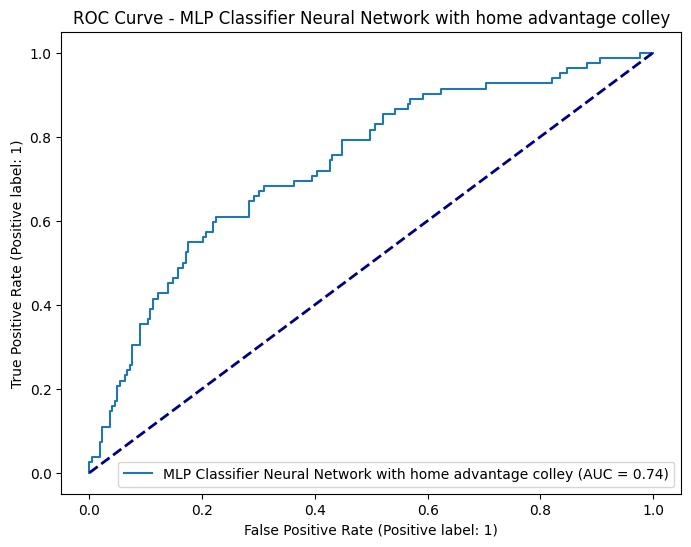

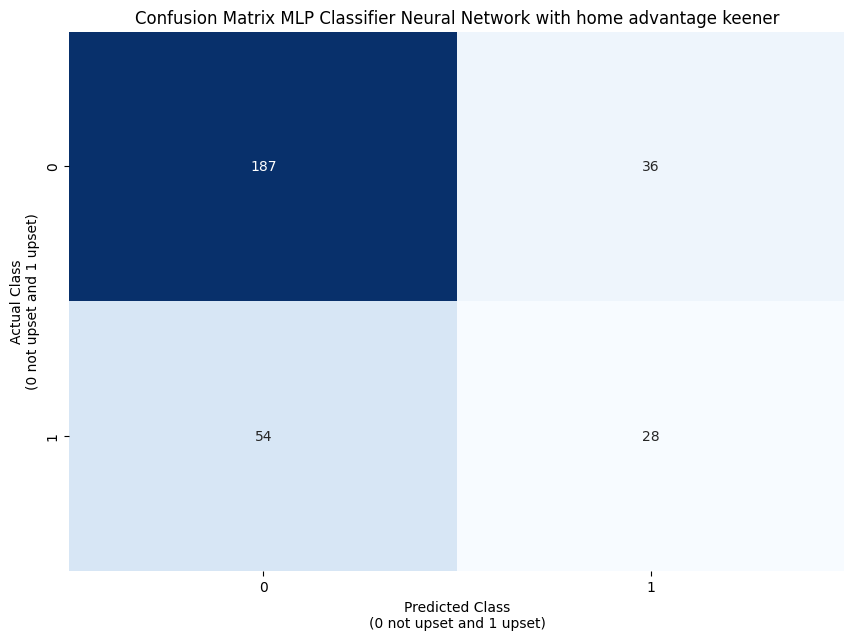

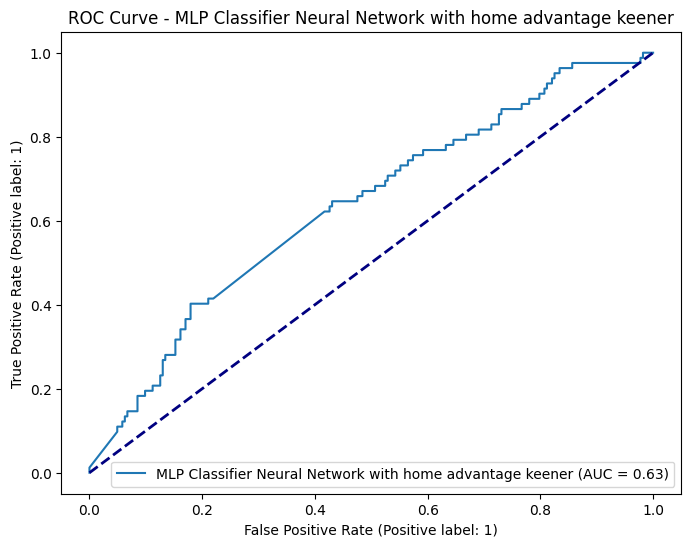

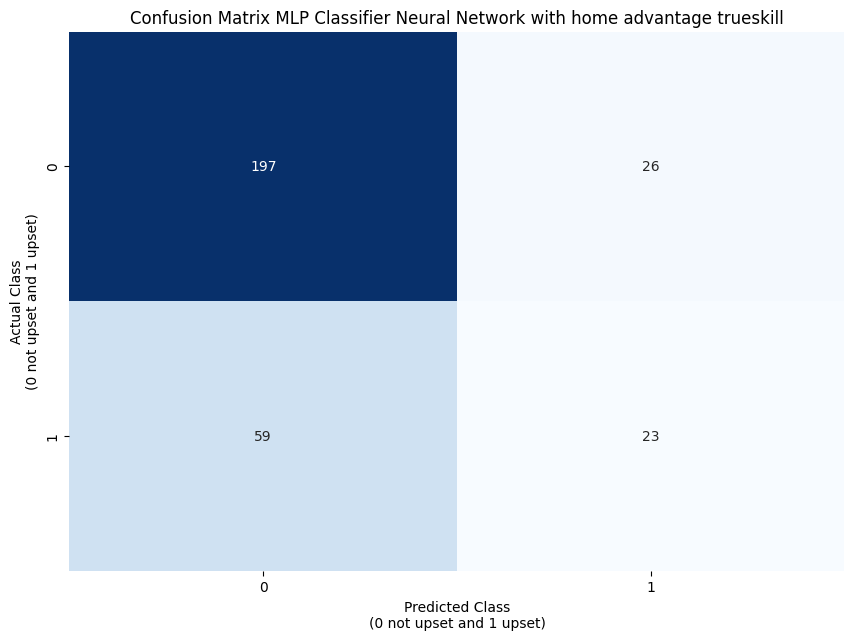

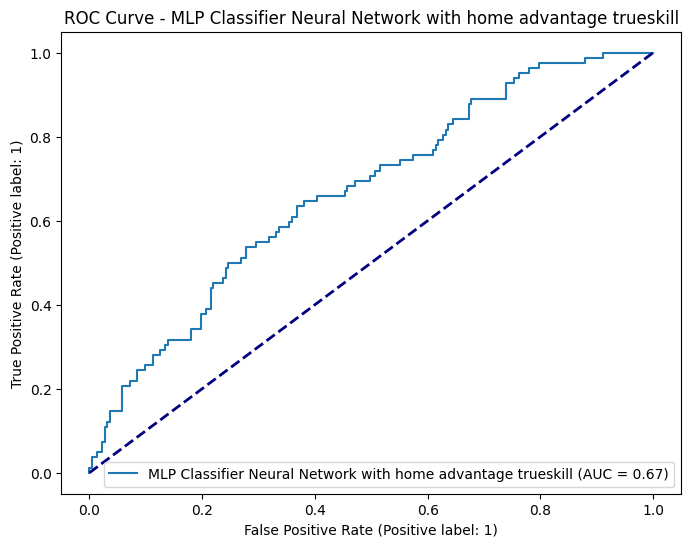

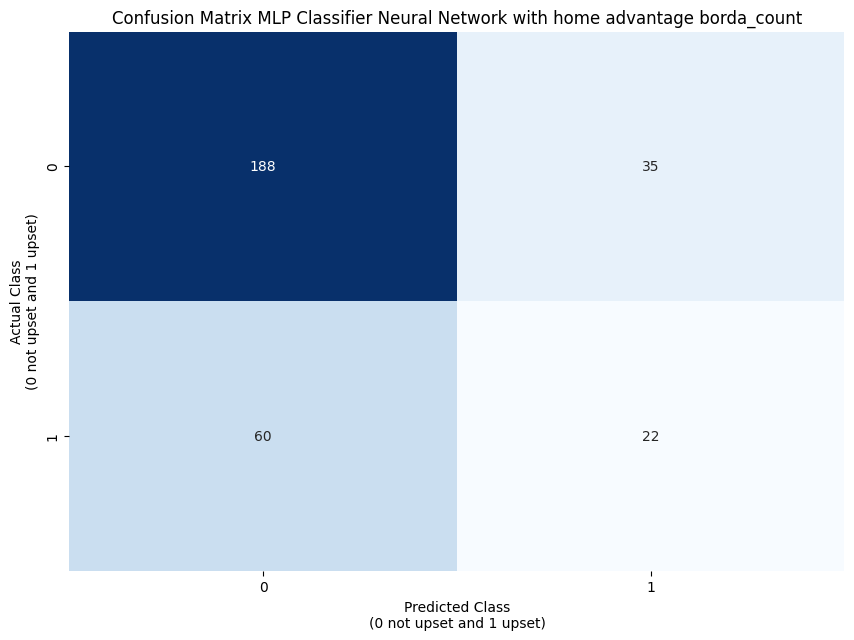

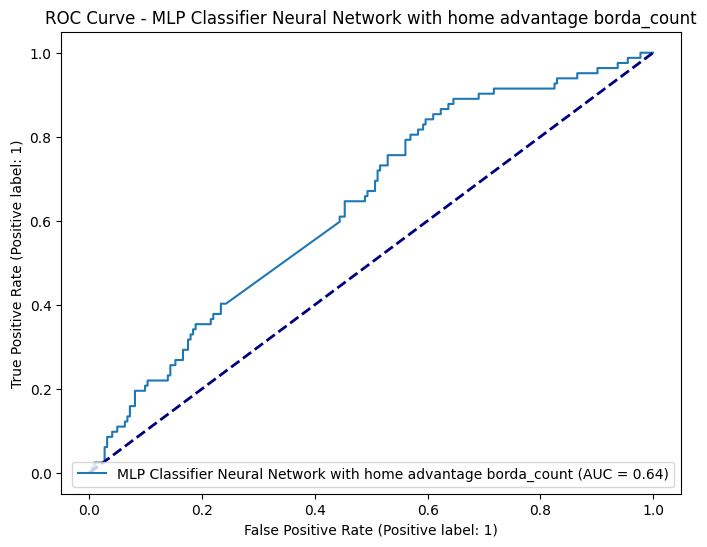

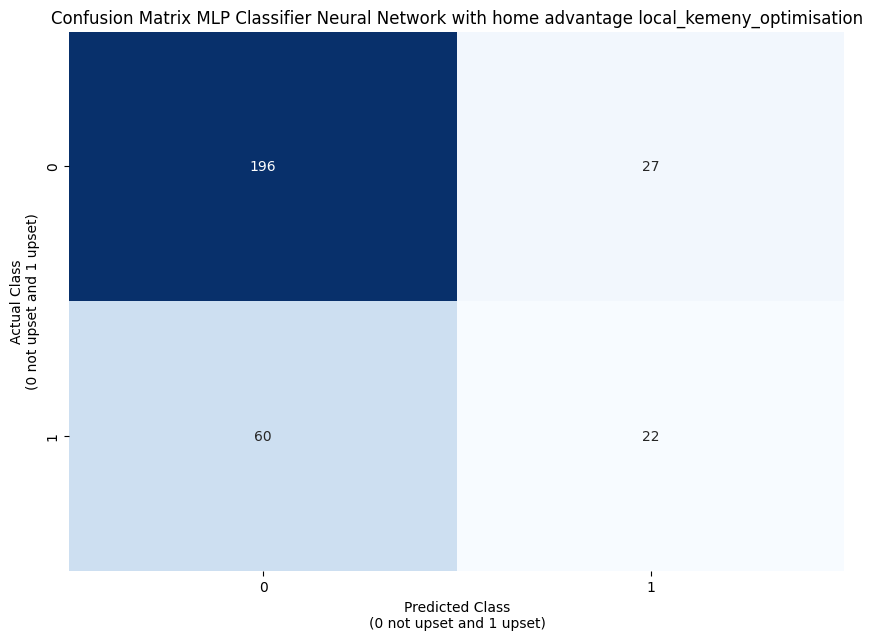

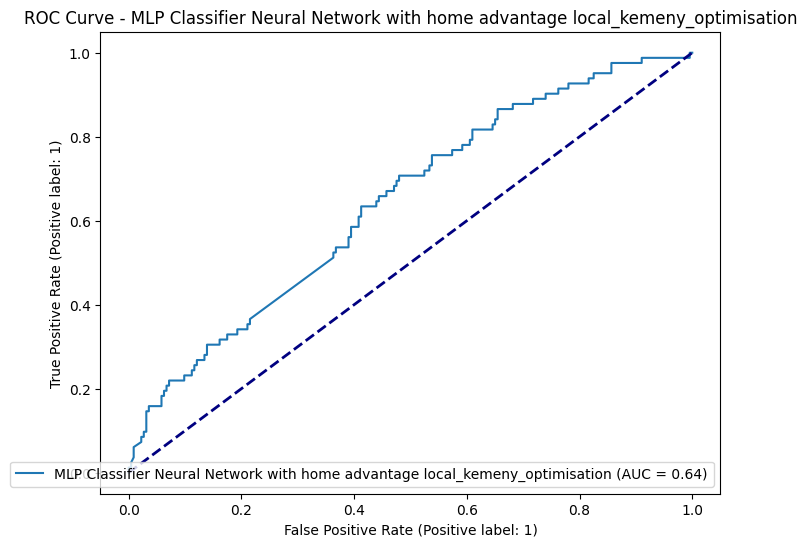

In [14]:
# MCP Neural Network with home advantage
model_name = "MLP Classifier Neural Network with home advantage"
home_advt = 'yes'
weighted = 'no'
max_iter = 10000
random_state = 47
model_classifier  = MLPClassifier()

# Define the parameter grid for GridSearchCV
param_grid = {
    'classifier__max_iter': [max_iter],
    'classifier__random_state': [random_state],
    'classifier__hidden_layer_sizes': [(10,10,10), (20,20,), (10,)],
    'classifier__activation': ['logistic', 'tanh', 'relu'],
    'classifier__learning_rate_init': [0.001, 0.01, 0.1],
  }

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_nnh = all_results_df
display(all_results_df_nnh)

fold_results_df_nnh = fold_results_df
display(fold_results_df_nnh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_nnh.to_excel("all_nnh_results.xlsx")
fold_results_df_nnh.to_excel("fold_results_nnh.xlsx")

Random Forest Classifier no_ranking
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 50, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.424
Fold 1 Accuracy: 0.754
Fold 1 Recall: 0.188
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 50, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.409
Fold 2 Accuracy: 0.754
Fold 2 Recall: 0.438
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 50, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.364
Fold 3 Accuracy: 0.754
Fold 3 Recall: 0.250
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 50, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.365
Fold 4 Accuracy: 0.754
F

metric_id                                        metric  \
0           1                Cross-validation Accuracy Mean   
1           2  Cross-validation Accuracy Standard Deviation   
2           3                  Cross-validation Recall Mean   
3           4    Cross-validation Recall Standard Deviation   
4           5                              Overall Accuracy   
5           6    Confusion Matrix - True Negative (Class 0)   
6           7   Confusion Matrix - False Positive (Class 1)   
7           8   Confusion Matrix - False Negative (Class 0)   
8           9    Confusion Matrix - True Positive (Class 1)   
9          10                           Precision (Class 0)   
10         11                              Recall (Class 0)   
11         12                            F1-score (Class 0)   
12         13                           Precision (Class 1)   
13         14                              Recall (Class 1)   
14         15                            F1-score (Class 1)   
15         16                           Macro avg Precision   
16         17                              Macro avg Recall   
17         18                            Macro avg F1-score   
18         19                        Weighted avg Precision   
19         20                           Weighted avg Recall   
20         21                         Weighted avg F1-score   
21         22                                       AUC-ROC   

   Random Forest Classifier no_ranking  \
0                                0.748   
1                                0.013   
2                                0.234   
3                                0.110   
4                                0.748   
5                              209.000   
6                               14.000   
7                               63.000   
8                               19.000   
9                                0.768   
10                               0.937   
11                               0.844   
12                               0.576   
13                               0.232   
14                               0.330   
15                               0.672   
16                               0.584   
17                               0.587   
18                               0.717   
19                               0.748   
20                               0.706   
21                               0.709   

   Random Forest Classifier round_3_position Random Forest Classifier massey  \
0                                      0.751                           0.738   
1                                      0.026                           0.046   
2                                      0.211                           0.174   
3                                      0.136                           0.123   
4                                      0.751                           0.738   
5                                    212.000                         211.000   
6                                     11.000                          12.000   
7                                     65.000                          68.000   
8                                     17.000                          14.000   
9                                      0.765                           0.756   
10                                     0.951                           0.946   
11                                     0.848                           0.841   
12                                     0.607                           0.538   
13                                     0.207                           0.171   
14                                     0.309                           0.259   
15                                     0.686                           0.647   
16                                     0.579                           0.558   
17                                     0.579                           0.550   
18                                     0.723                       

Model Name Ranking  Fold  \
0                 Random Forest Classifier no_ranking     1   
1                 Random Forest Classifier no_ranking     2   
2                 Random Forest Classifier no_ranking     3   
3                 Random Forest Classifier no_ranking     4   
4                 Random Forest Classifier no_ranking     5   
5           Random Forest Classifier round_3_position     1   
6           Random Forest Classifier round_3_position     2   
7           Random Forest Classifier round_3_position     3   
8           Random Forest Classifier round_3_position     4   
9           Random Forest Classifier round_3_position     5   
10                    Random Forest Classifier massey     1   
11                    Random Forest Classifier massey     2   
12                    Random Forest Classifier massey     3   
13                    Random Forest Classifier massey     4   
14                    Random Forest Classifier massey     5   
15                    Random Forest Classifier colley     1   
16                    Random Forest Classifier colley     2   
17                    Random Forest Classifier colley     3   
18                    Random Forest Classifier colley     4   
19                    Random Forest Classifier colley     5   
20                    Random Forest Classifier keener     1   
21                    Random Forest Classifier keener     2   
22                    Random Forest Classifier keener     3   
23                    Random Forest Classifier keener     4   
24                    Random Forest Classifier keener     5   
25                 Random Forest Classifier trueskill     1   
26                 Random Forest Classifier trueskill     2   
27                 Random Forest Classifier trueskill     3   
28                 Random Forest Classifier trueskill     4   
29                 Random Forest Classifier trueskill     5   
30               Random Forest Classifier borda_count     1   
31               Random Forest Classifier borda_count     2   
32               Random Forest Classifier borda_count     3   
33               Random Forest Classifier borda_count     4   
34               Random Forest Classifier borda_count     5   
35  Random Forest Classifier local_kemeny_optimisa...     1   
36  Random Forest Classifier local_kemeny_optimisa...     2   
37  Random Forest Classifier local_kemeny_optimisa...     3   
38  Random Forest Classifier local_kemeny_optimisa...     4   
39  Random Forest Classifier local_kemeny_optimisa...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__max_features': None, 'classifier...   
1   {'classifier__max_features': None, 'classifier...   
2   {'classifier__max_features': None, 'classifier...   
3   {'classifier__max_features': None, 'classifier...   
4   {'classifier__max_features': None, 'classifier...   
5   {'classifier__max_features': None, 'classifier...   
6   {'classifier__max_features': None, 'classifier...   
7   {'classifier__max_features': None, 'classifier...   
8   {'classifier__max_features': None, 'classifier...   
9   {'classifier__max_features': None, 'classifier...   
10  {'classifier__max_features': None, 'classifier...   
11  {'classifier__max_features': None, 'classifier...   
12  {'classifier__max_features': None, 'classifier...   
13  {'classifier__max_features': None, 'classifier...   
14  {'classifier__max_features': None, 'classifier...   
15  {'classifier__max_features': None, 'classifier...   
16  {'classifier__max_features': None, 'classifier...   
17  {'classifier__max_features': None, 'classifier...   
18  {'classifier__max_features': None, 'classifier...   
19  {'classifier__max_features': None, 'classifier...   
20  {'classifier__max_features': None, 'classifier...   
21  {'classifier__max_features': None, 'classifier...   
22  {'classifier__max_features': None, 'classifier...   
23  {'classifier__max_features': None, 'classifier...   
24  {'classifier__max_feat

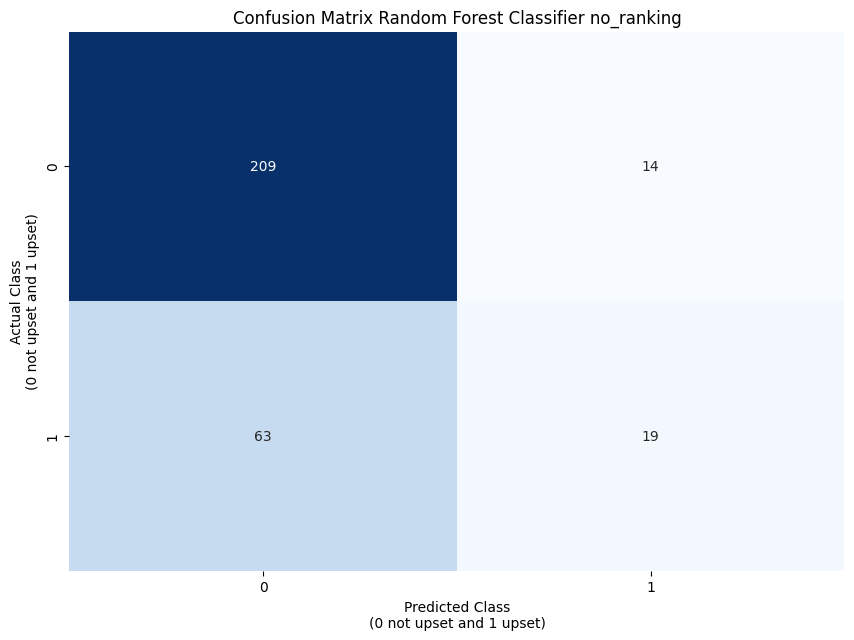

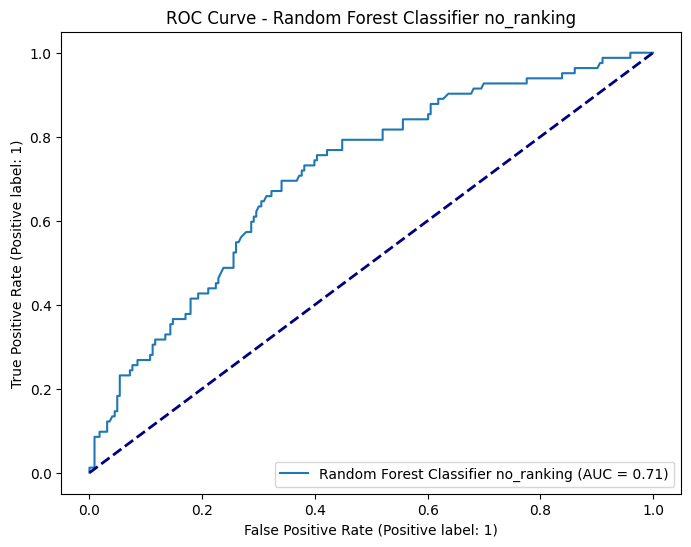

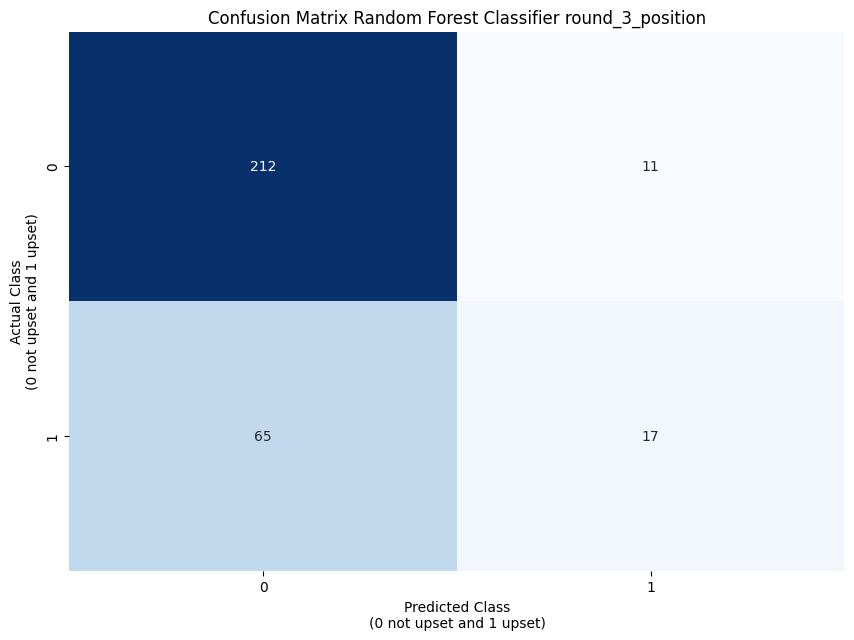

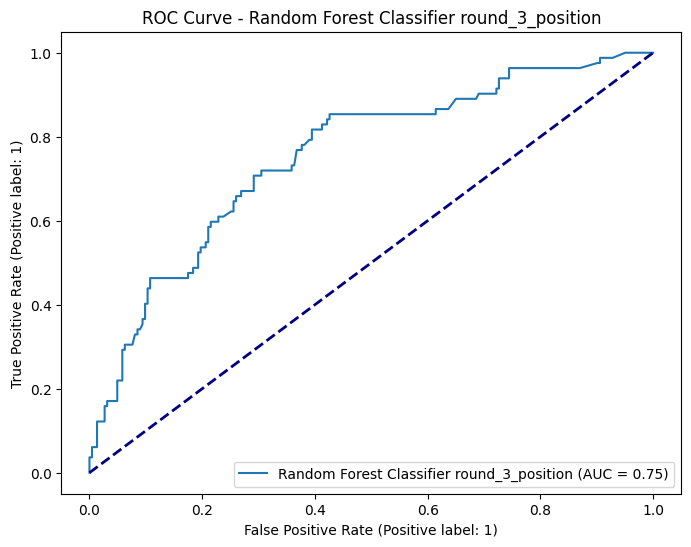

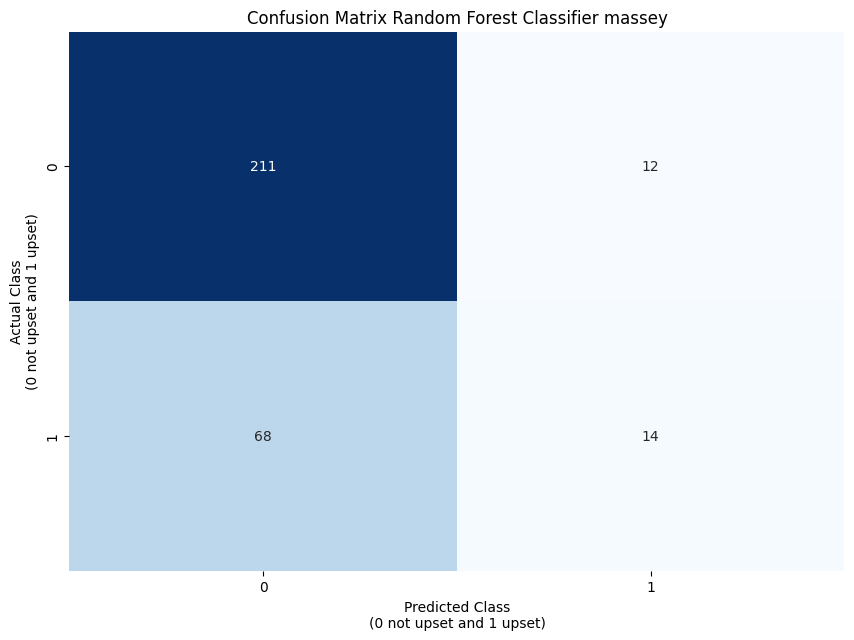

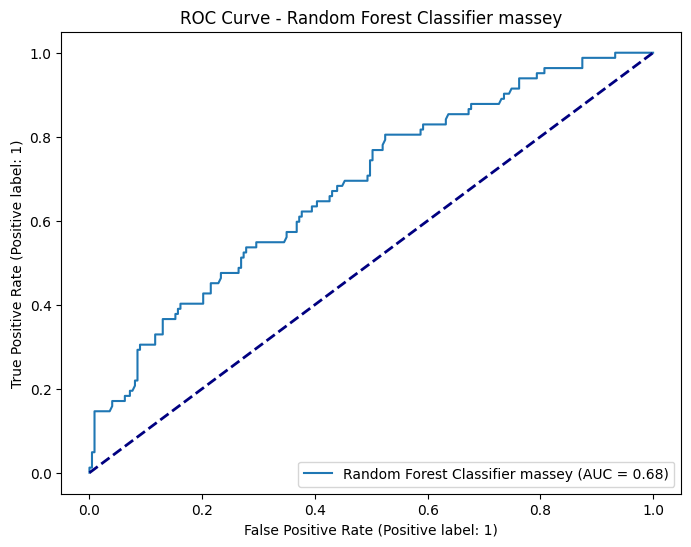

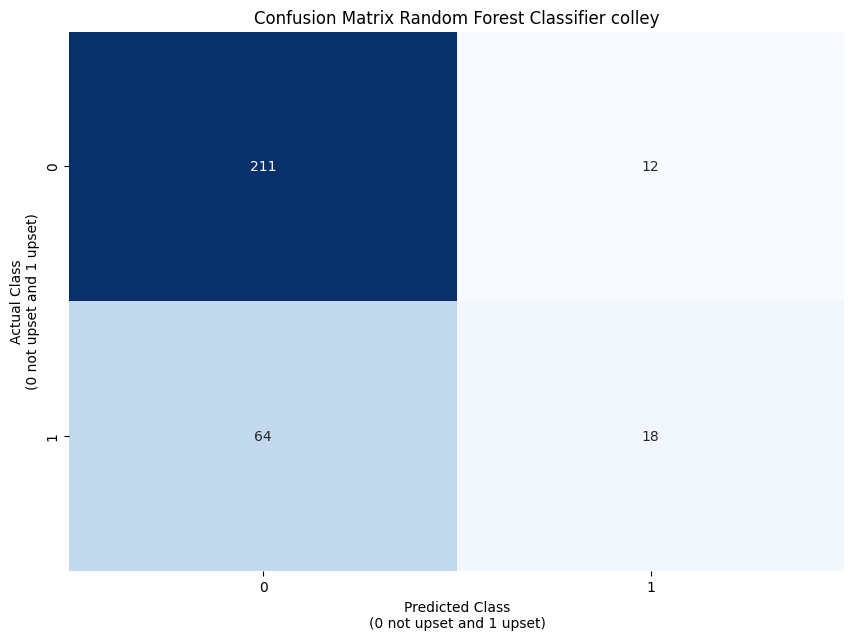

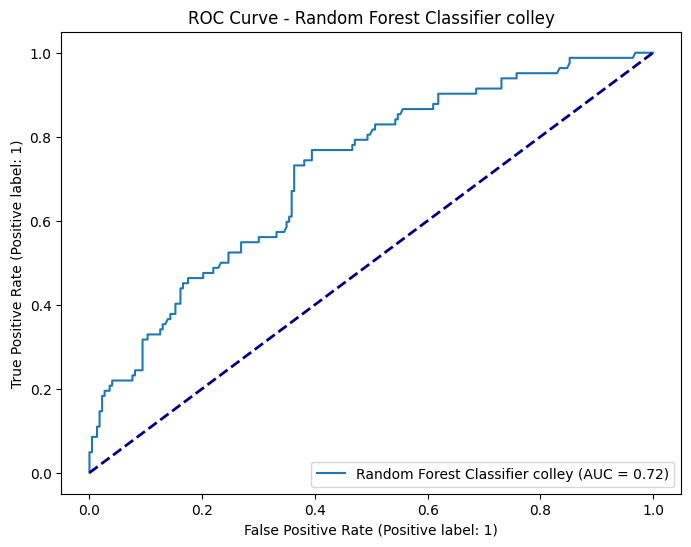

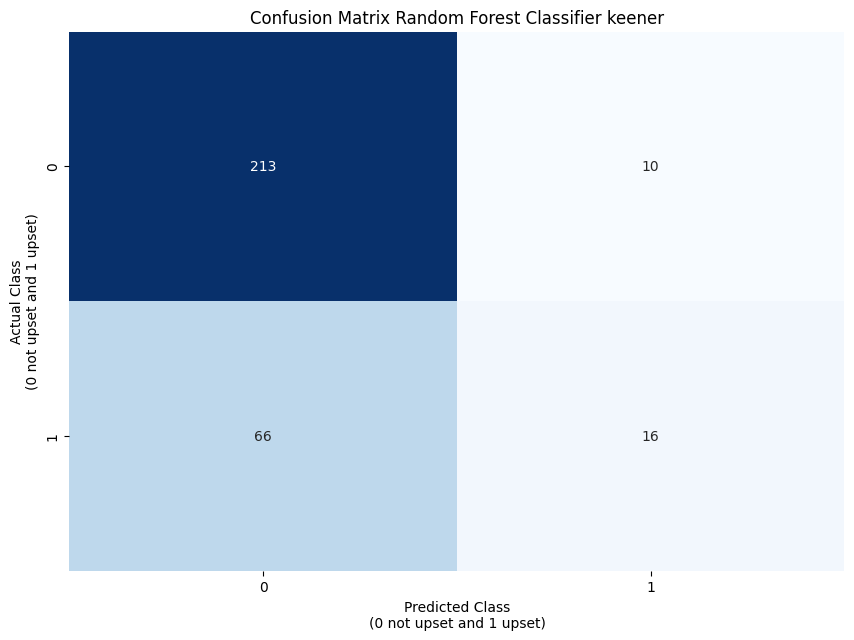

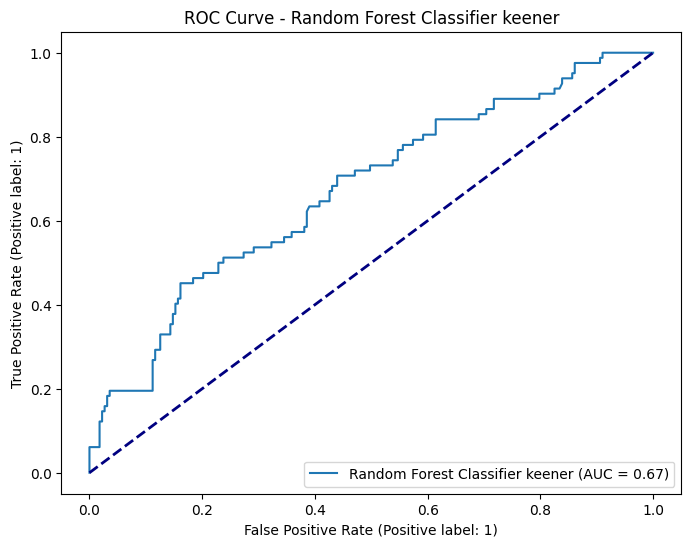

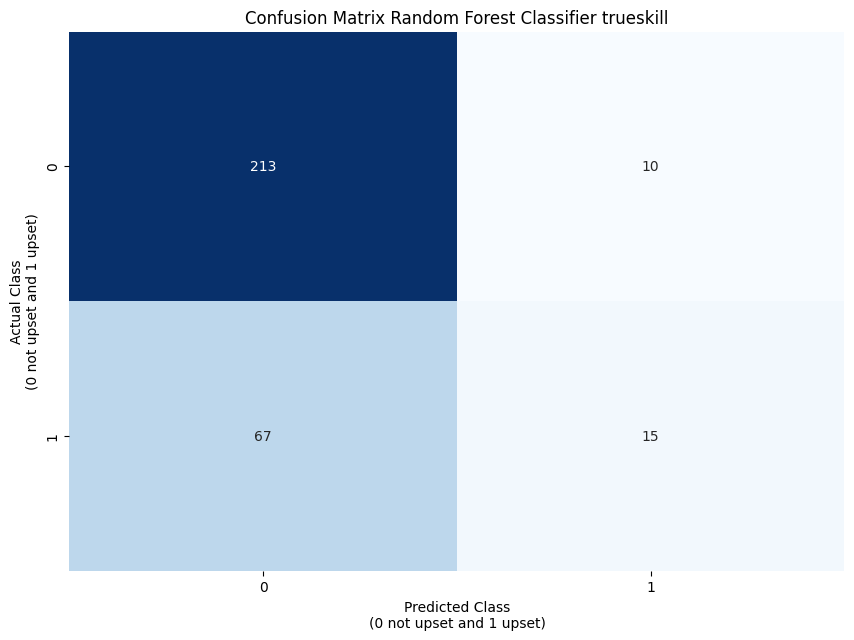

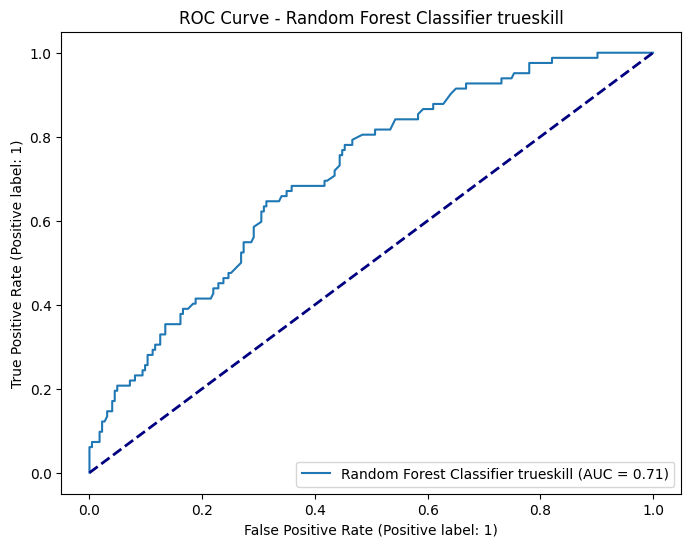

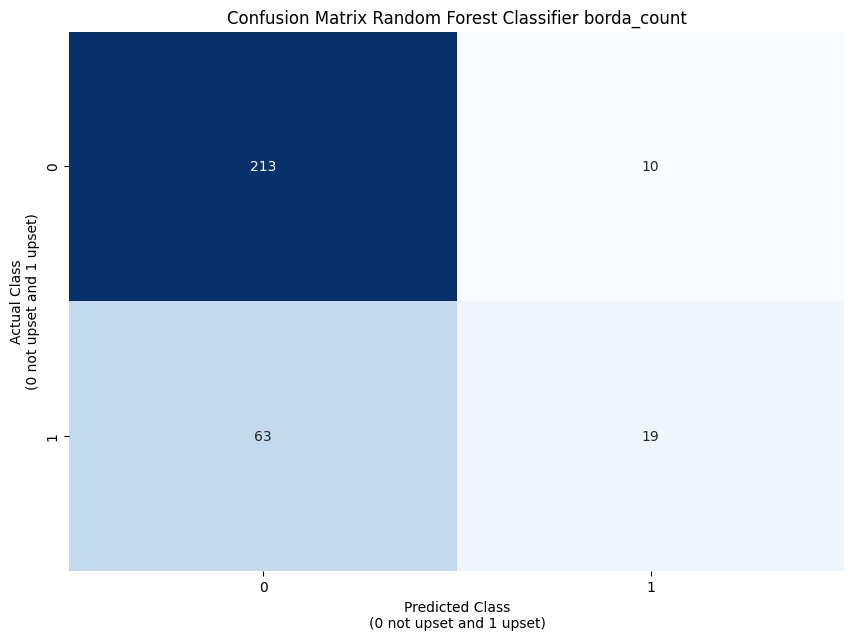

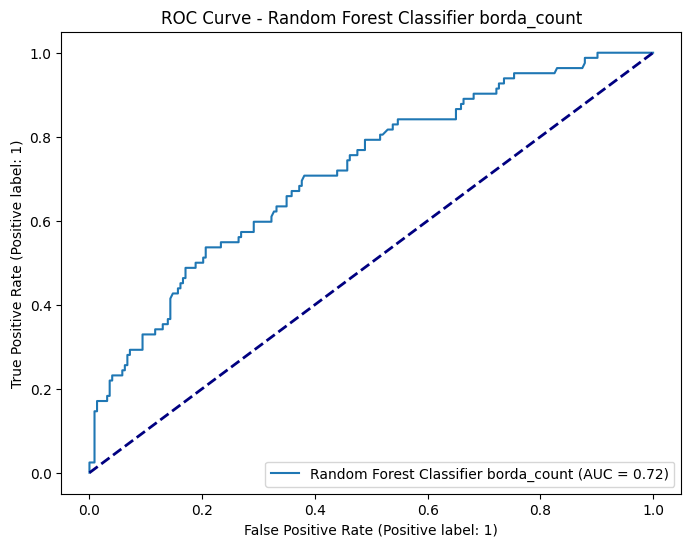

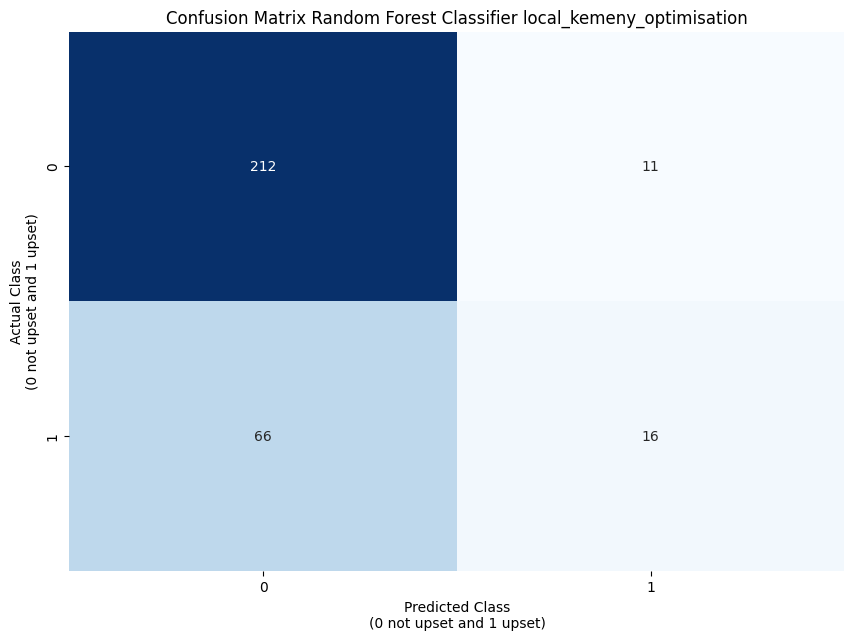

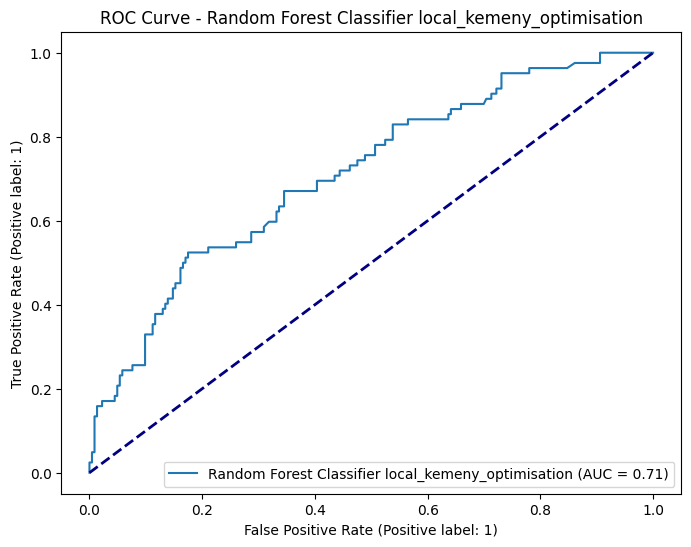

In [15]:
# Random Forest Classifier
model_name = "Random Forest Classifier"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = RandomForestClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': [ None, 'sqrt']
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_rf = all_results_df
display(all_results_df_rf)

fold_results_df_rf = fold_results_df
display(fold_results_df_rf)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_rf.to_excel("all_rf_results.xlsx")
fold_results_df_rf.to_excel("fold_results_rf.xlsx")


Random Forest Classifier with home advantage no_ranking
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 50, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.439
Fold 1 Accuracy: 0.770
Fold 1 Recall: 0.125
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 50, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.424
Fold 2 Accuracy: 0.738
Fold 2 Recall: 0.438
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 100, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.364
Fold 3 Accuracy: 0.770
Fold 3 Recall: 0.125
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 50, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.365
Fol

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 200, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.439
Fold 1 Accuracy: 0.754
Fold 1 Recall: 0.062
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 2, 'classifier__n_estimators': 200, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.394
Fold 2 Accuracy: 0.738
Fold 2 Recall: 0.438
Best parameters: {'classifier__max_features': 'sqrt', 'classifier__min_samples_leaf': 1, 'classifier__n_estimators': 100, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.455
Fold 3 Accuracy: 0.803
Fold 3 Recall: 0.250
Best parameters: {'classifier__max_features': None, 'classifier__min_samples_leaf': 4, 'classifier__n_estimators': 50, 'classifier__random_state': 47}
Best Estimator's Recall (from GridSearchCV): 0.397
Fold 4 Accuracy: 0.705
Fold 4 Recall: 0.176
Best parame

metric_id                                        metric  \
0           1                Cross-validation Accuracy Mean   
1           2  Cross-validation Accuracy Standard Deviation   
2           3                  Cross-validation Recall Mean   
3           4    Cross-validation Recall Standard Deviation   
4           5                              Overall Accuracy   
5           6    Confusion Matrix - True Negative (Class 0)   
6           7   Confusion Matrix - False Positive (Class 1)   
7           8   Confusion Matrix - False Negative (Class 0)   
8           9    Confusion Matrix - True Positive (Class 1)   
9          10                           Precision (Class 0)   
10         11                              Recall (Class 0)   
11         12                            F1-score (Class 0)   
12         13                           Precision (Class 1)   
13         14                              Recall (Class 1)   
14         15                            F1-score (Class 1)   
15         16                           Macro avg Precision   
16         17                              Macro avg Recall   
17         18                            Macro avg F1-score   
18         19                        Weighted avg Precision   
19         20                           Weighted avg Recall   
20         21                         Weighted avg F1-score   
21         22                                       AUC-ROC   

   Random Forest Classifier with home advantage no_ranking  \
0                                               0.754        
1                                               0.015        
2                                               0.232        
3                                               0.120        
4                                               0.754        
5                                             211.000        
6                                              12.000        
7                                              63.000        
8                                              19.000        
9                                               0.770        
10                                              0.946        
11                                              0.849        
12                                              0.613        
13                                              0.232        
14                                              0.336        
15                                              0.691        
16                                              0.589        
17                                              0.593        
18                                              0.728        
19                                              0.754        
20                                              0.711        
21                                              0.729        

   Random Forest Classifier with home advantage round_3_position  \
0                                               0.744              
1                                               0.022              
2                                               0.137              
3                                               0.128              
4                                               0.744              
5                                             216.000              
6                                               7.000              
7                                              71.000              
8                                              11.000              
9                                               0.753              
10                                              0.969              
11                                              0.847              
12                                              0.611              
13                                              0.134              
14                                              0.220              
15                                     

Model Name Ranking  Fold  \
0   Random Forest Classifier with home advantage n...     1   
1   Random Forest Classifier with home advantage n...     2   
2   Random Forest Classifier with home advantage n...     3   
3   Random Forest Classifier with home advantage n...     4   
4   Random Forest Classifier with home advantage n...     5   
5   Random Forest Classifier with home advantage r...     1   
6   Random Forest Classifier with home advantage r...     2   
7   Random Forest Classifier with home advantage r...     3   
8   Random Forest Classifier with home advantage r...     4   
9   Random Forest Classifier with home advantage r...     5   
10  Random Forest Classifier with home advantage m...     1   
11  Random Forest Classifier with home advantage m...     2   
12  Random Forest Classifier with home advantage m...     3   
13  Random Forest Classifier with home advantage m...     4   
14  Random Forest Classifier with home advantage m...     5   
15  Random Forest Classifier with home advantage c...     1   
16  Random Forest Classifier with home advantage c...     2   
17  Random Forest Classifier with home advantage c...     3   
18  Random Forest Classifier with home advantage c...     4   
19  Random Forest Classifier with home advantage c...     5   
20  Random Forest Classifier with home advantage k...     1   
21  Random Forest Classifier with home advantage k...     2   
22  Random Forest Classifier with home advantage k...     3   
23  Random Forest Classifier with home advantage k...     4   
24  Random Forest Classifier with home advantage k...     5   
25  Random Forest Classifier with home advantage t...     1   
26  Random Forest Classifier with home advantage t...     2   
27  Random Forest Classifier with home advantage t...     3   
28  Random Forest Classifier with home advantage t...     4   
29  Random Forest Classifier with home advantage t...     5   
30  Random Forest Classifier with home advantage b...     1   
31  Random Forest Classifier with home advantage b...     2   
32  Random Forest Classifier with home advantage b...     3   
33  Random Forest Classifier with home advantage b...     4   
34  Random Forest Classifier with home advantage b...     5   
35  Random Forest Classifier with home advantage l...     1   
36  Random Forest Classifier with home advantage l...     2   
37  Random Forest Classifier with home advantage l...     3   
38  Random Forest Classifier with home advantage l...     4   
39  Random Forest Classifier with home advantage l...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__max_features': None, 'classifier...   
1   {'classifier__max_features': None, 'classifier...   
2   {'classifier__max_features': None, 'classifier...   
3   {'classifier__max_features': None, 'classifier...   
4   {'classifier__max_features': None, 'classifier...   
5   {'classifier__max_features': None, 'classifier...   
6   {'classifier__max_features': None, 'classifier...   
7   {'classifier__max_features': None, 'classifier...   
8   {'classifier__max_features': None, 'classifier...   
9   {'classifier__max_features': 'sqrt', 'classifi...   
10  {'classifier__max_features': None, 'classifier...   
11  {'classifier__max_features': None, 'classifier...   
12  {'classifier__max_features': 'sqrt', 'classifi...   
13  {'classifier__max_features': None, 'classifier...   
14  {'classifier__max_features': 'sqrt', 'classifi...   
15  {'classifier__max_features': None, 'classifier...   
16  {'classifier__max_features': None, 'classifier...   
17  {'classifier__max_features': 'sqrt', 'classifi...   
18  {'classifier__max_features': 'sqrt', 'classifi...   
19  {'classifier__max_features': 'sqrt', 'classifi...   
20  {'classifier__max_features': None, 'classifier...   
21  {'classifier__max_features': None, 'classifier...   
22  {'classifier__max_features': 'sqrt', 'classifi...   
23  {'classifier__max_features': 'sqrt', 'classifi...   
24  {'classifier__max_feat

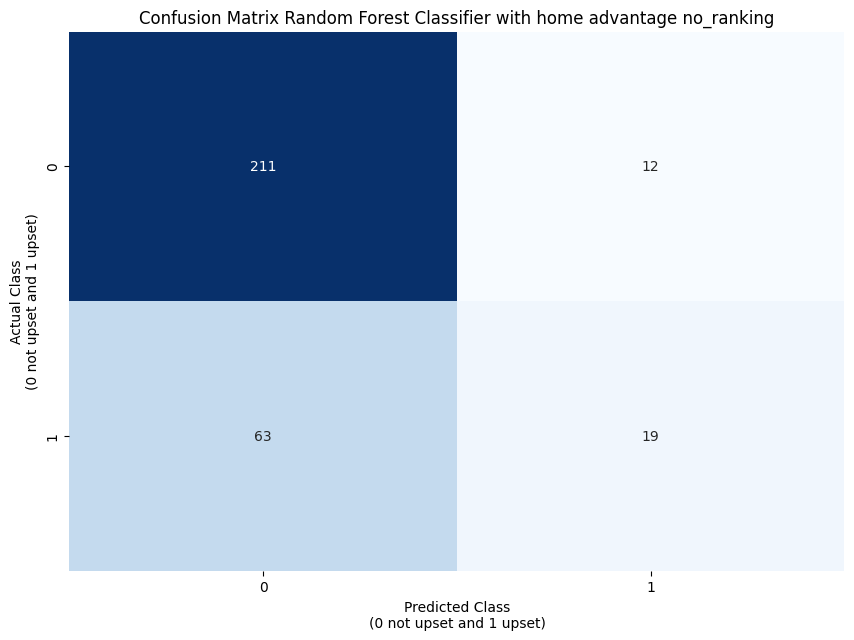

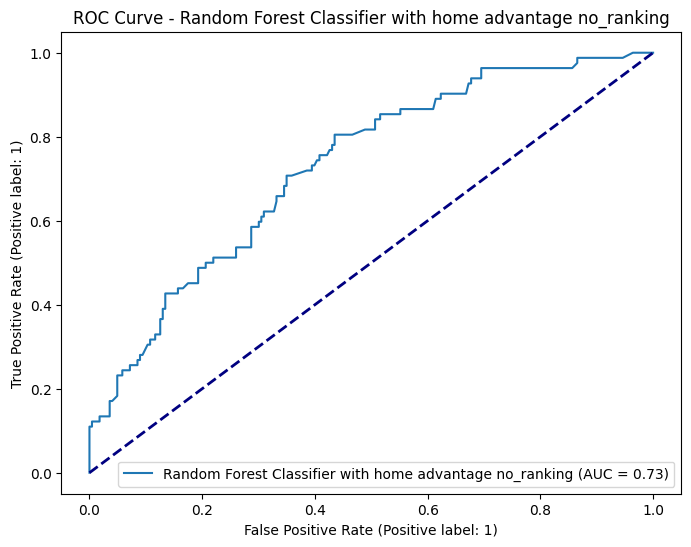

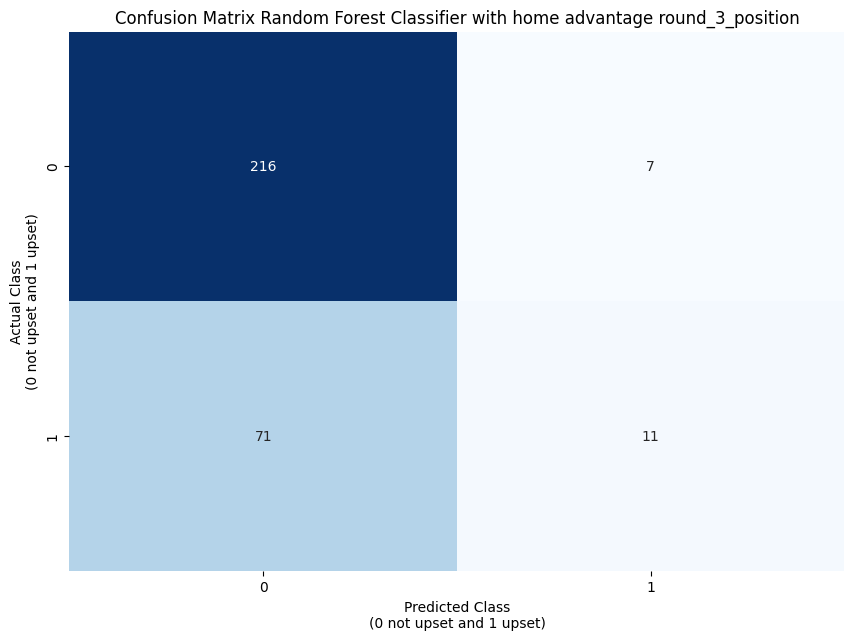

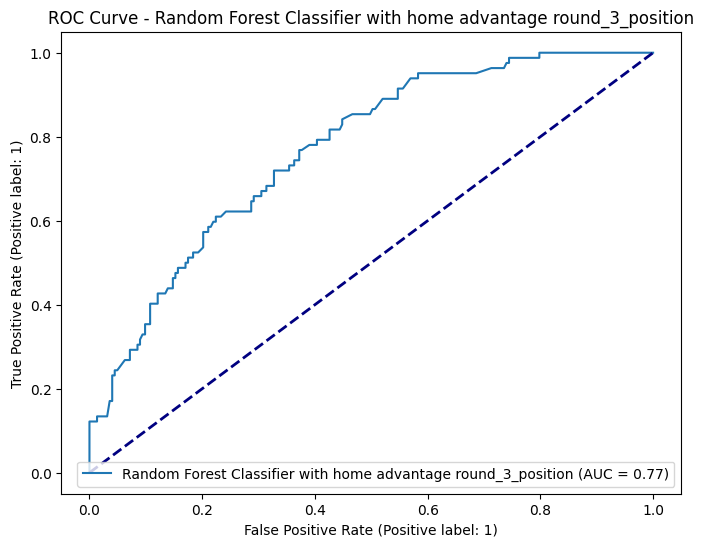

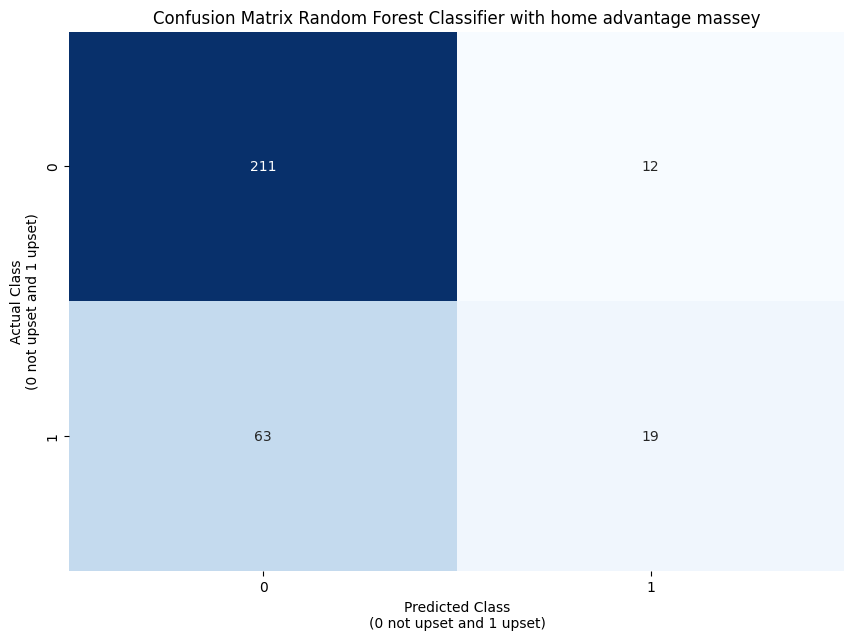

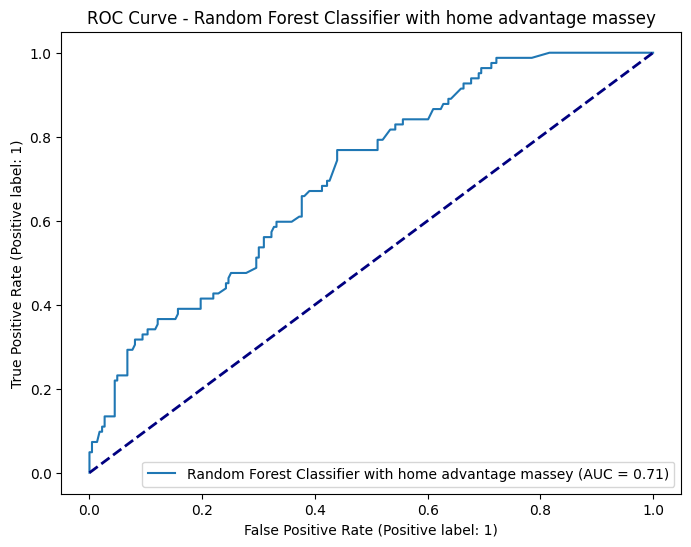

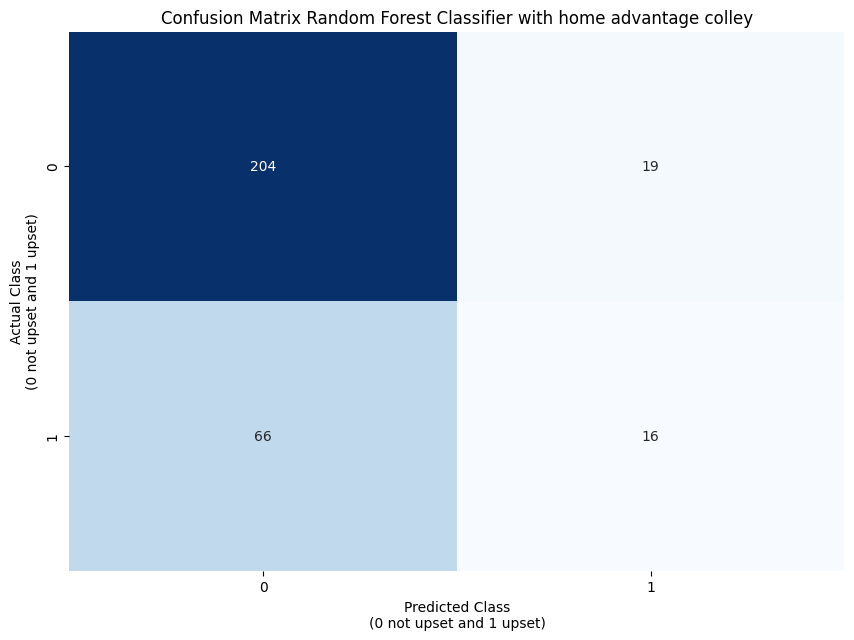

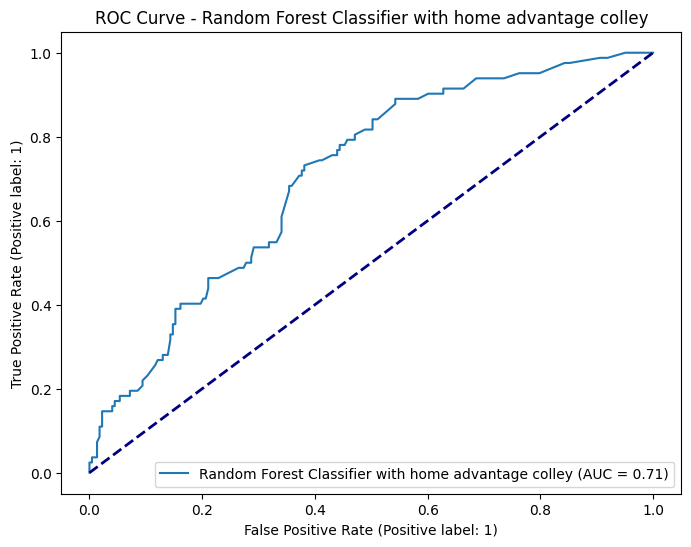

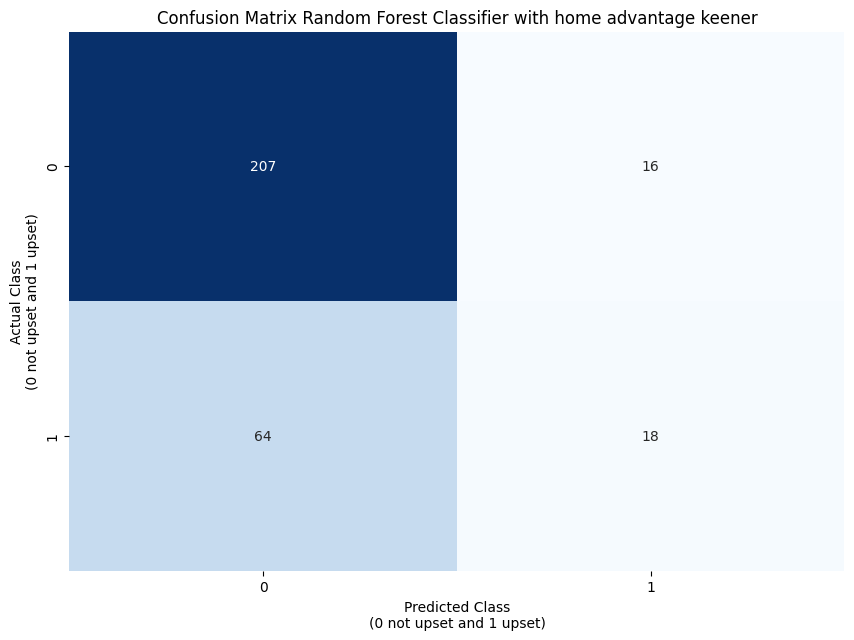

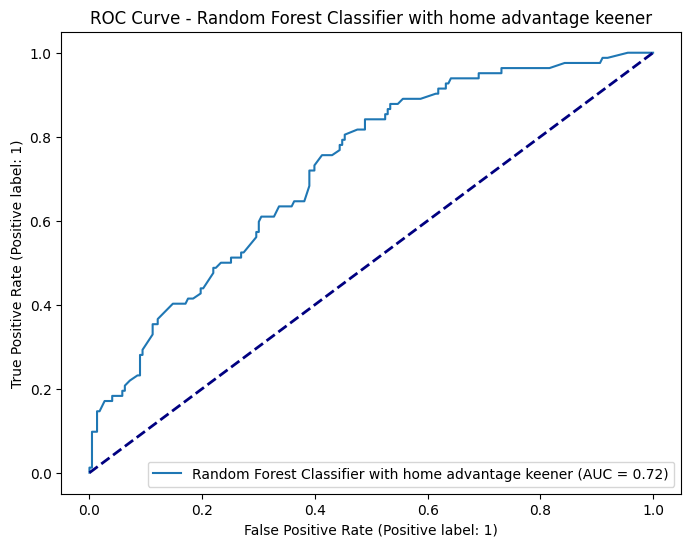

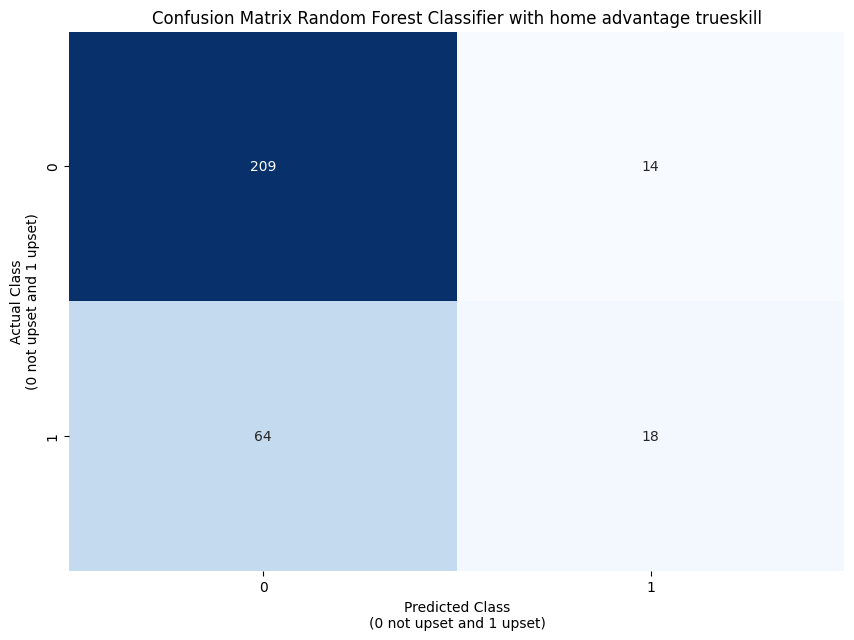

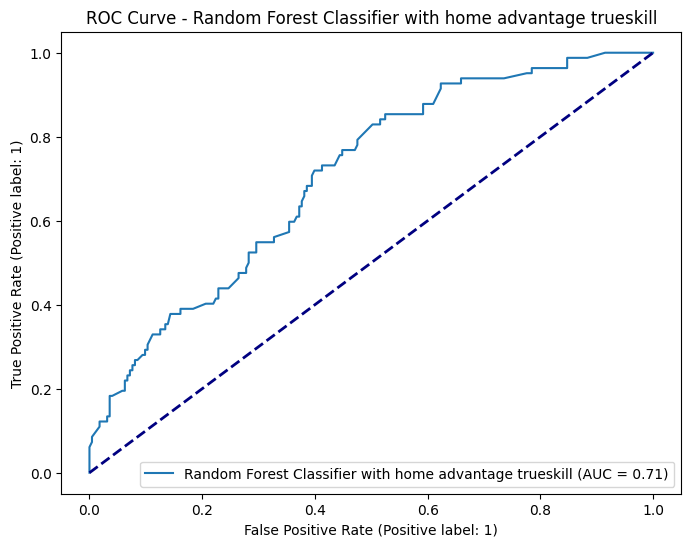

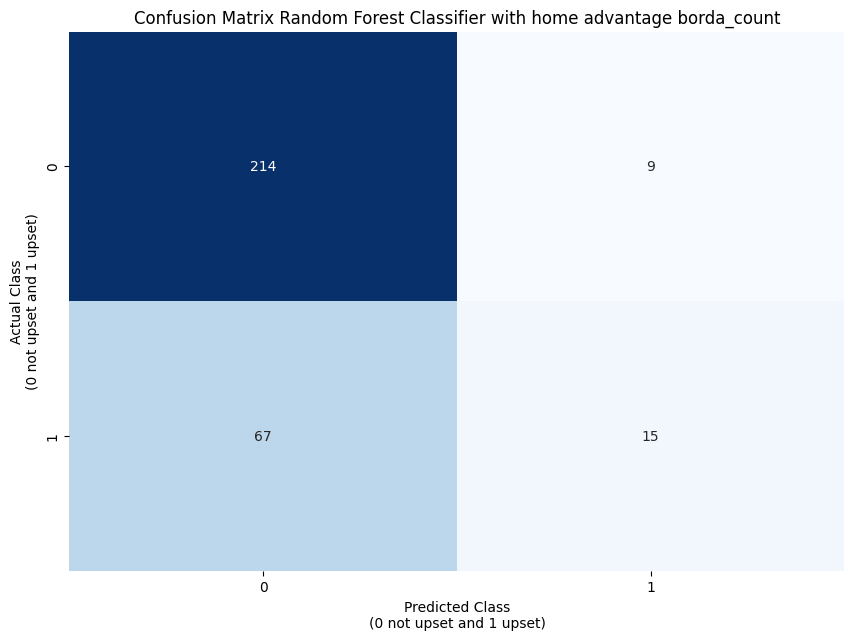

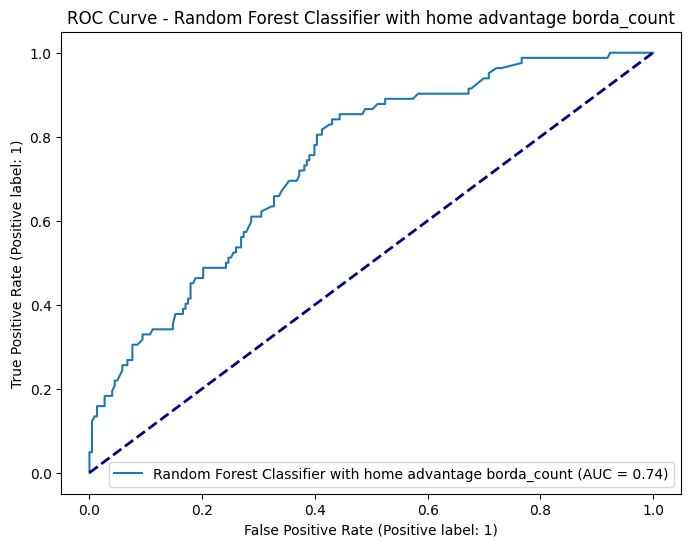

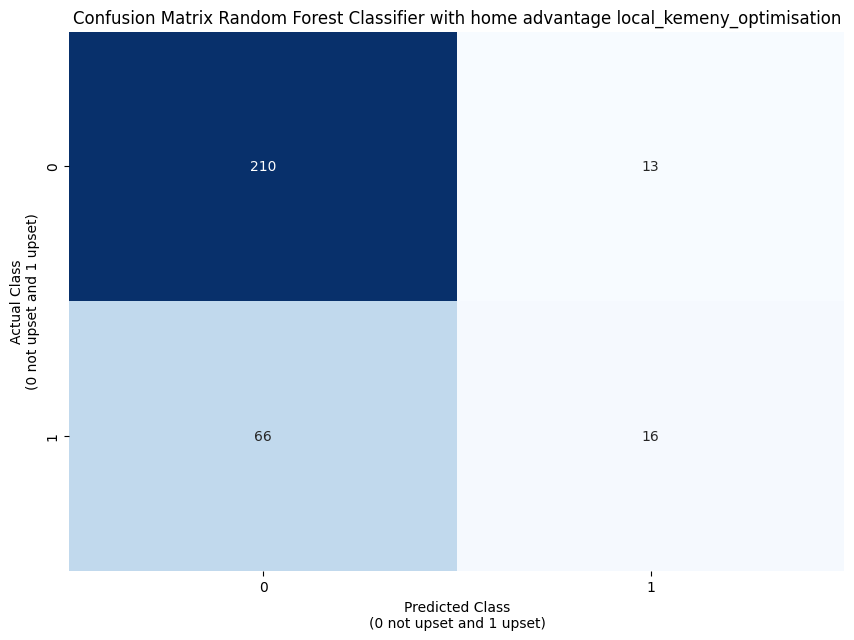

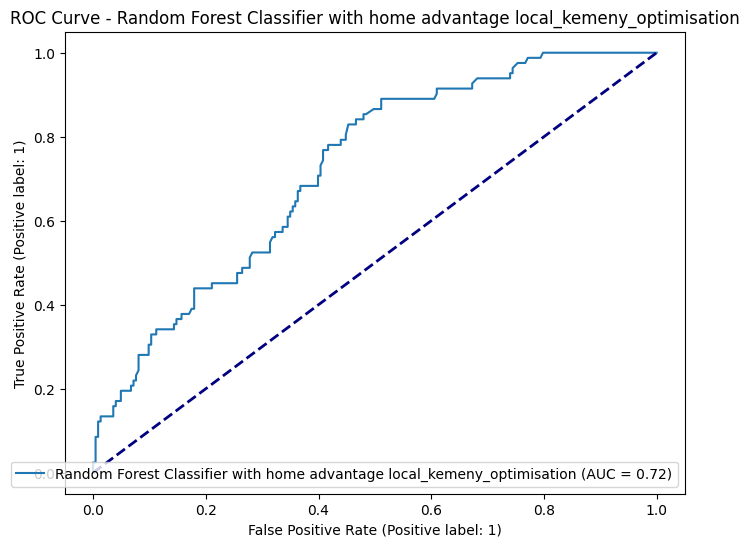

In [16]:
# Random Forest Classifier with home advantage
model_name = "Random Forest Classifier with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = RandomForestClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__n_estimators': [50, 100, 200],
    'classifier__min_samples_leaf': [1, 2, 4],
    'classifier__max_features': [ None, 'sqrt']
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_rfh = all_results_df
display(all_results_df_rfh)

fold_results_df_rfh = fold_results_df
display(fold_results_df_rfh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_rfh.to_excel("all_rfh_results.xlsx")
fold_results_df_rfh.to_excel("fold_results_rfh.xlsx")

XG Boost no_ranking
Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__subsample': 1.0}
Best Estimator's Recall (from GridSearchCV): 0.500
Fold 1 Accuracy: 0.754
Fold 1 Recall: 0.250
Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__subsample': 1.0}
Best Estimator's Recall (from GridSearchCV): 0.379
Fold 2 Accuracy: 0.705
Fold 2 Recall: 0.438
Best parameters: {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__subsample': 1.0}
Best Estimator's Recall (from GridSearchCV): 0.470
Fold 3 Accuracy: 0.738
Fold 3 Recall: 0.188
Best parameters: {'classifier__colsample_bytree': 0.6

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.01, 'classifier__max_depth': 3, 'classifier__min_child_weight': 2, 'classifier__random_state': 47, 'classifier__subsample': 1.0}
Best Estimator's Recall (from GridSearchCV): 0.455
Fold 2 Accuracy: 0.738
Fold 2 Recall: 0.000


/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__subsample': 1.0}
Best Estimator's Recall (from GridSearchCV): 0.485
Fold 3 Accuracy: 0.738
Fold 3 Recall: 0.250
Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__subsample': 1.0}
Best Estimator's Recall (from GridSearchCV): 0.444
Fold 4 Accuracy: 0.705
Fold 4 Recall: 0.176
Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__subsample': 1.0}
Best Estimator's Recall (from GridSearchCV): 0.460
Fold 5 Accuracy: 0.689
Fold 5 Recall: 0.176
Average Accuracy: 0.721
Average Recall: 0.121
XG Boost massey
Best parame

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__subsample': 0.8}
Best Estimator's Recall (from GridSearchCV): 0.394
Fold 2 Accuracy: 0.672
Fold 2 Recall: 0.375
Best parameters: {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__subsample': 1.0}
Best Estimator's Recall (from GridSearchCV): 0.470
Fold 3 Accuracy: 0.672
Fold 3 Recall: 0.312
Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__subsample': 1.0}
Best Estimator's Recall (from GridSearchCV): 0.443
Fold 4 Accuracy: 0.689
Fold 4 Recall: 0.176
Best parameters: {'classifier__colsample_bytree': 0.6, 'classifier__learn

metric_id                                        metric  \
0           1                Cross-validation Accuracy Mean   
1           2  Cross-validation Accuracy Standard Deviation   
2           3                  Cross-validation Recall Mean   
3           4    Cross-validation Recall Standard Deviation   
4           5                              Overall Accuracy   
5           6    Confusion Matrix - True Negative (Class 0)   
6           7   Confusion Matrix - False Positive (Class 1)   
7           8   Confusion Matrix - False Negative (Class 0)   
8           9    Confusion Matrix - True Positive (Class 1)   
9          10                           Precision (Class 0)   
10         11                              Recall (Class 0)   
11         12                            F1-score (Class 0)   
12         13                           Precision (Class 1)   
13         14                              Recall (Class 1)   
14         15                            F1-score (Class 1)   
15         16                           Macro avg Precision   
16         17                              Macro avg Recall   
17         18                            Macro avg F1-score   
18         19                        Weighted avg Precision   
19         20                           Weighted avg Recall   
20         21                         Weighted avg F1-score   
21         22                                       AUC-ROC   

   XG Boost no_ranking XG Boost round_3_position XG Boost massey  \
0                0.721                     0.721           0.721   
1                0.021                     0.021           0.018   
2                0.199                     0.121           0.270   
3                0.145                     0.102           0.118   
4                0.721                     0.721           0.721   
5              204.000                   210.000         198.000   
6               19.000                    13.000          25.000   
7               66.000                    72.000          60.000   
8               16.000                    10.000          22.000   
9                0.756                     0.745           0.767   
10               0.915                     0.942           0.888   
11               0.828                     0.832           0.823   
12               0.457                     0.435           0.468   
13               0.195                     0.122           0.268   
14               0.274                     0.190           0.341   
15               0.606                     0.590           0.618   
16               0.555                     0.532           0.578   
17               0.551                     0.511           0.582   
18               0.675                     0.661           0.687   
19               0.721                     0.721           0.721   
20               0.679                     0.659           0.694   
21               0.646                     0.666           0.631   

   XG Boost colley XG Boost keener XG Boost trueskill XG Boost borda_count  \
0            0.734           0.702              0.698                0.689   
1            0.038           0.030              0.042                0.050   
2            0.307           0.220              0.234                0.257   
3            0.073           0.129              0.077                0.073   
4            0.734           0.702              0.698                0.689   
5          199.000         196.000            194.000              189.000   
6           24.000          27.000             29.000               34.000   
7           57.000          64.000             63.000               61.000   
8           25.000          18.000             19.000               21.000   
9            0.777           0.754              0.755                0.756   
10           0.892           0.879              0.870                0.848   
11           0.831           0.812              0.808

Model Name Ranking  Fold  \
0                  XG Boost no_ranking     1   
1                  XG Boost no_ranking     2   
2                  XG Boost no_ranking     3   
3                  XG Boost no_ranking     4   
4                  XG Boost no_ranking     5   
5            XG Boost round_3_position     1   
6            XG Boost round_3_position     2   
7            XG Boost round_3_position     3   
8            XG Boost round_3_position     4   
9            XG Boost round_3_position     5   
10                     XG Boost massey     1   
11                     XG Boost massey     2   
12                     XG Boost massey     3   
13                     XG Boost massey     4   
14                     XG Boost massey     5   
15                     XG Boost colley     1   
16                     XG Boost colley     2   
17                     XG Boost colley     3   
18                     XG Boost colley     4   
19                     XG Boost colley     5   
20                     XG Boost keener     1   
21                     XG Boost keener     2   
22                     XG Boost keener     3   
23                     XG Boost keener     4   
24                     XG Boost keener     5   
25                  XG Boost trueskill     1   
26                  XG Boost trueskill     2   
27                  XG Boost trueskill     3   
28                  XG Boost trueskill     4   
29                  XG Boost trueskill     5   
30                XG Boost borda_count     1   
31                XG Boost borda_count     2   
32                XG Boost borda_count     3   
33                XG Boost borda_count     4   
34                XG Boost borda_count     5   
35  XG Boost local_kemeny_optimisation     1   
36  XG Boost local_kemeny_optimisation     2   
37  XG Boost local_kemeny_optimisation     3   
38  XG Boost local_kemeny_optimisation     4   
39  XG Boost local_kemeny_optimisation     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__colsample_bytree': 1.0, 'classif...   
1   {'classifier__colsample_bytree': 1.0, 'classif...   
2   {'classifier__colsample_bytree': 0.6, 'classif...   
3   {'classifier__colsample_bytree': 0.6, 'classif...   
4   {'classifier__colsample_bytree': 1.0, 'classif...   
5   {'classifier__colsample_bytree': 0.6, 'classif...   
6   {'classifier__colsample_bytree': 0.6, 'classif...   
7   {'classifier__colsample_bytree': 0.6, 'classif...   
8   {'classifier__colsample_bytree': 1.0, 'classif...   
9   {'classifier__colsample_bytree': 1.0, 'classif...   
10  {'classifier__colsample_bytree': 0.6, 'classif...   
11  {'classifier__colsample_bytree': 0.6, 'classif...   
12  {'classifier__colsample_bytree': 0.6, 'classif...   
13  {'classifier__colsample_bytree': 1.0, 'classif...   
14  {'classifier__colsample_bytree': 0.6, 'classif...   
15  {'classifier__colsample_bytree': 0.6, 'classif...   
16  {'classifier__colsample_bytree': 1.0, 'classif...   
17  {'classifier__colsample_bytree': 1.0, 'classif...   
18  {'classifier__colsample_bytree': 1.0, 'classif...   
19  {'classifier__colsample_bytree': 1.0, 'classif...   
20  {'classifier__colsample_bytree': 1.0, 'classif...   
21  {'classifier__colsample_bytree': 0.6, 'classif...   
22  {'classifier__colsample_bytree': 0.6, 'classif...   
23  {'classifier__colsample_bytree': 1.0, 'classif...   
24  {'classifier__colsample_bytree': 0.6, 'classif...   
25  {'classifier__colsample_bytree': 1.0, 'classif...   
26  {'classifier__colsample_bytree': 0.6, 'classif...   
27  {'classifier__colsample_bytree': 0.6, 'classif...   
28  {'classifier__colsample_bytree': 1.0, 'classif...   
29  {'classifier__colsample_bytree': 1.0, 'classif...   
30  {'classifier__colsample_bytree': 0.6, 'classif...   
31  {'classifier__colsample_bytree': 1.0, 'classif...   
32  {'classifier__colsample_bytree': 0.6, 'classif...   
33  {'classifier__colsample_bytree': 1.0, 'classif...   
34  {'classifier__colsample_bytree': 1.0, 'classif...   

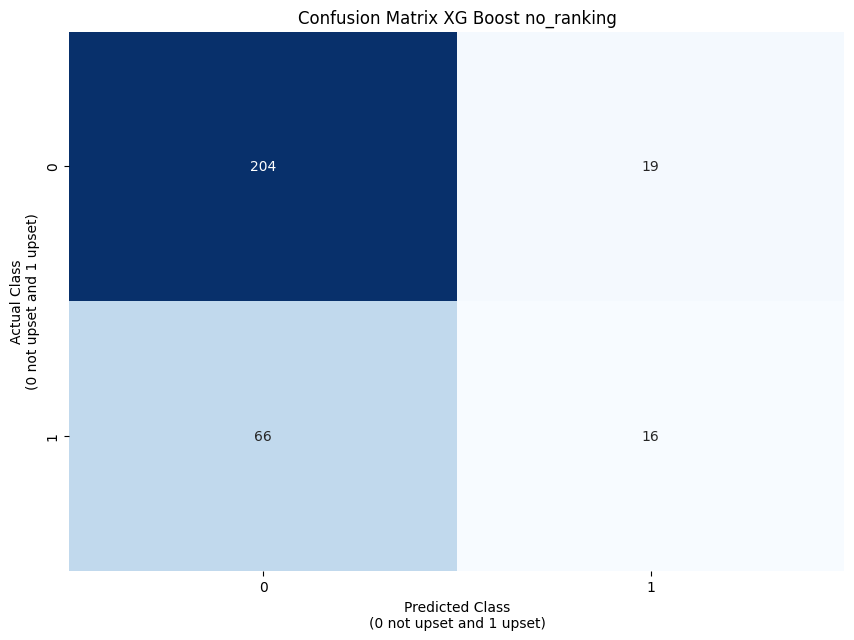

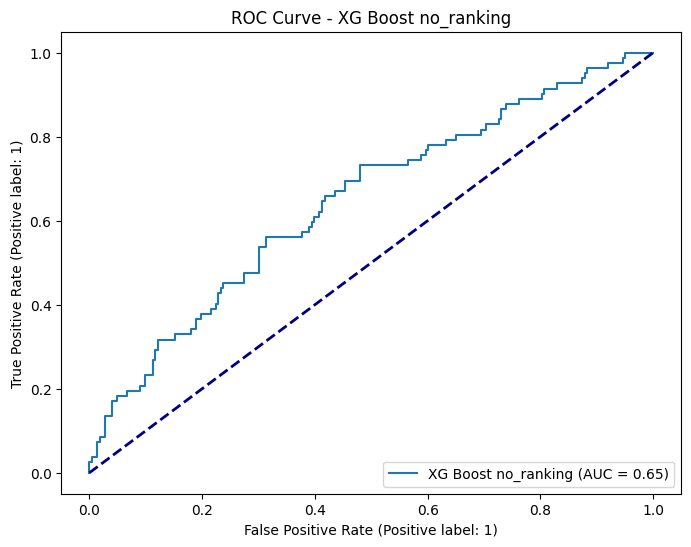

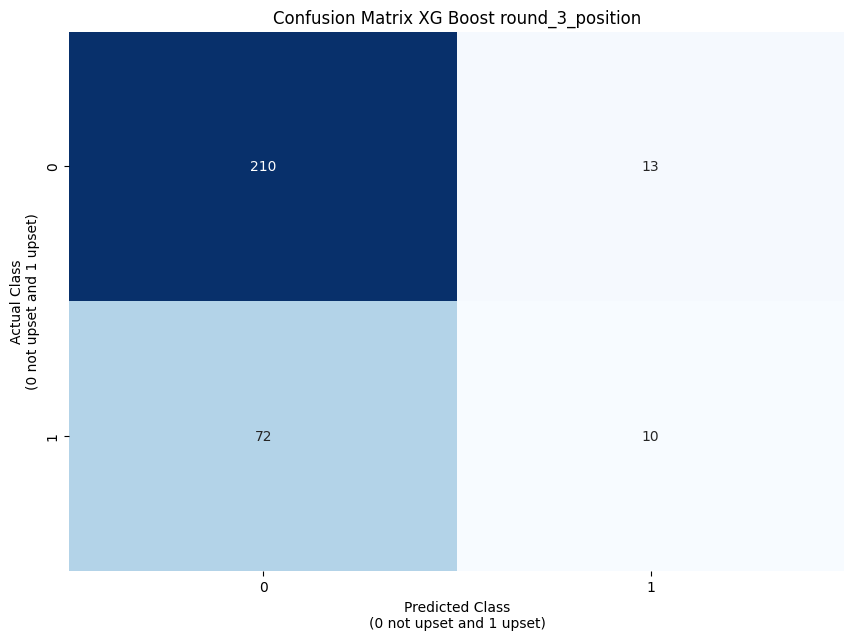

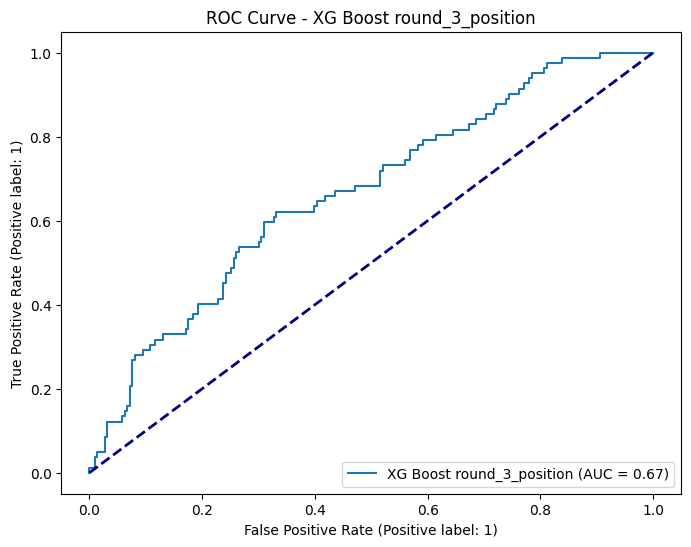

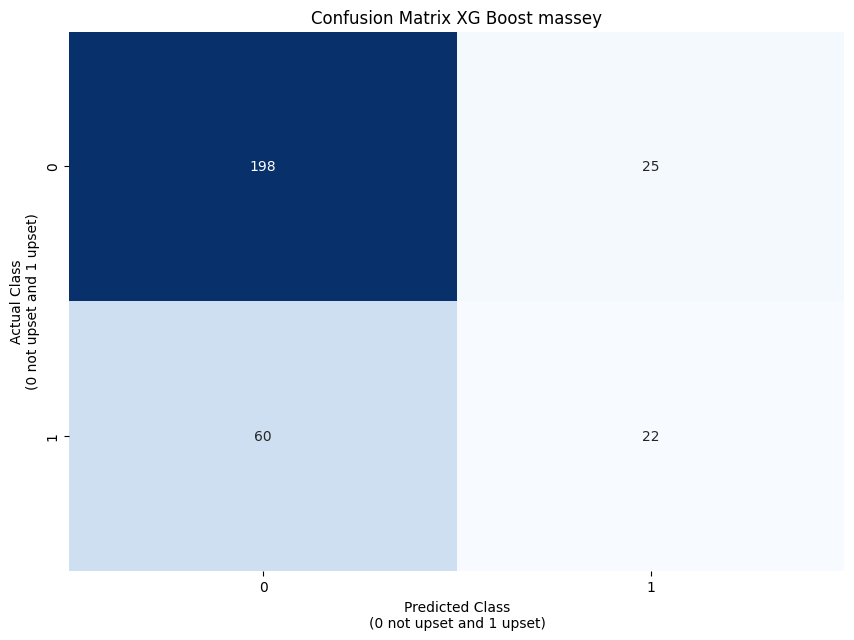

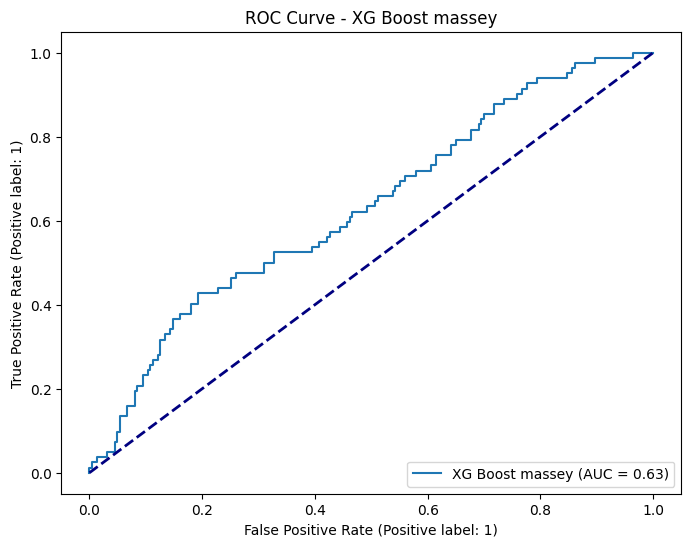

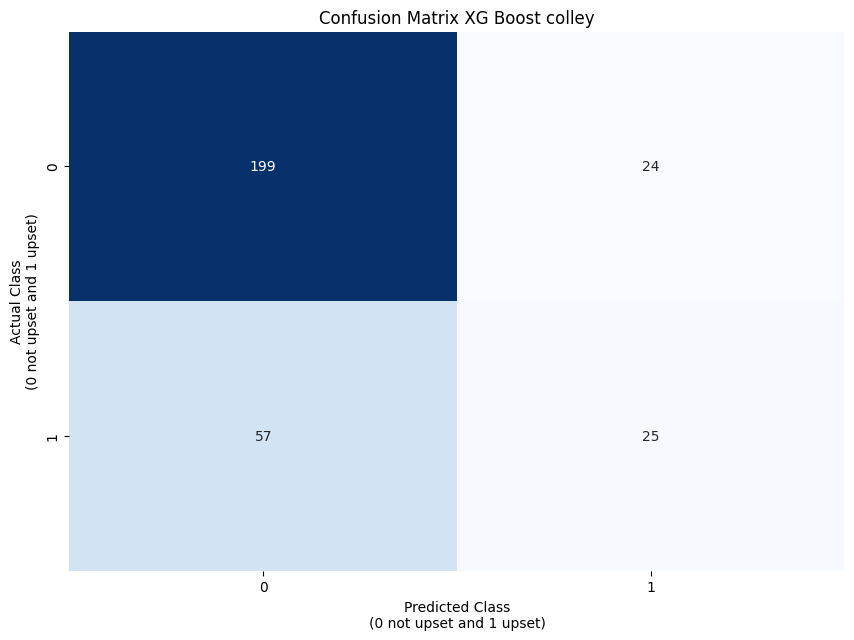

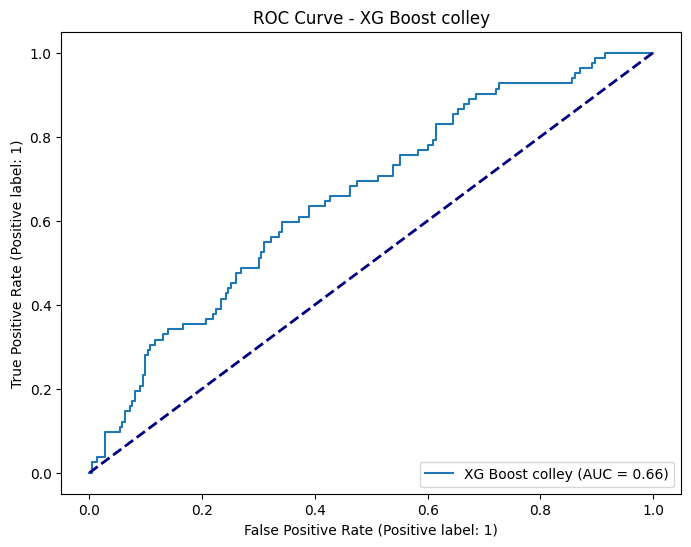

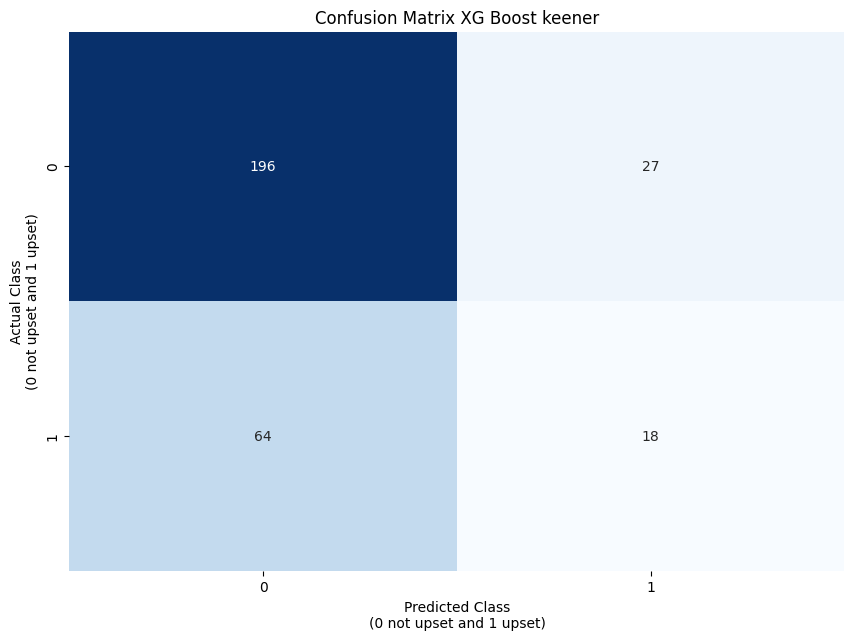

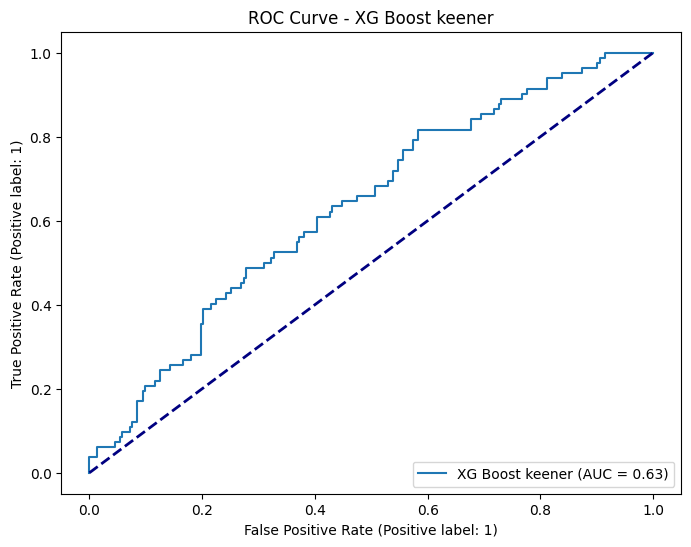

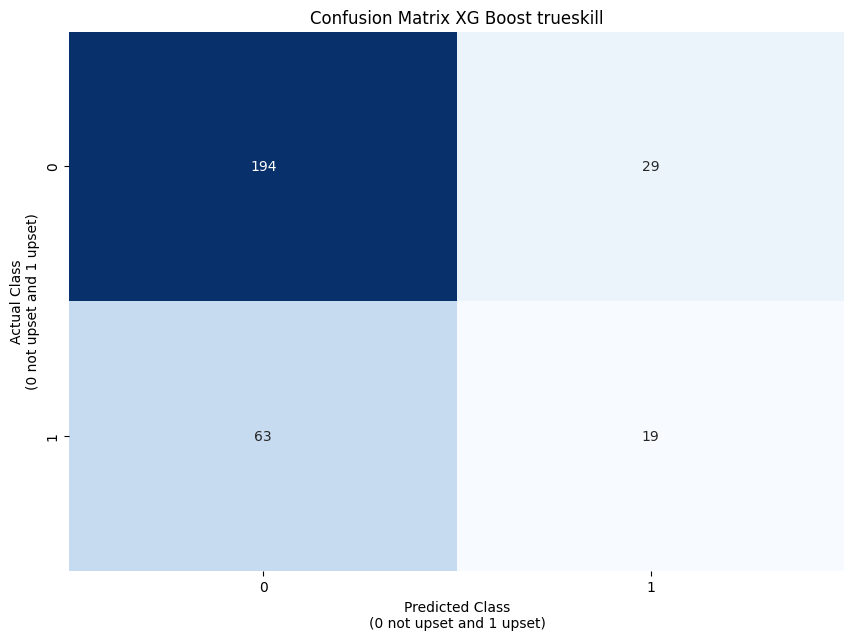

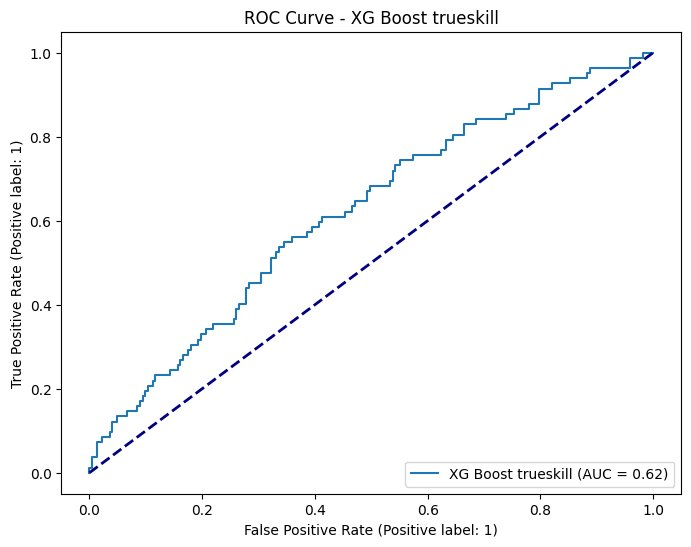

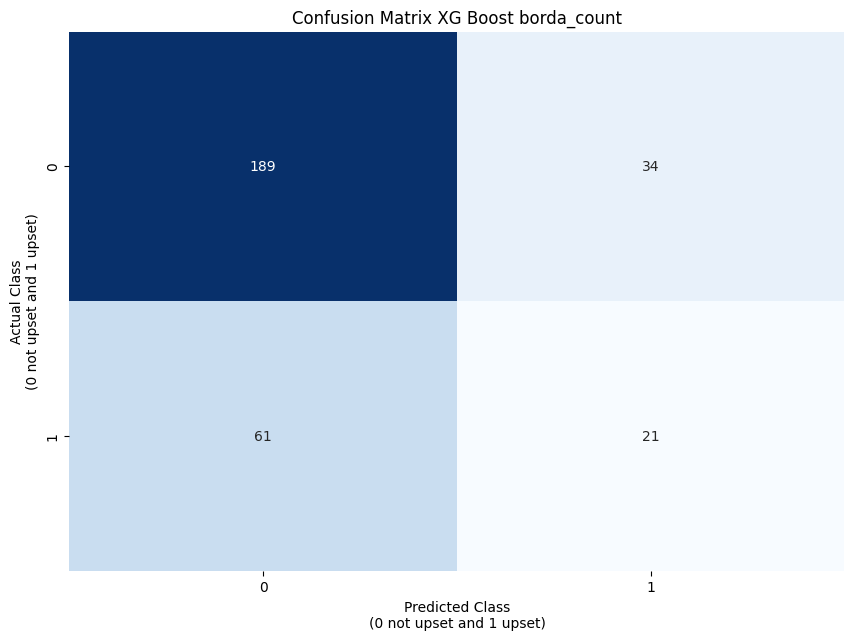

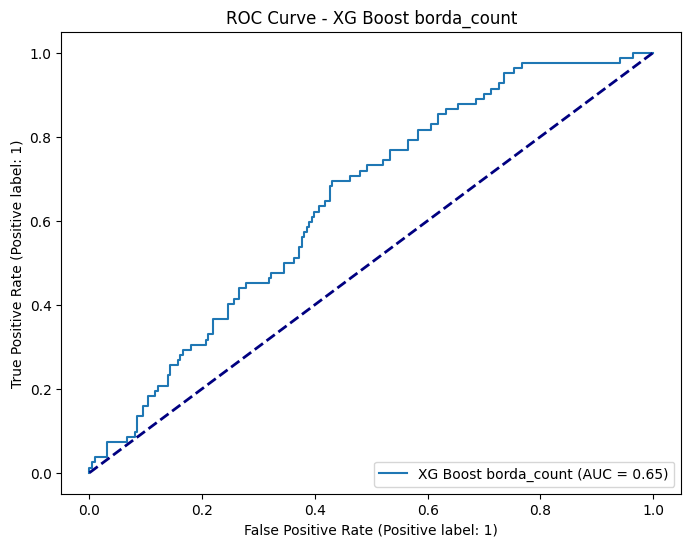

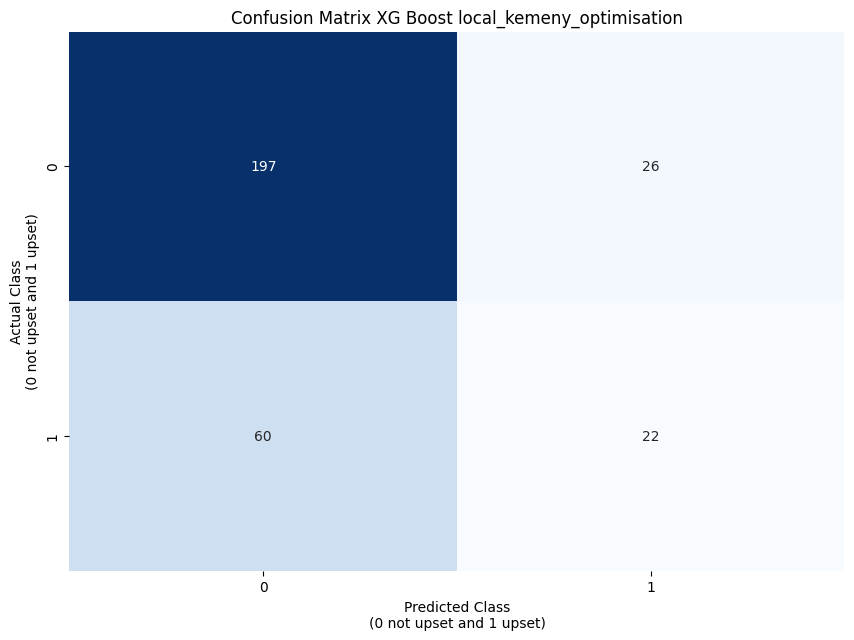

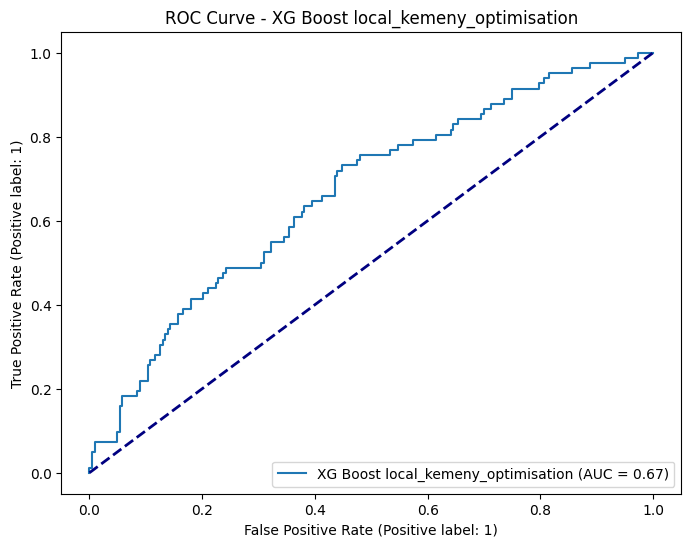

In [17]:
# XG Boost
model_name = "XG Boost"
home_advt = 'no'
weighted = 'no'
random_state = 47
model_classifier  = XGBClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__max_depth': [3,5],
    'classifier__min_child_weight': [1, 2],
    'classifier__subsample': [ 0.8, 1.0],
    'classifier__colsample_bytree': [ 0.6, 1.0],
    'classifier__learning_rate':  [0.01, 0.1]
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_xg = all_results_df
display(all_results_df_xg)

fold_results_df_xg = fold_results_df
display(fold_results_df_xg)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_xg.to_excel("all_xg_results.xlsx")
fold_results_df_xg.to_excel("fold_results_xg.xlsx")

XG Boost with home advantage no_ranking
Best parameters: {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 2, 'classifier__random_state': 47, 'classifier__subsample': 1.0}
Best Estimator's Recall (from GridSearchCV): 0.500
Fold 1 Accuracy: 0.705
Fold 1 Recall: 0.125
Best parameters: {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__subsample': 0.8}
Best Estimator's Recall (from GridSearchCV): 0.394
Fold 2 Accuracy: 0.754
Fold 2 Recall: 0.500
Best parameters: {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 3, 'classifier__min_child_weight': 1, 'classifier__random_state': 47, 'classifier__subsample': 1.0}
Best Estimator's Recall (from GridSearchCV): 0.455
Fold 3 Accuracy: 0.770
Fold 3 Recall: 0.125
Best parameters: {'classifier__co

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


Best parameters: {'classifier__colsample_bytree': 1.0, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 2, 'classifier__random_state': 47, 'classifier__subsample': 0.8}
Best Estimator's Recall (from GridSearchCV): 0.460
Fold 5 Accuracy: 0.672
Fold 5 Recall: 0.118
Average Accuracy: 0.698
Average Recall: 0.136
XG Boost with home advantage massey
Best parameters: {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 2, 'classifier__random_state': 47, 'classifier__subsample': 1.0}
Best Estimator's Recall (from GridSearchCV): 0.485
Fold 1 Accuracy: 0.721
Fold 1 Recall: 0.250
Best parameters: {'classifier__colsample_bytree': 0.6, 'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__min_child_weight': 2, 'classifier__random_state': 47, 'classifier__subsample': 0.8}
Best Estimator's Recall (from GridSearchCV): 0.470
Fold 2 Accuracy: 0.754
Fold 2 Recal

metric_id                                        metric  \
0           1                Cross-validation Accuracy Mean   
1           2  Cross-validation Accuracy Standard Deviation   
2           3                  Cross-validation Recall Mean   
3           4    Cross-validation Recall Standard Deviation   
4           5                              Overall Accuracy   
5           6    Confusion Matrix - True Negative (Class 0)   
6           7   Confusion Matrix - False Positive (Class 1)   
7           8   Confusion Matrix - False Negative (Class 0)   
8           9    Confusion Matrix - True Positive (Class 1)   
9          10                           Precision (Class 0)   
10         11                              Recall (Class 0)   
11         12                            F1-score (Class 0)   
12         13                           Precision (Class 1)   
13         14                              Recall (Class 1)   
14         15                            F1-score (Class 1)   
15         16                           Macro avg Precision   
16         17                              Macro avg Recall   
17         18                            Macro avg F1-score   
18         19                        Weighted avg Precision   
19         20                           Weighted avg Recall   
20         21                         Weighted avg F1-score   
21         22                                       AUC-ROC   

   XG Boost with home advantage no_ranking  \
0                                    0.721   
1                                    0.036   
2                                    0.232   
3                                    0.140   
4                                    0.721   
5                                  201.000   
6                                   22.000   
7                                   63.000   
8                                   19.000   
9                                    0.761   
10                                   0.901   
11                                   0.825   
12                                   0.463   
13                                   0.232   
14                                   0.309   
15                                   0.612   
16                                   0.567   
17                                   0.567   
18                                   0.681   
19                                   0.721   
20                                   0.687   
21                                   0.657   

   XG Boost with home advantage round_3_position  \
0                                          0.698   
1                                          0.020   
2                                          0.136   
3                                          0.155   
4                                          0.698   
5                                        202.000   
6                                         21.000   
7                                         71.000   
8                                         11.000   
9                                          0.740   
10                                         0.906   
11                                         0.815   
12                                         0.344   
13                                         0.134   
14                                         0.193   
15                                         0.542   
16                                         0.520   
17                                         0.504   
18                                         0.633   
19                                         0.698   
20                                         0.647   
21                                         0.657   

   XG Boost with home advantage massey XG Boost with home advantage colley  \
0                                0.725                               0.718   
1                                0.042                               0.035   
2                                0.271                          

Model Name Ranking  Fold  \
0             XG Boost with home advantage no_ranking     1   
1             XG Boost with home advantage no_ranking     2   
2             XG Boost with home advantage no_ranking     3   
3             XG Boost with home advantage no_ranking     4   
4             XG Boost with home advantage no_ranking     5   
5       XG Boost with home advantage round_3_position     1   
6       XG Boost with home advantage round_3_position     2   
7       XG Boost with home advantage round_3_position     3   
8       XG Boost with home advantage round_3_position     4   
9       XG Boost with home advantage round_3_position     5   
10                XG Boost with home advantage massey     1   
11                XG Boost with home advantage massey     2   
12                XG Boost with home advantage massey     3   
13                XG Boost with home advantage massey     4   
14                XG Boost with home advantage massey     5   
15                XG Boost with home advantage colley     1   
16                XG Boost with home advantage colley     2   
17                XG Boost with home advantage colley     3   
18                XG Boost with home advantage colley     4   
19                XG Boost with home advantage colley     5   
20                XG Boost with home advantage keener     1   
21                XG Boost with home advantage keener     2   
22                XG Boost with home advantage keener     3   
23                XG Boost with home advantage keener     4   
24                XG Boost with home advantage keener     5   
25             XG Boost with home advantage trueskill     1   
26             XG Boost with home advantage trueskill     2   
27             XG Boost with home advantage trueskill     3   
28             XG Boost with home advantage trueskill     4   
29             XG Boost with home advantage trueskill     5   
30           XG Boost with home advantage borda_count     1   
31           XG Boost with home advantage borda_count     2   
32           XG Boost with home advantage borda_count     3   
33           XG Boost with home advantage borda_count     4   
34           XG Boost with home advantage borda_count     5   
35  XG Boost with home advantage local_kemeny_opti...     1   
36  XG Boost with home advantage local_kemeny_opti...     2   
37  XG Boost with home advantage local_kemeny_opti...     3   
38  XG Boost with home advantage local_kemeny_opti...     4   
39  XG Boost with home advantage local_kemeny_opti...     5   

                       Best Parameters (GridSearchCV)  \
0   {'classifier__colsample_bytree': 0.6, 'classif...   
1   {'classifier__colsample_bytree': 0.6, 'classif...   
2   {'classifier__colsample_bytree': 0.6, 'classif...   
3   {'classifier__colsample_bytree': 1.0, 'classif...   
4   {'classifier__colsample_bytree': 0.6, 'classif...   
5   {'classifier__colsample_bytree': 1.0, 'classif...   
6   {'classifier__colsample_bytree': 0.6, 'classif...   
7   {'classifier__colsample_bytree': 0.6, 'classif...   
8   {'classifier__colsample_bytree': 1.0, 'classif...   
9   {'classifier__colsample_bytree': 1.0, 'classif...   
10  {'classifier__colsample_bytree': 0.6, 'classif...   
11  {'classifier__colsample_bytree': 0.6, 'classif...   
12  {'classifier__colsample_bytree': 0.6, 'classif...   
13  {'classifier__colsample_bytree': 1.0, 'classif...   
14  {'classifier__colsample_bytree': 1.0, 'classif...   
15  {'classifier__colsample_bytree': 1.0, 'classif...   
16  {'classifier__colsample_bytree': 1.0, 'classif...   
17  {'classifier__colsample_bytree': 0.6, 'classif...   
18  {'classifier__colsample_bytree': 0.6, 'classif...   
19  {'classifier__colsample_bytree': 1.0, 'classif...   
20  {'classifier__colsample_bytree': 0.6, 'classif...   
21  {'classifier__colsample_bytree': 1.0, 'classif...   
22  {'classifier__colsample_bytree': 0.6, 'classif...   
23  {'classifier__colsample_bytree': 0.6, 'classif...   
24  {'classifier__colsampl

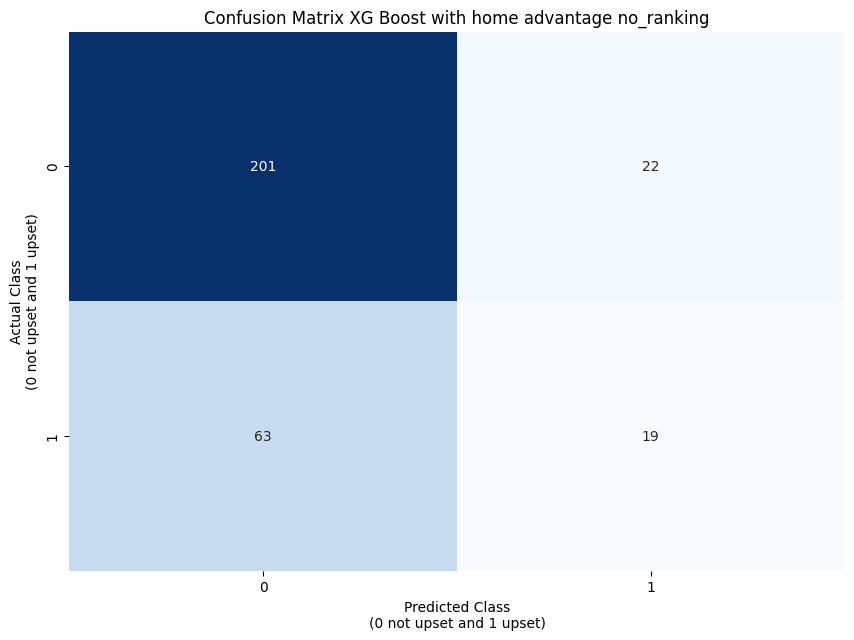

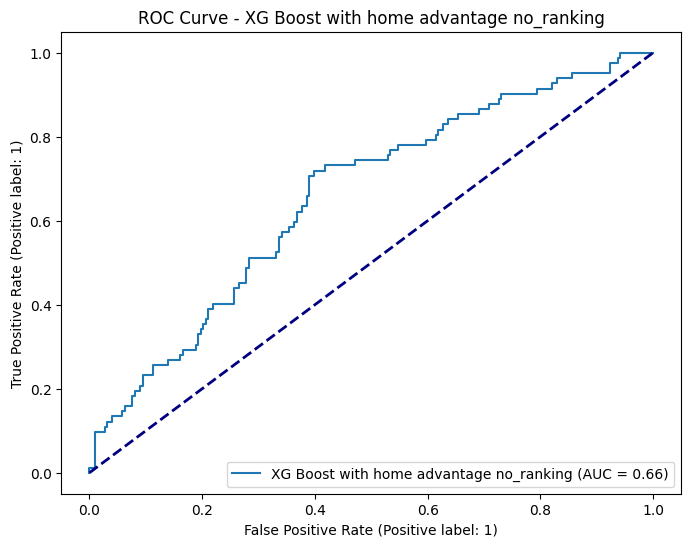

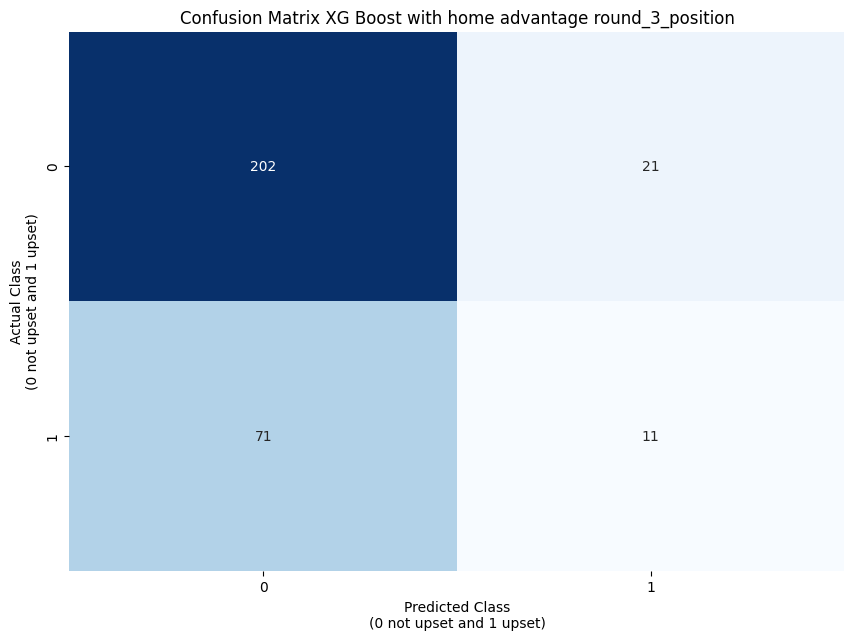

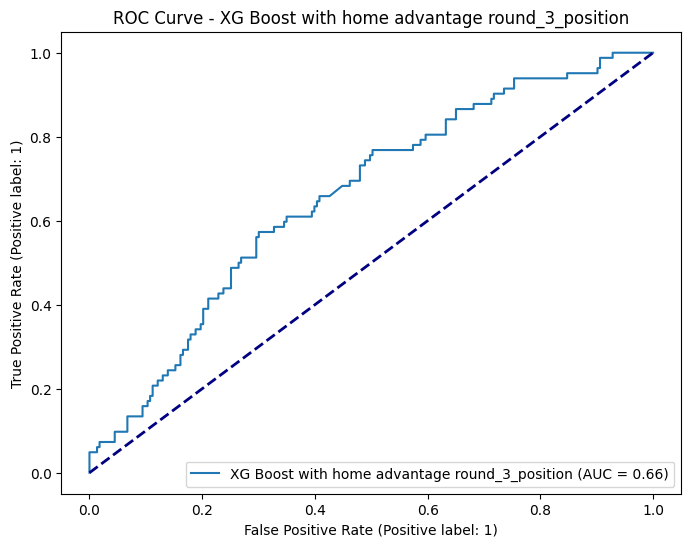

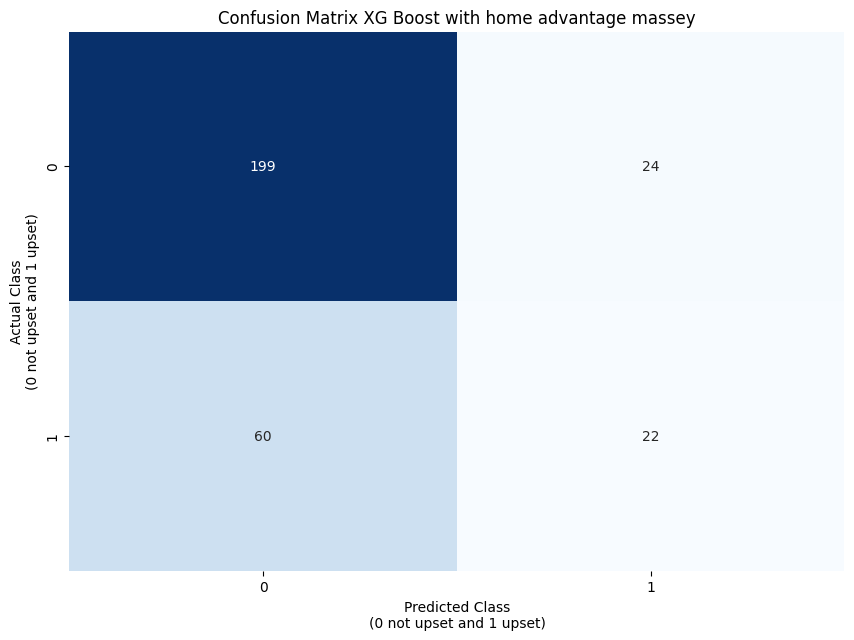

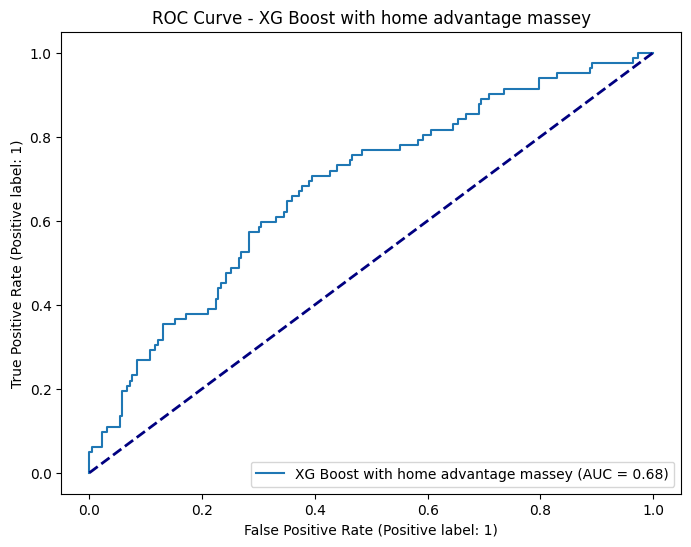

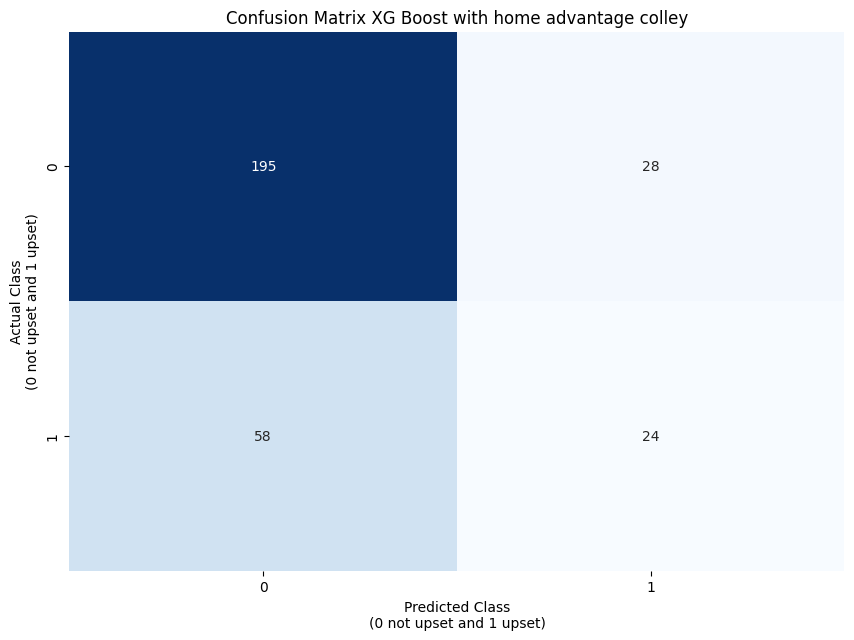

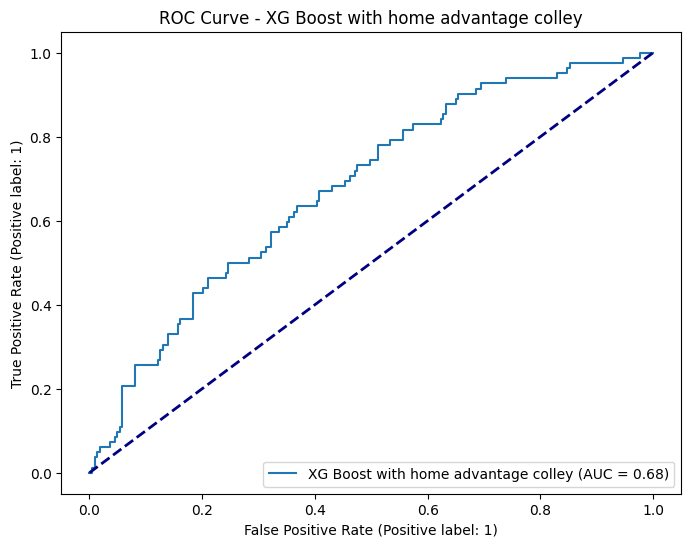

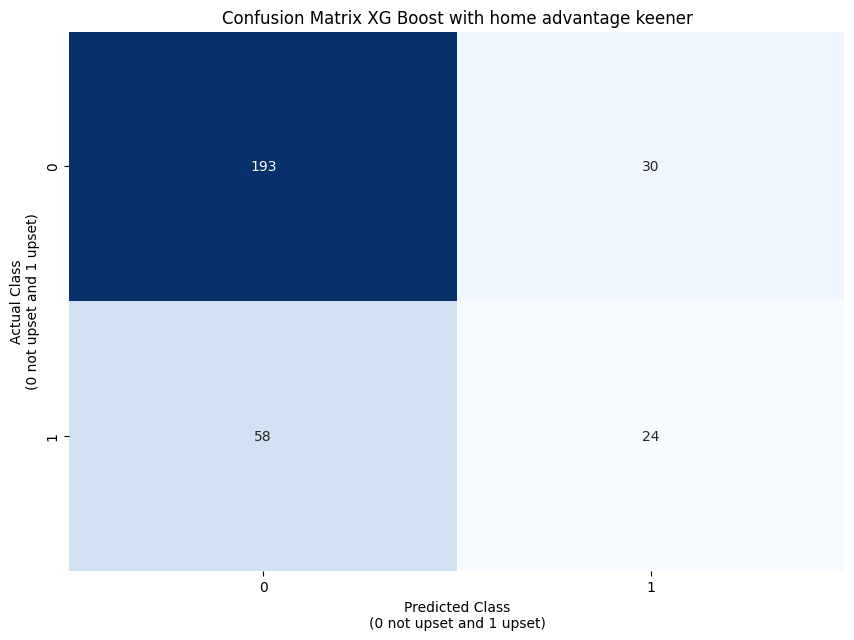

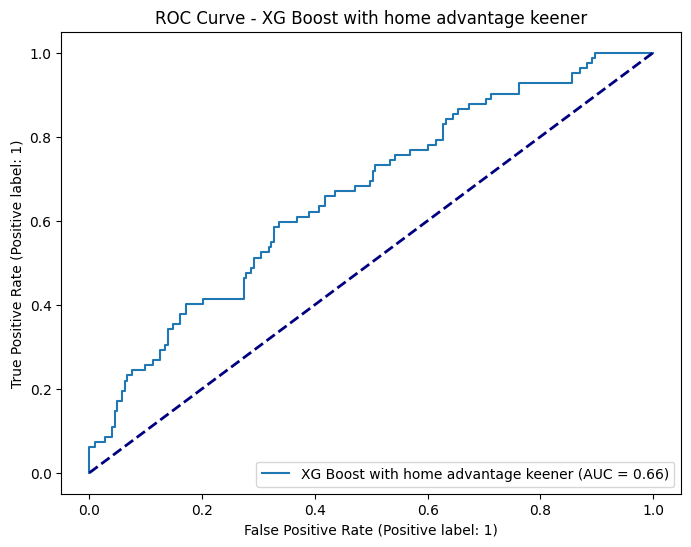

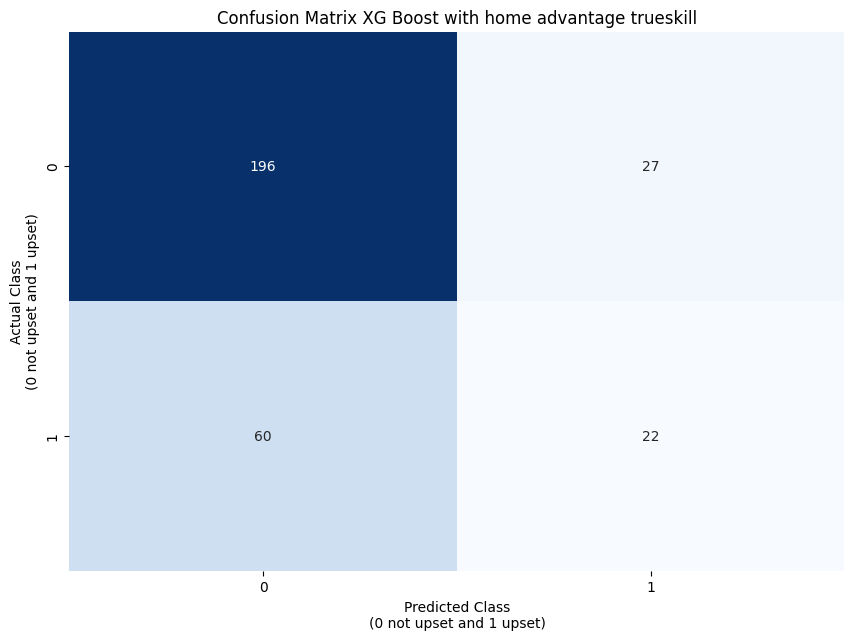

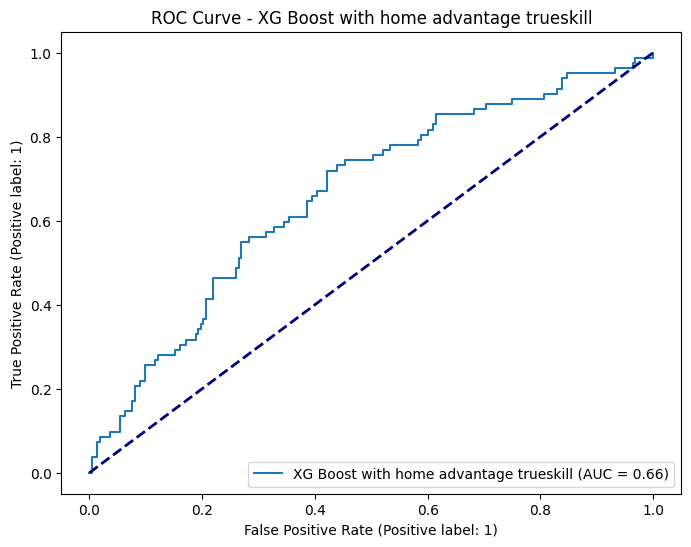

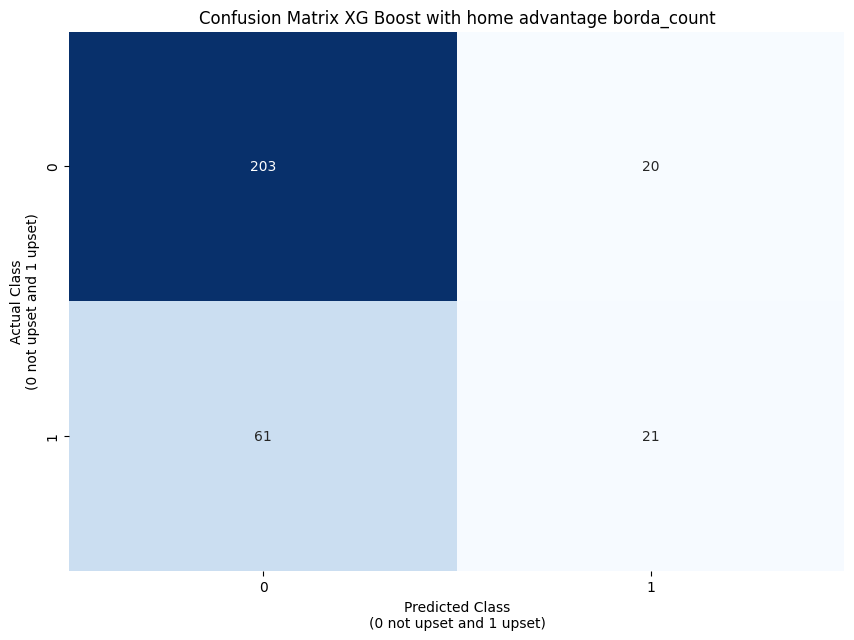

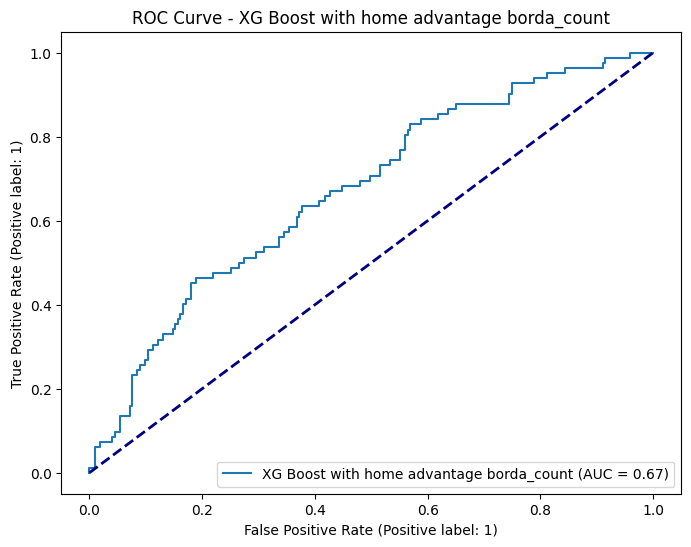

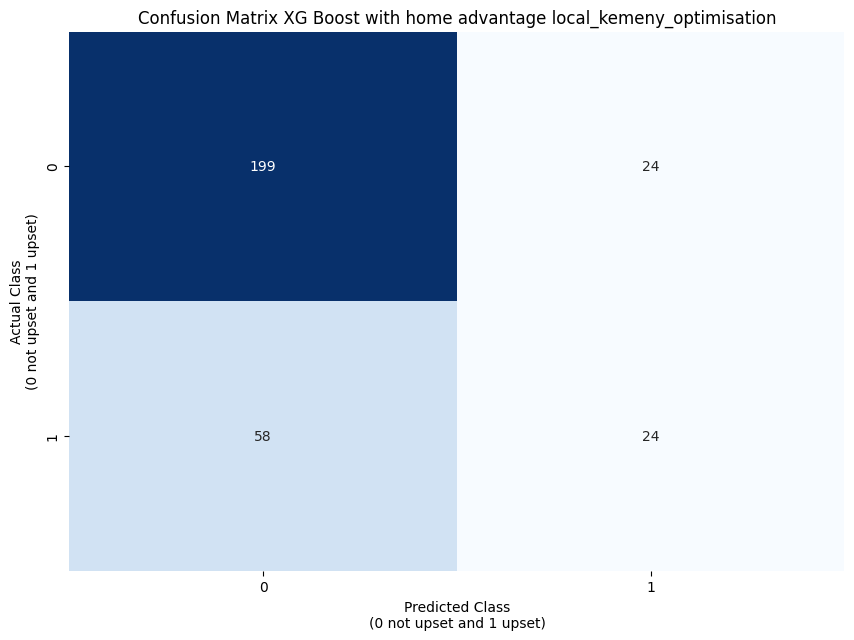

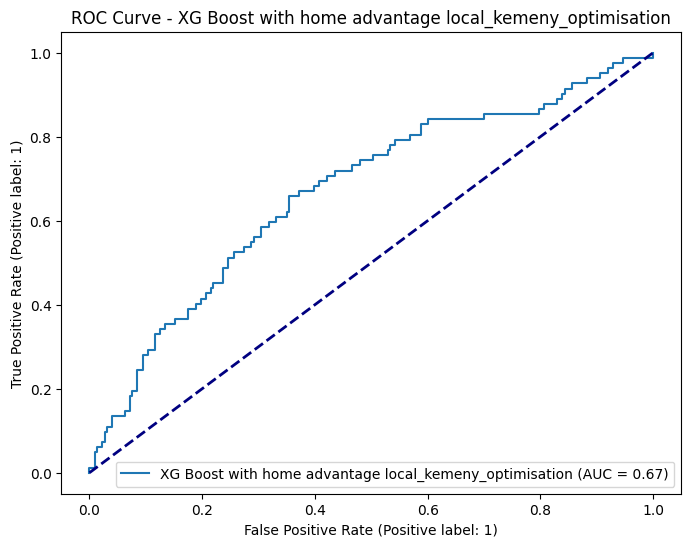

In [18]:
# XG Boost with home advantage
model_name = "XG Boost with home advantage"
home_advt = 'yes'
weighted = 'no'
random_state = 47
model_classifier  = XGBClassifier()

# Define parameter grid for GridSearchCV
param_grid = {
    'classifier__random_state': [random_state],
    'classifier__max_depth': [3,5],
    'classifier__min_child_weight': [1, 2],
    'classifier__subsample': [ 0.8, 1.0],
    'classifier__colsample_bytree': [ 0.6, 1.0],
    'classifier__learning_rate':  [0.01, 0.1]
}

all_results_df, fold_results_df  = classifer_models_optimisation (model_name, home_advt, weighted, model_classifier, param_grid, random_state)

all_results_df_xgh = all_results_df
display(all_results_df_xgh)

fold_results_df_xgh = fold_results_df
display(fold_results_df_xgh)

# Change default ouput directory
os.chdir('/content/drive/MyDrive/birkbeck_msc-project/output_files')
# Save ranks to excel
all_results_df_xgh.to_excel("all_xgh_results.xlsx")
fold_results_df_xgh.to_excel("fold_results_xgh.xlsx")

In [19]:
all_results_df = all_results_df_xg.merge(all_results_df_xgh, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_rfh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_rf.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_nnh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_nn.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_wlrh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_wlr.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_slrh.merge(all_results_df, on=['metric_id', 'metric'], how='outer')
all_results_df = all_results_df_slr.merge(all_results_df, on=['metric_id', 'metric'], how='outer')

all_results_df = all_results_df.rename(columns=lambda x: x.lower().replace(' ','(_)').replace('(', '').replace(')', ''))
display(all_results_df)
all_results_df.to_excel("ml_model_confusion_matrix_results.xlsx")

# Load data from Excel to Google BigQuery
all_results_from_excel = pd.read_excel("all_results.xlsx")
load_dataset_name = 'analysis_layer'
load_table_name = 'ml_model_confusion_matrix_results'
full_table_name = f"{load_dataset_name}.{load_table_name}"

pandas_gbq.to_gbq(all_results_from_excel, full_table_name,
                  project_id='birkbeck-msc-project-422917',
                  if_exists='replace')

print(f"\nData loaded to BigQuery table: {full_table_name}")


metric_id                                        metric  \
0           1                Cross-validation Accuracy Mean   
1           2  Cross-validation Accuracy Standard Deviation   
2           3                  Cross-validation Recall Mean   
3           4    Cross-validation Recall Standard Deviation   
4           5                              Overall Accuracy   
5           6    Confusion Matrix - True Negative (Class 0)   
6           7   Confusion Matrix - False Positive (Class 1)   
7           8   Confusion Matrix - False Negative (Class 0)   
8           9    Confusion Matrix - True Positive (Class 1)   
9          10                           Precision (Class 0)   
10         11                              Recall (Class 0)   
11         12                            F1-score (Class 0)   
12         13                           Precision (Class 1)   
13         14                              Recall (Class 1)   
14         15                            F1-score (Class 1)   
15         16                           Macro avg Precision   
16         17                              Macro avg Recall   
17         18                            Macro avg F1-score   
18         19                        Weighted avg Precision   
19         20                           Weighted avg Recall   
20         21                         Weighted avg F1-score   
21         22                                       AUC-ROC   

   standard_logisticregression_no_ranking  \
0                                   0.705   
1                                   0.043   
2                                   0.171   
3                                   0.090   
4                                   0.705   
5                                 201.000   
6                                  22.000   
7                                  68.000   
8                                  14.000   
9                                   0.747   
10                                  0.901   
11                                  0.817   
12                                  0.389   
13                                  0.171   
14                                  0.237   
15                                  0.568   
16                                  0.536   
17                                  0.527   
18                                  0.651   
19                                  0.705   
20                                  0.661   
21                                  0.602   

   standard_logisticregression_round_3_position  \
0                                         0.702   
1                                         0.042   
2                                         0.220   
3                                         0.085   
4                                         0.702   
5                                       196.000   
6                                        27.000   
7                                        64.000   
8                                        18.000   
9                                         0.754   
10                                        0.879   
11                                        0.812   
12                                        0.400   
13                                        0.220   
14                                        0.283   
15                                        0.577   
16                                        0.549   
17                                        0.548   
18                                        0.659   
19                                        0.702   
20                                        0.670   
21                                        0.631   

   standard_logisticregression_massey standard_logisticregression_colley  \
0                               0.702                              0.721   
1                               0.050                              0.060   
2                               0.232                              0.196   
3                               0.108   

100%|██████████| 1/1 [00:00<00:00, 11554.56it/s]


Data loaded to BigQuery table: analysis_layer.ml_model_confusion_matrix_results


In [ ]:
# Load updated Fold results to Google Big Query

# Merge fold results from each model
fold_results_df = pd.concat([fold_results_df_slr, fold_results_df_slrh, fold_results_df_wlrh, fold_results_df_nn, fold_results_df_nnh, fold_results_df_rf, fold_results_df_rfh, fold_results_df_xg, fold_results_df_xgh])
fold_results_df = fold_results_df.rename(columns=lambda x: x.lower().replace(' ','(_)').replace('(', '').replace(')', ''))
display(fold_results_df)

# Write to Excel
fold_results_df.to_excel("ml_model_fold_results.xlsx")

# Load fold results data from Excel to Google BigQuery
fold_results_from_excel = pd.read_excel("all_results_.xlsx")
load_dataset_name = 'analysis_layer'
load_table_name = 'ml_model_fold_results'
full_table_name = f"{load_dataset_name}.{load_table_name}"

pandas_gbq.to_gbq(fold_results_from_excel, full_table_name,
                  project_id='birkbeck-msc-project-422917',
                  if_exists='replace')

print(f"\nData loaded to BigQuery table: {full_table_name}")


model_name_ranking  fold  \
0              Standard LogisticRegression no_ranking     1   
1              Standard LogisticRegression no_ranking     2   
2              Standard LogisticRegression no_ranking     3   
3              Standard LogisticRegression no_ranking     4   
4              Standard LogisticRegression no_ranking     5   
..                                                ...   ...   
35  XG Boost with home advantage local_kemeny_opti...     1   
36  XG Boost with home advantage local_kemeny_opti...     2   
37  XG Boost with home advantage local_kemeny_opti...     3   
38  XG Boost with home advantage local_kemeny_opti...     4   
39  XG Boost with home advantage local_kemeny_opti...     5   

                         best_parameters_gridsearchcv  \
0   {'classifier__C': 10.0, 'classifier__penalty':...   
1   {'classifier__C': 1000.0, 'classifier__penalty...   
2   {'classifier__C': 100.0, 'classifier__penalty'...   
3   {'classifier__C': 10.0, 'classifier__penalty':...   
4   {'classifier__C': 1000.0, 'classifier__penalty...   
..                                                ...   
35  {'classifier__colsample_bytree': 1.0, 'classif...   
36  {'classifier__colsample_bytree': 1.0, 'classif...   
37  {'classifier__colsample_bytree': 1.0, 'classif...   
38  {'classifier__colsample_bytree': 1.0, 'classif...   
39  {'classifier__colsample_bytree': 0.6, 'classif...   

    best_recall_gridsearchcv  validation_accuracy  validation_recall  
0                   0.348485             0.704918           0.187500  
1                   0.409091             0.639344           0.250000  
2                   0.348485             0.639344           0.187500  
3                   0.411255             0.688525           0.117647  
4                   0.383117             0.721311           0.176471  
..                       ...                  ...                ...  
35                  0.742424             0.918033           0.687500  
36                  0.621212             0.770492           0.812500  
37                  0.803030             0.737705           0.000000  
38                  0.601732             0.836066           0.647059  
39                  0.816017             0.770492           0.352941  

[360 rows x 6 columns]

100%|██████████| 1/1 [00:00<00:00, 10810.06it/s]


Data loaded to BigQuery table: analysis_layer.ml_model_fold_results
